<a href="https://colab.research.google.com/github/Kaidavid/ml_for_molecules/blob/main/Improved_MPNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install Miniconda and RDKit

#Install miniconda
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local

# Install RDKit
!time conda install -q -y -c conda-forge rdkit==2020.09.2
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2022-06-08 06:43:15--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2022-06-08 06:43:15--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.3-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  84.75M  25.8MB/s    in 5.7s    

2022-06-08 06:43:21 (14.9 MB/s) - ‘Minico

In [ ]:
!pip install ax-platform

In [ ]:
#@title Check whether RDKit is successfully installed.
import rdkit
from rdkit import Chem
import rdkit.Chem.rdMolDescriptors as Descriptors
print("rdkit and related modules are successfully installed!")


rdkit and related modules are successfully installed!


In [ ]:
import os
from google.colab import drive

drive.mount('/gdrive')

root = '/gdrive/My Drive/CBE591/Prac9_MPNN'
os.chdir(root)

os.getcwd()

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


'/gdrive/My Drive/CBE591/Prac9_MPNN'

In [ ]:
import numpy as np
import csv
import re
import pickle
import json
import glob
import functools
import random
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import ExponentialLR
from torch.autograd import Variable

from tqdm import tqdm

from __future__ import print_function, division

from ax.service.ax_client import AxClient
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate

import matplotlib.pyplot as plt

In [ ]:
name = 'train_dev_samsung.csv'

uid = open(name).readlines()[0]
lines = open(name).readlines()[1:]

np.random.seed(1)
np.random.shuffle(lines)

train_data = [uid] + lines[:int(0.8*len(lines))]
val_data = [uid] + lines[int(0.8*len(lines)):int(0.9*len(lines))]
test_data = [uid] + lines[int(0.9*len(lines)):]

print('Split Data...')
train_name, val_name, test_name = 'Train_OLED.csv', 'Val_OLED.csv', 'Test_OLED.csv'

open(train_name, 'w').writelines(train_data)
open(val_name, 'w').writelines(val_data)
open(test_name, 'w').writelines(test_data)

Split Data...


In [ ]:
def atom_features(atom, element_species):
  atom_feat = [0]*(len(element_species))

  idx = element_species.index(atom.GetSymbol())
  atom_feat[idx] = 1

  # Additional features
  atom_feat.append(atom.GetDegree())
  atom_feat.append(atom.GetImplicitValence())
  atom_feat.append(1 * atom.GetIsAromatic())
  return atom_feat

def bond_features(bond, element_species, bond_type):
  bond_feat = [0]*(len(element_species))
  begin_atom = bond.GetBeginAtom()
  end_atom = bond.GetEndAtom()
  
  begin_atom_idx = element_species.index(begin_atom.GetSymbol())
  end_atom_idx = element_species.index(end_atom.GetSymbol())

  bond_feat[begin_atom_idx] += 1
  bond_feat[end_atom_idx] += 1

  # Additional features
  bond_feat.append(bond_type[str(bond.GetBondType())])
  bond_feat.append(1 * bond.GetIsConjugated())
  bond_feat.append(1 * bond.IsInRing())

  return bond_feat, begin_atom.GetIdx(), end_atom.GetIdx()

def mol_features(mol):
  try:
    bcut_desc = Descriptors.BCUT2D(mol)
  except:
    bcut_desc = [0]*8

  crip_desc = [*Descriptors.CalcCrippenDescriptors(mol)]

  return bcut_desc + crip_desc + [Descriptors.CalcNumAmideBonds(mol), Descriptors.CalcNumAliphaticCarbocycles(mol), Descriptors.CalcNumAromaticCarbocycles(mol), Descriptors.CalcNumAromaticRings(mol),  Descriptors.CalcNumRings(mol)]

In [ ]:
def GetGraph(smi, element_species):
  """
    F_node : np array of atom features of a molecule
    F_edge : np array of edge features of a molecule
    EdgesI : BeginAtom of Bond
    EdgesJ : EndAtom of Bond
    Nrank : Bond Order of each atom
  """
  F_node = []
  F_edge = []
  EdgesI = []
  EdgesJ = []

  bond_type = {"SINGLE":0, "DOUBLE":1, "TRIPLE":2, "AROMATIC":3}

  # Get the molecule
  mol = Chem.MolFromSmiles(smi)

  for atom in mol.GetAtoms():
    # Get the atom feature and add it
    F_node.append(atom_features(atom, element_species))
  
  Nrank = [0]*len(F_node)
  
  for bond in mol.GetBonds():
    # Get the bond feature and the indices of the atoms in it
    bond_feat, i, j = bond_features(bond, element_species, bond_type)
    
    # For permutation add each of them two times
    F_edge.append(bond_feat)
    F_edge.append(bond_feat)
    EdgesI.append(i)
    EdgesJ.append(j)
    EdgesI.append(j)
    EdgesJ.append(i)
    
    # Update the number of bonds involved in each atom
    Nrank[i] += 1
    Nrank[j] += 1

  
  F_node = np.array(F_node).astype("float")
  F_edge = np.array(F_edge).astype("float")
  Nrank = np.array(Nrank).astype("float")
  M_feat = np.array(mol_features(mol)).astype("float")

  return F_node, EdgesI, EdgesJ, Nrank, F_edge, M_feat

In [ ]:
lines = open(name).readlines()[1:]

element_species = ['Si', 'Br', 'H', 'O', 'I', 'B', 'Cl', 'N', 'C', 'S', 'F', 'P']

names = ['Train_OLED.csv','Val_OLED.csv','Test_OLED.csv']
savedirs = ['Processed_data/Train/', 'Processed_data/Val/', 'Processed_data/Test/']

for name, savedir in zip(names, savedirs):
    if not os.path.isdir(savedir):
        os.makedirs(savedir)
        
    lines = open(name).readlines()[1:]
    BatchIdx = 0
    Vs = []
    Is = []
    Js = []
    Rs = []
    Es = []
    Us = []
    Ys = []
    print('Process data', len(lines), '...')
    for ll in tqdm(lines):
        smi = ll.split(',')[1]
        if len(smi) == 1:
            continue
        S1 = float(ll.split(',')[2])
        T1 = float(ll.split(',')[3])
        dE = S1-T1
        # v0 = stack of embeddings each atom in a mol
        v0, idx_i, idx_j, Nrank, e0, u0 = GetGraph(smi, element_species)

        Vs.append(v0)
        Is.append(idx_i)
        Js.append(idx_j)
        Rs.append(Nrank)
        Es.append(e0)
        Us.append(u0)
        Ys.append([S1,T1,dE])

    name1 = savedir+'Vs_'+str(BatchIdx)+'.pkl'
    name2 = savedir+'Is_'+str(BatchIdx)+'.pkl'
    name3 = savedir+'Js_'+str(BatchIdx)+'.pkl'
    name4 = savedir+'Rs_'+str(BatchIdx)+'.pkl'
    name5 = savedir+'Es_'+str(BatchIdx)+'.pkl'
    name6 = savedir+'Us_'+str(BatchIdx)+'.pkl'
    name7 = savedir+'Ys_'+str(BatchIdx)+'.pkl'

    pickle.dump(Vs,open(name1,'wb'))
    pickle.dump(Is,open(name2,'wb'))
    pickle.dump(Js,open(name3,'wb'))
    pickle.dump(Rs,open(name4,'wb'))
    pickle.dump(Es,open(name5,'wb'))  
    pickle.dump(Us,open(name6,'wb'))  
    pickle.dump(Ys,open(name7,'wb'))

Process data 24274 ...


100%|██████████| 24274/24274 [00:59<00:00, 407.83it/s]


Process data 3034 ...


100%|██████████| 3034/3034 [00:07<00:00, 400.84it/s]


Process data 3035 ...


100%|██████████| 3035/3035 [00:07<00:00, 380.23it/s]


In [ ]:
def collate_pool(dataset_list):
	batch_node, batch_edge = [], []
	batch_idx1, batch_idx2 = [], []
	batch_mol = []
	batch_nr = []
	batch_ec = []
	batch_vc = []
	batch_ys = []
	batch_idx3 = []
	base_idx = 0
	for i, ((n, i1, i2, nr, e, u), ys) in enumerate(dataset_list):
		n_i = n.shape[0]			# number of atom in the molecule
		n_e = len(i1) / 2			# number of edges in the molecule
		batch_node.append(n)	# append molecule embedding of i [[...], [...], ...]
		batch_edge.append(e)	# append edge features
		batch_mol.append(u)		# append molecule features
		batch_nr.append(nr) 	# append number of bond of each index [ , , ...]
		batch_ec.append(n_e)	# append number of edges
		batch_vc.append(n_i)	# append number of nodes
		tt1 = np.array(i1)+base_idx
		tt2 = np.array(i2)+base_idx

		batch_idx1.append(torch.LongTensor(tt1.tolist()))
		batch_idx2.append(torch.LongTensor(tt2.tolist()))
		batch_idx3.append(torch.LongTensor([i]*n_i))
		batch_ys.append(ys)
		base_idx += n_i

	
	var1 = torch.cat(batch_node, dim=0)
	var2 = torch.cat(batch_idx1, dim=0)
	var3 = torch.cat(batch_idx2, dim=0)
	var4 = torch.cat(batch_nr, dim=0)
	var5 = torch.cat(batch_idx3, dim=0)
	var6 = torch.cat(batch_edge, dim=0)
	var7 = torch.stack(batch_mol, dim=0)
	var8 = torch.stack(batch_ys, dim=0)
	batch_ec = [int(i) for i in batch_ec]
	batch_vc = [int(i) for i in batch_vc]
	
	return (var1, var2, var3, var4, var5, var6, var7, batch_ec, batch_vc), var8

class MolData(Dataset):
	def __init__(self,root_dir,typ,ptyp):
		self.root_dir = root_dir
		self.typ = typ
		self.ptyp = ptyp
		self.pref = os.path.join(self.root_dir,self.typ)
		self.N = len(glob.glob(self.pref+'/Vs_*.pkl'))
		self.Vs = []
		self.Is = []
		self.Js = []
		self.Rs = []
		self.Es = []
		self.Us = []
		self.Ys = []
		for i in tqdm(range(self.N)):
			name1 = os.path.join(self.pref,'Vs_'+str(i)+'.pkl')
			name2 = os.path.join(self.pref,'Is_'+str(i)+'.pkl')
			name3 = os.path.join(self.pref,'Js_'+str(i)+'.pkl')
			name4 = os.path.join(self.pref,'Rs_'+str(i)+'.pkl')
			name5 = os.path.join(self.pref,'Es_'+str(i)+'.pkl')
			name6 = os.path.join(self.pref,'Us_'+str(i)+'.pkl')
			name7 = os.path.join(self.pref,'Ys_'+str(i)+'.pkl')

			self.Vs += pickle.load(open(name1,'rb'))
			self.Is += pickle.load(open(name2,'rb'))
			self.Js += pickle.load(open(name3,'rb'))
			self.Rs += pickle.load(open(name4,'rb'))
			self.Es += pickle.load(open(name5,'rb'))
			self.Us += pickle.load(open(name6,'rb'))
			self.Ys += pickle.load(open(name7,'rb'))

	def __len__(self):
		return len(self.Vs)

	@functools.lru_cache(maxsize=None)
	def __getitem__(self, idx):
		v_node = self.Vs[idx]
		idx1 = self.Is[idx]
		idx2 = self.Js[idx]
		Nr = self.Rs[idx].reshape(-1,1)
		e_edge = self.Es[idx]
		u_mol = self.Us[idx]
		ys = self.Ys[idx][self.ptyp]

		v_node = torch.Tensor(v_node)
		idx1 = torch.LongTensor(idx1)
		idx2 = torch.LongTensor(idx2)
		Nr = torch.Tensor(Nr)
		e_edge = torch.Tensor(e_edge)
		u_mol = torch.Tensor(u_mol)
		ys = torch.Tensor([ys])
		return (v_node, idx1, idx2, Nr, e_edge, u_mol), ys

## **Load Data**

In [ ]:
collate_fn = collate_pool
filepath = './Processed_data/'
train_dataset = MolData(filepath,'Train/',1) #0:S1, 1:T1, 2:(S1-T1)
train_loader = DataLoader(train_dataset,batch_size=64,collate_fn=collate_fn,shuffle=True)

val_dataset = MolData(filepath,'Val/',1)
val_loader = DataLoader(val_dataset,batch_size=64,collate_fn=collate_fn)

test_dataset = MolData(filepath,'Test/',1)
test_loader = DataLoader(test_dataset,batch_size=64,collate_fn=collate_fn)

100%|██████████| 1/1 [00:00<00:00, 15.32it/s]


In [ ]:
class ConvLayer(nn.Module):
  def __init__(self, dim_node, dim_edge, dim_mol):
    super(ConvLayer, self).__init__()
    self.dim_node = dim_node
    self.dim_edge = dim_edge
    self.dim_mol = dim_mol
        
    # Node update function
    self.phi_v_node = nn.Sequential(
            nn.Linear(self.dim_node + self.dim_edge + self.dim_mol, self.dim_node),
            nn.BatchNorm1d(self.dim_node),
            nn.ReLU(),
            nn.Linear(self.dim_node, self.dim_node),
            nn.BatchNorm1d(self.dim_node),
            )

    # Edge update function
    self.phi_v_edge = nn.Sequential(
            nn.Linear(self.dim_edge + 2*self.dim_node + self.dim_mol, self.dim_edge),
            nn.BatchNorm1d(self.dim_edge),
            nn.ReLU(),
            nn.Linear(self.dim_edge, self.dim_edge),
            nn.BatchNorm1d(self.dim_edge),
            )

    # Global state update function
    self.phi_v_mol = nn.Sequential(
            nn.Linear(self.dim_node + self.dim_edge + self.dim_mol, self.dim_mol),
            nn.BatchNorm1d(self.dim_mol),
            nn.ReLU(),
            nn.Linear(self.dim_mol, self.dim_mol),
            nn.BatchNorm1d(self.dim_mol),
            )

  def forward(self, v_node, idx1, idx2, Nr, idx3, e_edge, u_mol, edge_count, node_count):
    N, M = v_node.shape
    node1 = v_node[idx1, :]
    node2 = v_node[idx2, :]
    nrs = Nr[idx1].view(-1,1)
    u_mols = u_mol[idx3, :]
    u_mols_ = u_mols[idx1, :]

    # Edge info update
    e_new = torch.cat([e_edge, node1, node2, u_mols_], dim=1)
    
    # Remove e, v2, v1, u vectors
    indices = torch.tensor([i for i in range(0, len(e_new), 2)]).cuda()
    e_new = torch.index_select(e_new, 0, indices)
    
    # Update edge features
    e_i = self.phi_v_edge(e_new)

    # Average of edge features adjacent to a given node
    edge = e_i[idx2, :]
    edge = edge / nrs

    rr_ = self.get_zeros((N, edge.shape[1]))
    rho_e_v = self.my_scatter(rr_, idx1, edge)

    #	Node info update
    v_new = torch.cat([v_node, rho_e_v, u_mols], dim=1)

    # Update node features
    v_i = self.phi_v_node(v_new)

    # Average of all edges in a molecule
    edge_mean = [*torch.split(e_i, edge_count, dim=0)]
    edge_mean = [torch.mean(i, dim=0) for i in edge_mean]
    e_mean = torch.stack(edge_mean, dim=0)
    
    # Average of all nodes in a molecule
    node_mean = [*torch.split(v_i, node_count, dim=0)]
    node_mean = [torch.mean(i, dim=0) for i in node_mean]
    v_mean = torch.stack(node_mean, dim=0)
    
    # Global info update
    u_new = torch.cat([u_mol, v_mean, e_mean], dim=1)

    # Update global features
    u_i = self.phi_v_mol(u_new)
    return v_i, e_i, u_i
        
  def get_zeros(self, shape):
    return Variable(torch.zeros(shape).cuda())

  def my_scatter(self, x, idx, target):
    _, dim = x.shape
    out = x.scatter_add(0, idx.view(-1,1).repeat(1,dim), target)
    return out

In [ ]:
class MPNN(nn.Module):
  def __init__(self, dim_v0, dim_v, n_conv, dim_h, n_h, dim_e0, dim_e, dim_u0, dim_u):
    super(MPNN, self).__init__()
    self.emb_node = nn.Linear(dim_v0, dim_v, bias=False)
    self.emb_edge = nn.Linear(dim_e0, dim_e, bias=False)
    self.emb_mol = nn.Linear(dim_u0, dim_u, bias=False)
    
    self.convs = nn.ModuleList([ConvLayer(dim_v, dim_e, dim_u) for _ in range(n_conv)])
    
    self.phi_u = nn.Sequential(
            nn.Linear(dim_u, dim_h),
            nn.BatchNorm1d(dim_h),
            nn.ReLU(),
            nn.Linear(dim_h, dim_h),
            nn.BatchNorm1d(dim_h)
            )
    

    self.fcs = nn.ModuleList([nn.Linear(dim_h, dim_h) for _ in range(n_h)])
    self.bns = nn.ModuleList([nn.BatchNorm1d(dim_h) for _ in range(n_h)])
    self.acts = nn.ModuleList([nn.ReLU() for _ in range(n_h)])
    self.dps = nn.ModuleList([nn.Dropout(0.1) for _ in range(n_h)])
    self.fc_out = nn.Linear(dim_h, 1)

  def forward(self, v_node, idx1, idx2, Nr, idx3, e_edge, u_mol, edge_count, node_count):
    v_node = self.emb_node(v_node)
    u_mol = self.emb_mol(u_mol)
    indices = torch.tensor([i for i in range(0, len(e_edge), 2)]).cuda()
    e_edge = torch.index_select(e_edge, 0, indices)
    e_edge = self.emb_edge(e_edge)
    e_edge = torch.repeat_interleave(e_edge, 2, dim=0)

    N, M = v_node.shape	#N: Number of atoms in the batch, M: dim of the node feature
        
    for conv_func in self.convs:
      v_node, e_edge, u_mol = conv_func(v_node, idx1, idx2, Nr, idx3, e_edge, u_mol, edge_count, node_count)
      e_edge = torch.repeat_interleave(e_edge, 2, dim=0)

    u_mol = self.phi_u(u_mol)
    for fc, act, bn, dp in zip(self.fcs, self.acts, self.bns, self.dps):
      u_mol = dp(act(bn(fc(u_mol))))
    out = self.fc_out(u_mol)
    return out

In [ ]:
def train(model, optimizer, loader):
    model.train()
    L1 = 0; Ntot = 0
    for inputs,target in tqdm(loader):
        var1 = inputs[0].cuda() # v0
        var2 = inputs[1].cuda() # idx_i
        var3 = inputs[2].cuda() # idx_j
        var4 = inputs[3].cuda() # Nrank
        var5 = inputs[4].cuda() # molecule idx (which molecule each atom belongs to)
        var6 = inputs[5].cuda() # e0
        var7 = inputs[6].cuda() # u0
        var8 = inputs[7]        # edge_count
        var9 = inputs[8]        # node_count
        target = target.cuda()

        out = model(var1, var2, var3, var4, var5, var6, var7, var8, var9)
        
        # Get MAE
        loss = torch.mean(torch.abs(out-target))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        Nbatch = len(target)
        Ntot += Nbatch
        L1 += loss.data*Nbatch
    return L1/Ntot

def validation(model, loader):
    model.eval()
    L1 = 0; Ntot = 0
    for inputs,target in tqdm(loader):
        var1 = inputs[0].cuda() # v0
        var2 = inputs[1].cuda() # idx_i
        var3 = inputs[2].cuda() # idx_j
        var4 = inputs[3].cuda() # Nrank
        var5 = inputs[4].cuda() # molecule idx (which molecule each atom belongs to)
        var6 = inputs[5].cuda() # e0
        var7 = inputs[6].cuda() # u0
        var8 = inputs[7]        # edge_count
        var9 = inputs[8]        # node_count 
        target = target.cuda()

        out = model(var1, var2, var3, var4, var5, var6, var7, var8, var9)
        
        # Get MAE
        loss = torch.mean(torch.abs(out-target))

        Nbatch = len(target)
        Ntot += Nbatch
        L1 += loss.data*Nbatch
    return L1/Ntot

In [ ]:
var_set,_ = train_dataset[0]
dim_v0 = var_set[0].shape[-1]
dim_e0 = var_set[4].shape[-1]
dim_u0 = var_set[5].shape[-1]
# dim_v = 64
# dim_e = 64
# dim_u = 64
# n_conv = 1
# n_h = 3
# dim_h = 128
epochs = 50

def overall_training(parametrization):
  model = MPNN(dim_v0,
               parametrization["dim_v"],
               parametrization["n_conv"],
               parametrization["dim_h"],
               parametrization["n_h"],
               dim_e0,
               parametrization["dim_e"],
               dim_u0,
               parametrization["dim_u"]).cuda()

  optimizer = optim.Adam(model.parameters(), lr=parametrization.get("lr", 0.001))
  scheduler = ExponentialLR(optimizer, gamma=0.98)
  MAEBEST = 100000
  news = []
  train_loss, val_loss, test_loss = [], [], []
  ens_num = str(0)
  for epoch in range(epochs):
      start = time.time()
      mae_tr = train(model, optimizer, train_loader)
      mae_val = validation(model, val_loader)
      mae_test = validation(model, test_loader)
      
      train_loss.append(mae_tr.item())
      val_loss.append(mae_val.item())
      test_loss.append(mae_test.item())
      
      news.append(','.join([str(k) for k in [epoch,mae_tr,mae_val,mae_test]])+'\n')
      #open('T1_train_history/error_log.'+ens_num+'.txt','w').writelines(news)

      scheduler.step()
      chkpt = {'epoch':epoch,
              'state_dict':model.state_dict(),
              'best_mae':mae_val,
              'optimizer':optimizer.state_dict()}
      
      #torch.save(chkpt,'T1_train_history/chkpt.'+ens_num+'.pth.tar')
      if mae_val.item() < MAEBEST:
          #torch.save(chkpt,'T1_train_history/best.'+ens_num+'.pth.tar')
          MAEBEST = mae_val.item()
          
      end = time.time()
      print(f'{epoch+1}th epoch,')
      print(f'\ttraining loss: {mae_tr:.5f}')
      print(f'\tval loss: {mae_val:.5f}')
      print(f'\ttest loss: {mae_test:.5f}')
      print(f'\tepoch time: {end-start:.3f}')

  print(f'\nBest Val Loss: {MAEBEST:.5f}')
  return MAEBEST

## **Optimization**

In [ ]:
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        {"name": "dim_v", "type": "range", "bounds": [32, 128]},
        {"name": "dim_e", "type": "range", "bounds": [32, 128]},
        {"name": "dim_u", "type": "range", "bounds": [32, 128]},
        {"name": "dim_h", "type": "range", "bounds": [64, 256]},
        {"name": "n_conv", "type": "range", "bounds": [1, 5]},
        {"name": "n_h", "type": "range", "bounds": [1, 5]}
    ],
    evaluation_function=overall_training,
    minimize = True,
    objective_name='best_val_loss',
)

# ax = AxClient(enforce_sequential_optimization=False)

# ax.create_experiment(
#     name="mpnn",
#     parameters=[
#         {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
#         {"name": "dim_v", "type": "range", "bounds": [32, 128]},
#         {"name": "dim_e", "type": "range", "bounds": [32, 128]},
#         {"name": "dim_u", "type": "range", "bounds": [32, 128]},
#         {"name": "dim_h", "type": "range", "bounds": [64, 256]},
#         {"name": "n_conv", "type": "range", "bounds": [1, 5]},
#         {"name": "n_h", "type": "range", "bounds": [1, 5]}
#     ],
#     objective_name="mpnn_loss",
#     minimize=True,
# )


# for _ in range(15):
#   next_parameters, trial_index = ax.get_next_trial()
#   ax.complete_trial(trial_index = trial_index, raw_data = overall_training(next_parameters))

# best_parameters, metrics = ax.get_best_parameters()

[INFO 06-08 09:07:54] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 06-08 09:07:54] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter dim_v. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 06-08 09:07:54] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter dim_e. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 06-08 09:07:54] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter dim_u. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 06-

1th epoch,
	training loss: 0.67450
	val loss: 0.46025
	test loss: 0.46454
	epoch time: 16.558


100%|██████████| 48/48 [00:00<00:00, 64.13it/s]


2th epoch,
	training loss: 0.44637
	val loss: 0.38687
	test loss: 0.39765
	epoch time: 16.568


100%|██████████| 48/48 [00:00<00:00, 63.69it/s]


3th epoch,
	training loss: 0.41058
	val loss: 0.36731
	test loss: 0.37103
	epoch time: 16.595


100%|██████████| 48/48 [00:00<00:00, 62.79it/s]


4th epoch,
	training loss: 0.38746
	val loss: 0.94411
	test loss: 0.92957
	epoch time: 16.600


100%|██████████| 48/48 [00:00<00:00, 63.30it/s]


5th epoch,
	training loss: 0.37430
	val loss: 0.47413
	test loss: 0.47381
	epoch time: 16.613


100%|██████████| 48/48 [00:00<00:00, 62.91it/s]


6th epoch,
	training loss: 0.36472
	val loss: 0.32127
	test loss: 0.33108
	epoch time: 16.599


100%|██████████| 48/48 [00:00<00:00, 59.67it/s]


7th epoch,
	training loss: 0.35460
	val loss: 0.30668
	test loss: 0.31487
	epoch time: 16.822


100%|██████████| 48/48 [00:00<00:00, 62.91it/s]


8th epoch,
	training loss: 0.34374
	val loss: 0.31737
	test loss: 0.32155
	epoch time: 16.535


100%|██████████| 48/48 [00:00<00:00, 61.08it/s]


9th epoch,
	training loss: 0.33652
	val loss: 0.31902
	test loss: 0.32719
	epoch time: 16.840


100%|██████████| 48/48 [00:00<00:00, 60.62it/s]


10th epoch,
	training loss: 0.32951
	val loss: 0.29130
	test loss: 0.29741
	epoch time: 17.063


100%|██████████| 48/48 [00:00<00:00, 60.61it/s]


11th epoch,
	training loss: 0.31916
	val loss: 0.27377
	test loss: 0.27995
	epoch time: 17.178


100%|██████████| 48/48 [00:00<00:00, 61.12it/s]


12th epoch,
	training loss: 0.31476
	val loss: 0.28315
	test loss: 0.28484
	epoch time: 16.799


100%|██████████| 48/48 [00:00<00:00, 61.16it/s]


13th epoch,
	training loss: 0.31235
	val loss: 0.28185
	test loss: 0.28465
	epoch time: 16.703


100%|██████████| 48/48 [00:00<00:00, 62.16it/s]


14th epoch,
	training loss: 0.31008
	val loss: 0.40393
	test loss: 0.39969
	epoch time: 16.775


100%|██████████| 48/48 [00:00<00:00, 62.98it/s]


15th epoch,
	training loss: 0.30595
	val loss: 0.31780
	test loss: 0.31592
	epoch time: 16.732


100%|██████████| 48/48 [00:00<00:00, 62.75it/s]


16th epoch,
	training loss: 0.30565
	val loss: 0.28756
	test loss: 0.28821
	epoch time: 16.634


100%|██████████| 48/48 [00:00<00:00, 62.82it/s]


17th epoch,
	training loss: 0.30113
	val loss: 0.24165
	test loss: 0.24661
	epoch time: 16.702


100%|██████████| 48/48 [00:00<00:00, 59.32it/s]


18th epoch,
	training loss: 0.29678
	val loss: 0.25906
	test loss: 0.26289
	epoch time: 16.677


100%|██████████| 48/48 [00:00<00:00, 62.09it/s]


19th epoch,
	training loss: 0.29544
	val loss: 0.24877
	test loss: 0.25392
	epoch time: 16.677


100%|██████████| 48/48 [00:00<00:00, 62.99it/s]


20th epoch,
	training loss: 0.29233
	val loss: 0.25692
	test loss: 0.26178
	epoch time: 16.719


100%|██████████| 48/48 [00:00<00:00, 63.51it/s]


21th epoch,
	training loss: 0.29026
	val loss: 0.24402
	test loss: 0.24525
	epoch time: 16.513


100%|██████████| 48/48 [00:00<00:00, 62.28it/s]


22th epoch,
	training loss: 0.28714
	val loss: 0.29167
	test loss: 0.29322
	epoch time: 16.674


100%|██████████| 48/48 [00:00<00:00, 62.36it/s]


23th epoch,
	training loss: 0.28591
	val loss: 0.24051
	test loss: 0.24188
	epoch time: 16.738


100%|██████████| 48/48 [00:00<00:00, 63.30it/s]


24th epoch,
	training loss: 0.28496
	val loss: 0.24334
	test loss: 0.24836
	epoch time: 16.757


100%|██████████| 48/48 [00:00<00:00, 63.86it/s]


25th epoch,
	training loss: 0.28394
	val loss: 0.26222
	test loss: 0.26918
	epoch time: 16.524


100%|██████████| 48/48 [00:00<00:00, 62.88it/s]


26th epoch,
	training loss: 0.27866
	val loss: 0.24016
	test loss: 0.24681
	epoch time: 16.893


100%|██████████| 48/48 [00:00<00:00, 63.09it/s]


27th epoch,
	training loss: 0.27924
	val loss: 0.26349
	test loss: 0.26309
	epoch time: 16.526


100%|██████████| 48/48 [00:00<00:00, 63.05it/s]


28th epoch,
	training loss: 0.27983
	val loss: 0.23383
	test loss: 0.23131
	epoch time: 16.738


100%|██████████| 48/48 [00:00<00:00, 62.39it/s]


29th epoch,
	training loss: 0.27424
	val loss: 0.24962
	test loss: 0.25521
	epoch time: 16.693


100%|██████████| 48/48 [00:00<00:00, 62.95it/s]


30th epoch,
	training loss: 0.27646
	val loss: 0.23651
	test loss: 0.23822
	epoch time: 16.676


100%|██████████| 48/48 [00:00<00:00, 57.26it/s]


31th epoch,
	training loss: 0.26983
	val loss: 0.24983
	test loss: 0.25815
	epoch time: 16.648


100%|██████████| 48/48 [00:00<00:00, 63.12it/s]


32th epoch,
	training loss: 0.27036
	val loss: 0.23153
	test loss: 0.23633
	epoch time: 16.728


100%|██████████| 48/48 [00:00<00:00, 63.44it/s]


33th epoch,
	training loss: 0.26943
	val loss: 0.24477
	test loss: 0.24709
	epoch time: 16.625


100%|██████████| 48/48 [00:00<00:00, 62.85it/s]


34th epoch,
	training loss: 0.26628
	val loss: 0.22603
	test loss: 0.22542
	epoch time: 16.530


100%|██████████| 48/48 [00:00<00:00, 61.25it/s]


35th epoch,
	training loss: 0.26696
	val loss: 0.22283
	test loss: 0.22877
	epoch time: 16.754


100%|██████████| 48/48 [00:00<00:00, 59.74it/s]


36th epoch,
	training loss: 0.26849
	val loss: 0.25194
	test loss: 0.25422
	epoch time: 17.075


100%|██████████| 48/48 [00:00<00:00, 62.28it/s]


37th epoch,
	training loss: 0.26425
	val loss: 0.24338
	test loss: 0.24683
	epoch time: 17.006


100%|██████████| 48/48 [00:00<00:00, 61.70it/s]


38th epoch,
	training loss: 0.26385
	val loss: 0.24938
	test loss: 0.24794
	epoch time: 16.679


100%|██████████| 48/48 [00:00<00:00, 62.57it/s]


39th epoch,
	training loss: 0.25927
	val loss: 0.24998
	test loss: 0.24775
	epoch time: 16.610


100%|██████████| 48/48 [00:00<00:00, 62.66it/s]


40th epoch,
	training loss: 0.26098
	val loss: 0.24312
	test loss: 0.24264
	epoch time: 16.573


100%|██████████| 48/48 [00:00<00:00, 63.19it/s]


41th epoch,
	training loss: 0.26379
	val loss: 0.24660
	test loss: 0.25157
	epoch time: 16.747


100%|██████████| 48/48 [00:00<00:00, 61.20it/s]


42th epoch,
	training loss: 0.25975
	val loss: 0.22146
	test loss: 0.22571
	epoch time: 16.976


100%|██████████| 48/48 [00:00<00:00, 63.15it/s]


43th epoch,
	training loss: 0.25708
	val loss: 0.22291
	test loss: 0.22373
	epoch time: 16.983


100%|██████████| 48/48 [00:00<00:00, 58.66it/s]


44th epoch,
	training loss: 0.25613
	val loss: 0.22375
	test loss: 0.22717
	epoch time: 16.689


100%|██████████| 48/48 [00:00<00:00, 62.02it/s]


45th epoch,
	training loss: 0.25542
	val loss: 0.22034
	test loss: 0.22750
	epoch time: 16.800


100%|██████████| 48/48 [00:00<00:00, 62.79it/s]


46th epoch,
	training loss: 0.25467
	val loss: 0.22072
	test loss: 0.22765
	epoch time: 16.673


100%|██████████| 48/48 [00:00<00:00, 61.55it/s]


47th epoch,
	training loss: 0.25428
	val loss: 0.21885
	test loss: 0.22207
	epoch time: 16.629


100%|██████████| 48/48 [00:00<00:00, 61.86it/s]


48th epoch,
	training loss: 0.25302
	val loss: 0.21344
	test loss: 0.21485
	epoch time: 16.767


100%|██████████| 48/48 [00:00<00:00, 62.97it/s]


49th epoch,
	training loss: 0.25230
	val loss: 0.20864
	test loss: 0.21423
	epoch time: 16.599


100%|██████████| 48/48 [00:00<00:00, 62.61it/s]
[INFO 06-08 09:21:50] ax.service.managed_loop: Running optimization trial 2...


50th epoch,
	training loss: 0.25326
	val loss: 0.22130
	test loss: 0.22548
	epoch time: 16.778

Best Val Loss: 0.20864


100%|██████████| 48/48 [00:01<00:00, 41.38it/s]


1th epoch,
	training loss: 4.11607
	val loss: 4.12801
	test loss: 4.09421
	epoch time: 25.266


100%|██████████| 48/48 [00:01<00:00, 41.00it/s]


2th epoch,
	training loss: 4.02304
	val loss: 3.95161
	test loss: 3.93745
	epoch time: 25.300


100%|██████████| 48/48 [00:01<00:00, 33.82it/s]


3th epoch,
	training loss: 3.91759
	val loss: 3.90573
	test loss: 3.90935
	epoch time: 25.587


100%|██████████| 48/48 [00:01<00:00, 40.77it/s]


4th epoch,
	training loss: 3.81632
	val loss: 3.76022
	test loss: 3.76981
	epoch time: 25.330


100%|██████████| 48/48 [00:01<00:00, 40.70it/s]


5th epoch,
	training loss: 3.71364
	val loss: 3.75463
	test loss: 3.77658
	epoch time: 25.506


100%|██████████| 48/48 [00:01<00:00, 40.40it/s]


6th epoch,
	training loss: 3.61377
	val loss: 3.62680
	test loss: 3.64005
	epoch time: 25.426


100%|██████████| 48/48 [00:01<00:00, 41.21it/s]


7th epoch,
	training loss: 3.52566
	val loss: 3.63424
	test loss: 3.65953
	epoch time: 25.421


100%|██████████| 48/48 [00:01<00:00, 40.52it/s]


8th epoch,
	training loss: 3.44688
	val loss: 3.52069
	test loss: 3.54101
	epoch time: 25.541


100%|██████████| 48/48 [00:01<00:00, 40.27it/s]


9th epoch,
	training loss: 3.36961
	val loss: 3.50855
	test loss: 3.54546
	epoch time: 25.744


100%|██████████| 48/48 [00:01<00:00, 40.27it/s]


10th epoch,
	training loss: 3.29643
	val loss: 3.36601
	test loss: 3.39620
	epoch time: 25.628


100%|██████████| 48/48 [00:01<00:00, 40.77it/s]


11th epoch,
	training loss: 3.22099
	val loss: 3.26035
	test loss: 3.29059
	epoch time: 25.834


100%|██████████| 48/48 [00:01<00:00, 40.93it/s]


12th epoch,
	training loss: 3.14739
	val loss: 3.20252
	test loss: 3.22841
	epoch time: 25.296


100%|██████████| 48/48 [00:01<00:00, 40.88it/s]


13th epoch,
	training loss: 3.07744
	val loss: 3.29900
	test loss: 3.34758
	epoch time: 25.639


100%|██████████| 48/48 [00:01<00:00, 41.00it/s]


14th epoch,
	training loss: 3.00462
	val loss: 3.15332
	test loss: 3.20165
	epoch time: 25.243


100%|██████████| 48/48 [00:01<00:00, 40.08it/s]


15th epoch,
	training loss: 2.93305
	val loss: 3.02173
	test loss: 3.08697
	epoch time: 25.532


100%|██████████| 48/48 [00:01<00:00, 40.37it/s]


16th epoch,
	training loss: 2.86103
	val loss: 2.82363
	test loss: 2.87085
	epoch time: 25.629


100%|██████████| 48/48 [00:01<00:00, 40.28it/s]


17th epoch,
	training loss: 2.80076
	val loss: 2.92773
	test loss: 2.98242
	epoch time: 25.581


100%|██████████| 48/48 [00:01<00:00, 41.22it/s]


18th epoch,
	training loss: 2.73362
	val loss: 2.75008
	test loss: 2.80772
	epoch time: 25.767


100%|██████████| 48/48 [00:01<00:00, 40.41it/s]


19th epoch,
	training loss: 2.67558
	val loss: 2.83696
	test loss: 2.89123
	epoch time: 25.523


100%|██████████| 48/48 [00:01<00:00, 40.81it/s]


20th epoch,
	training loss: 2.61591
	val loss: 2.80090
	test loss: 2.86823
	epoch time: 25.704


100%|██████████| 48/48 [00:01<00:00, 39.93it/s]


21th epoch,
	training loss: 2.56005
	val loss: 2.60887
	test loss: 2.66099
	epoch time: 25.734


100%|██████████| 48/48 [00:01<00:00, 40.87it/s]


22th epoch,
	training loss: 2.50531
	val loss: 2.54272
	test loss: 2.59979
	epoch time: 26.228


100%|██████████| 48/48 [00:01<00:00, 38.92it/s]


23th epoch,
	training loss: 2.45533
	val loss: 2.55951
	test loss: 2.62626
	epoch time: 26.158


100%|██████████| 48/48 [00:01<00:00, 37.82it/s]


24th epoch,
	training loss: 2.41034
	val loss: 2.54204
	test loss: 2.60519
	epoch time: 26.724


100%|██████████| 48/48 [00:01<00:00, 39.60it/s]


25th epoch,
	training loss: 2.36256
	val loss: 2.35149
	test loss: 2.39600
	epoch time: 25.816


100%|██████████| 48/48 [00:01<00:00, 40.42it/s]


26th epoch,
	training loss: 2.32293
	val loss: 2.37741
	test loss: 2.43226
	epoch time: 25.560


100%|██████████| 48/48 [00:01<00:00, 40.45it/s]


27th epoch,
	training loss: 2.27640
	val loss: 2.36931
	test loss: 2.42683
	epoch time: 25.947


100%|██████████| 48/48 [00:01<00:00, 40.46it/s]


28th epoch,
	training loss: 2.23938
	val loss: 2.36962
	test loss: 2.43691
	epoch time: 25.416


100%|██████████| 48/48 [00:01<00:00, 39.01it/s]


29th epoch,
	training loss: 2.20369
	val loss: 2.22616
	test loss: 2.25886
	epoch time: 25.925


100%|██████████| 48/48 [00:01<00:00, 40.86it/s]


30th epoch,
	training loss: 2.16177
	val loss: 2.34788
	test loss: 2.41826
	epoch time: 25.630


100%|██████████| 48/48 [00:01<00:00, 38.58it/s]


31th epoch,
	training loss: 2.13208
	val loss: 2.27511
	test loss: 2.34509
	epoch time: 25.952


100%|██████████| 48/48 [00:01<00:00, 38.42it/s]


32th epoch,
	training loss: 2.10032
	val loss: 2.25879
	test loss: 2.33665
	epoch time: 26.396


100%|██████████| 48/48 [00:01<00:00, 40.40it/s]


33th epoch,
	training loss: 2.06468
	val loss: 2.10911
	test loss: 2.14794
	epoch time: 25.947


100%|██████████| 48/48 [00:01<00:00, 41.03it/s]


34th epoch,
	training loss: 2.03458
	val loss: 2.14429
	test loss: 2.20081
	epoch time: 25.910


100%|██████████| 48/48 [00:01<00:00, 41.52it/s]


35th epoch,
	training loss: 2.00227
	val loss: 2.11948
	test loss: 2.17281
	epoch time: 25.292


100%|██████████| 48/48 [00:01<00:00, 33.72it/s]


36th epoch,
	training loss: 1.97347
	val loss: 2.18527
	test loss: 2.25282
	epoch time: 26.135


100%|██████████| 48/48 [00:01<00:00, 40.37it/s]


37th epoch,
	training loss: 1.94421
	val loss: 2.08224
	test loss: 2.12132
	epoch time: 26.064


100%|██████████| 48/48 [00:01<00:00, 40.84it/s]


38th epoch,
	training loss: 1.91648
	val loss: 2.02877
	test loss: 2.09043
	epoch time: 25.491


100%|██████████| 48/48 [00:01<00:00, 40.18it/s]


39th epoch,
	training loss: 1.89104
	val loss: 2.10217
	test loss: 2.19115
	epoch time: 25.614


100%|██████████| 48/48 [00:01<00:00, 40.63it/s]


40th epoch,
	training loss: 1.86269
	val loss: 1.96930
	test loss: 2.01094
	epoch time: 25.753


100%|██████████| 48/48 [00:01<00:00, 40.54it/s]


41th epoch,
	training loss: 1.83961
	val loss: 1.89163
	test loss: 1.92104
	epoch time: 25.856


100%|██████████| 48/48 [00:01<00:00, 40.41it/s]


42th epoch,
	training loss: 1.81591
	val loss: 1.98512
	test loss: 2.05936
	epoch time: 25.701


100%|██████████| 48/48 [00:01<00:00, 39.48it/s]


43th epoch,
	training loss: 1.78971
	val loss: 1.98310
	test loss: 2.02112
	epoch time: 25.698


100%|██████████| 48/48 [00:01<00:00, 39.71it/s]


44th epoch,
	training loss: 1.76438
	val loss: 1.96564
	test loss: 1.98354
	epoch time: 25.567


100%|██████████| 48/48 [00:01<00:00, 39.84it/s]


45th epoch,
	training loss: 1.74014
	val loss: 1.80866
	test loss: 1.84346
	epoch time: 25.705


100%|██████████| 48/48 [00:01<00:00, 39.84it/s]


46th epoch,
	training loss: 1.71879
	val loss: 1.80296
	test loss: 1.80534
	epoch time: 26.328


100%|██████████| 48/48 [00:01<00:00, 40.95it/s]


47th epoch,
	training loss: 1.69920
	val loss: 1.82026
	test loss: 1.85614
	epoch time: 25.656


100%|██████████| 48/48 [00:01<00:00, 40.07it/s]


48th epoch,
	training loss: 1.67845
	val loss: 1.76377
	test loss: 1.79283
	epoch time: 25.685


100%|██████████| 48/48 [00:01<00:00, 39.47it/s]


49th epoch,
	training loss: 1.65720
	val loss: 1.73870
	test loss: 1.75824
	epoch time: 25.674


100%|██████████| 48/48 [00:01<00:00, 40.64it/s]
[INFO 06-08 09:43:16] ax.service.managed_loop: Running optimization trial 3...


50th epoch,
	training loss: 1.63375
	val loss: 1.78003
	test loss: 1.79261
	epoch time: 25.506

Best Val Loss: 1.73870


100%|██████████| 48/48 [00:00<00:00, 83.24it/s]


1th epoch,
	training loss: 0.65730
	val loss: 0.76178
	test loss: 0.78931
	epoch time: 11.963


100%|██████████| 48/48 [00:00<00:00, 82.75it/s]


2th epoch,
	training loss: 0.42100
	val loss: 0.51423
	test loss: 0.52806
	epoch time: 11.878


100%|██████████| 48/48 [00:00<00:00, 83.48it/s]


3th epoch,
	training loss: 0.39338
	val loss: 0.38355
	test loss: 0.39047
	epoch time: 12.056


100%|██████████| 48/48 [00:00<00:00, 82.49it/s]


4th epoch,
	training loss: 0.38023
	val loss: 0.50125
	test loss: 0.50049
	epoch time: 11.980


100%|██████████| 48/48 [00:00<00:00, 83.46it/s]


5th epoch,
	training loss: 0.36378
	val loss: 0.31045
	test loss: 0.31228
	epoch time: 11.970


100%|██████████| 48/48 [00:00<00:00, 83.55it/s]


6th epoch,
	training loss: 0.35152
	val loss: 0.36800
	test loss: 0.37657
	epoch time: 11.926


100%|██████████| 48/48 [00:00<00:00, 82.85it/s]


7th epoch,
	training loss: 0.34132
	val loss: 0.44854
	test loss: 0.44821
	epoch time: 11.909


100%|██████████| 48/48 [00:00<00:00, 81.22it/s]


8th epoch,
	training loss: 0.34037
	val loss: 0.30352
	test loss: 0.30950
	epoch time: 11.903


100%|██████████| 48/48 [00:00<00:00, 83.06it/s]


9th epoch,
	training loss: 0.32189
	val loss: 0.30540
	test loss: 0.31301
	epoch time: 11.900


100%|██████████| 48/48 [00:00<00:00, 82.00it/s]


10th epoch,
	training loss: 0.31492
	val loss: 0.30165
	test loss: 0.30397
	epoch time: 11.898


100%|██████████| 48/48 [00:00<00:00, 82.53it/s]


11th epoch,
	training loss: 0.31426
	val loss: 0.31055
	test loss: 0.31586
	epoch time: 12.028


100%|██████████| 48/48 [00:00<00:00, 84.46it/s]


12th epoch,
	training loss: 0.30692
	val loss: 0.27848
	test loss: 0.28651
	epoch time: 11.922


100%|██████████| 48/48 [00:00<00:00, 84.51it/s]


13th epoch,
	training loss: 0.29970
	val loss: 0.26075
	test loss: 0.26681
	epoch time: 11.777


100%|██████████| 48/48 [00:00<00:00, 82.40it/s]


14th epoch,
	training loss: 0.29519
	val loss: 0.25632
	test loss: 0.26284
	epoch time: 11.917


100%|██████████| 48/48 [00:00<00:00, 84.58it/s]


15th epoch,
	training loss: 0.29003
	val loss: 0.25794
	test loss: 0.26118
	epoch time: 11.858


100%|██████████| 48/48 [00:00<00:00, 83.36it/s]


16th epoch,
	training loss: 0.28598
	val loss: 0.24454
	test loss: 0.25045
	epoch time: 12.015


100%|██████████| 48/48 [00:00<00:00, 84.02it/s]


17th epoch,
	training loss: 0.28163
	val loss: 0.28452
	test loss: 0.29369
	epoch time: 12.042


100%|██████████| 48/48 [00:00<00:00, 82.80it/s]


18th epoch,
	training loss: 0.27822
	val loss: 0.23968
	test loss: 0.24291
	epoch time: 12.324


100%|██████████| 48/48 [00:00<00:00, 83.15it/s]


19th epoch,
	training loss: 0.27181
	val loss: 0.29799
	test loss: 0.29779
	epoch time: 12.007


100%|██████████| 48/48 [00:00<00:00, 83.06it/s]


20th epoch,
	training loss: 0.26990
	val loss: 0.26096
	test loss: 0.25950
	epoch time: 11.898


100%|██████████| 48/48 [00:00<00:00, 82.17it/s]


21th epoch,
	training loss: 0.26730
	val loss: 0.25011
	test loss: 0.24936
	epoch time: 11.981


100%|██████████| 48/48 [00:00<00:00, 83.17it/s]


22th epoch,
	training loss: 0.26423
	val loss: 0.25559
	test loss: 0.25840
	epoch time: 11.965


100%|██████████| 48/48 [00:00<00:00, 83.25it/s]


23th epoch,
	training loss: 0.26247
	val loss: 0.22545
	test loss: 0.22756
	epoch time: 12.030


100%|██████████| 48/48 [00:00<00:00, 81.82it/s]


24th epoch,
	training loss: 0.25913
	val loss: 0.22751
	test loss: 0.23131
	epoch time: 12.017


100%|██████████| 48/48 [00:00<00:00, 82.54it/s]


25th epoch,
	training loss: 0.25515
	val loss: 0.22712
	test loss: 0.23064
	epoch time: 11.977


100%|██████████| 48/48 [00:00<00:00, 81.94it/s]


26th epoch,
	training loss: 0.25704
	val loss: 0.22111
	test loss: 0.22480
	epoch time: 11.925


100%|██████████| 48/48 [00:00<00:00, 82.50it/s]


27th epoch,
	training loss: 0.25816
	val loss: 0.23578
	test loss: 0.23546
	epoch time: 11.913


100%|██████████| 48/48 [00:00<00:00, 83.55it/s]


28th epoch,
	training loss: 0.25119
	val loss: 0.22988
	test loss: 0.23671
	epoch time: 11.869


100%|██████████| 48/48 [00:00<00:00, 83.75it/s]


29th epoch,
	training loss: 0.24584
	val loss: 0.23053
	test loss: 0.23315
	epoch time: 12.106


100%|██████████| 48/48 [00:00<00:00, 85.37it/s]


30th epoch,
	training loss: 0.24694
	val loss: 0.24786
	test loss: 0.25157
	epoch time: 11.837


100%|██████████| 48/48 [00:00<00:00, 84.31it/s]


31th epoch,
	training loss: 0.24649
	val loss: 0.22559
	test loss: 0.22955
	epoch time: 11.660


100%|██████████| 48/48 [00:00<00:00, 84.28it/s]


32th epoch,
	training loss: 0.24369
	val loss: 0.24425
	test loss: 0.24168
	epoch time: 11.681


100%|██████████| 48/48 [00:00<00:00, 84.30it/s]


33th epoch,
	training loss: 0.24188
	val loss: 0.21095
	test loss: 0.21497
	epoch time: 11.803


100%|██████████| 48/48 [00:00<00:00, 84.13it/s]


34th epoch,
	training loss: 0.24100
	val loss: 0.22087
	test loss: 0.22075
	epoch time: 11.835


100%|██████████| 48/48 [00:00<00:00, 84.36it/s]


35th epoch,
	training loss: 0.23978
	val loss: 0.25254
	test loss: 0.25244
	epoch time: 11.791


100%|██████████| 48/48 [00:00<00:00, 82.05it/s]


36th epoch,
	training loss: 0.23822
	val loss: 0.21151
	test loss: 0.21401
	epoch time: 11.961


100%|██████████| 48/48 [00:00<00:00, 82.55it/s]


37th epoch,
	training loss: 0.23781
	val loss: 0.21160
	test loss: 0.21159
	epoch time: 12.073


100%|██████████| 48/48 [00:00<00:00, 83.64it/s]


38th epoch,
	training loss: 0.23476
	val loss: 0.21209
	test loss: 0.21512
	epoch time: 12.022


100%|██████████| 48/48 [00:00<00:00, 82.09it/s]


39th epoch,
	training loss: 0.23305
	val loss: 0.22689
	test loss: 0.22681
	epoch time: 11.909


100%|██████████| 48/48 [00:00<00:00, 83.74it/s]


40th epoch,
	training loss: 0.23550
	val loss: 0.21003
	test loss: 0.20880
	epoch time: 11.888


100%|██████████| 48/48 [00:00<00:00, 83.96it/s]


41th epoch,
	training loss: 0.23431
	val loss: 0.23457
	test loss: 0.23267
	epoch time: 11.879


100%|██████████| 48/48 [00:00<00:00, 83.20it/s]


42th epoch,
	training loss: 0.23009
	val loss: 0.23351
	test loss: 0.23141
	epoch time: 11.847


100%|██████████| 48/48 [00:00<00:00, 83.16it/s]


43th epoch,
	training loss: 0.22999
	val loss: 0.20895
	test loss: 0.21123
	epoch time: 11.891


100%|██████████| 48/48 [00:00<00:00, 83.09it/s]


44th epoch,
	training loss: 0.22774
	val loss: 0.20514
	test loss: 0.20562
	epoch time: 12.296


100%|██████████| 48/48 [00:00<00:00, 83.62it/s]


45th epoch,
	training loss: 0.22710
	val loss: 0.24819
	test loss: 0.24772
	epoch time: 11.987


100%|██████████| 48/48 [00:00<00:00, 82.97it/s]


46th epoch,
	training loss: 0.22388
	val loss: 0.20978
	test loss: 0.20793
	epoch time: 11.928


100%|██████████| 48/48 [00:00<00:00, 83.69it/s]


47th epoch,
	training loss: 0.22557
	val loss: 0.22794
	test loss: 0.22872
	epoch time: 11.902


100%|██████████| 48/48 [00:00<00:00, 84.59it/s]


48th epoch,
	training loss: 0.22173
	val loss: 0.23582
	test loss: 0.23532
	epoch time: 11.819


100%|██████████| 48/48 [00:00<00:00, 81.74it/s]


49th epoch,
	training loss: 0.22133
	val loss: 0.20657
	test loss: 0.20539
	epoch time: 11.971


100%|██████████| 48/48 [00:00<00:00, 83.56it/s]
[INFO 06-08 09:53:13] ax.service.managed_loop: Running optimization trial 4...


50th epoch,
	training loss: 0.22203
	val loss: 0.21028
	test loss: 0.20768
	epoch time: 12.070

Best Val Loss: 0.20514


100%|██████████| 48/48 [00:01<00:00, 39.52it/s]


1th epoch,
	training loss: 1.62966
	val loss: 0.74410
	test loss: 0.76047
	epoch time: 26.445


100%|██████████| 48/48 [00:01<00:00, 39.09it/s]


2th epoch,
	training loss: 0.56690
	val loss: 0.46328
	test loss: 0.47053
	epoch time: 26.412


100%|██████████| 48/48 [00:01<00:00, 37.86it/s]


3th epoch,
	training loss: 0.50235
	val loss: 0.42922
	test loss: 0.43456
	epoch time: 26.974


100%|██████████| 48/48 [00:01<00:00, 40.00it/s]


4th epoch,
	training loss: 0.46730
	val loss: 0.40999
	test loss: 0.41447
	epoch time: 26.169


100%|██████████| 48/48 [00:01<00:00, 39.83it/s]


5th epoch,
	training loss: 0.43975
	val loss: 0.59365
	test loss: 0.60070
	epoch time: 26.529


100%|██████████| 48/48 [00:01<00:00, 38.60it/s]


6th epoch,
	training loss: 0.42115
	val loss: 0.47493
	test loss: 0.48151
	epoch time: 26.429


100%|██████████| 48/48 [00:01<00:00, 37.95it/s]


7th epoch,
	training loss: 0.40709
	val loss: 0.40368
	test loss: 0.40943
	epoch time: 27.243


100%|██████████| 48/48 [00:01<00:00, 40.07it/s]


8th epoch,
	training loss: 0.39727
	val loss: 0.40664
	test loss: 0.40985
	epoch time: 26.589


100%|██████████| 48/48 [00:01<00:00, 32.81it/s]


9th epoch,
	training loss: 0.38972
	val loss: 0.33008
	test loss: 0.33947
	epoch time: 26.433


100%|██████████| 48/48 [00:01<00:00, 39.57it/s]


10th epoch,
	training loss: 0.38355
	val loss: 0.42302
	test loss: 0.43564
	epoch time: 26.743


100%|██████████| 48/48 [00:01<00:00, 37.84it/s]


11th epoch,
	training loss: 0.38002
	val loss: 0.34142
	test loss: 0.34943
	epoch time: 26.977


100%|██████████| 48/48 [00:01<00:00, 38.97it/s]


12th epoch,
	training loss: 0.37273
	val loss: 0.32291
	test loss: 0.33480
	epoch time: 26.984


100%|██████████| 48/48 [00:01<00:00, 38.36it/s]


13th epoch,
	training loss: 0.36553
	val loss: 0.34367
	test loss: 0.34659
	epoch time: 26.872


100%|██████████| 48/48 [00:01<00:00, 32.47it/s]


14th epoch,
	training loss: 0.36943
	val loss: 0.39470
	test loss: 0.40177
	epoch time: 26.972


100%|██████████| 48/48 [00:01<00:00, 38.56it/s]


15th epoch,
	training loss: 0.36567
	val loss: 0.43289
	test loss: 0.44799
	epoch time: 26.893


100%|██████████| 48/48 [00:01<00:00, 39.36it/s]


16th epoch,
	training loss: 0.35827
	val loss: 0.35239
	test loss: 0.36420
	epoch time: 26.736


100%|██████████| 48/48 [00:01<00:00, 39.24it/s]


17th epoch,
	training loss: 0.35135
	val loss: 0.81821
	test loss: 0.82346
	epoch time: 26.537


100%|██████████| 48/48 [00:01<00:00, 39.20it/s]


18th epoch,
	training loss: 0.34982
	val loss: 0.32213
	test loss: 0.33369
	epoch time: 26.402


100%|██████████| 48/48 [00:01<00:00, 38.87it/s]


19th epoch,
	training loss: 0.34984
	val loss: 0.29228
	test loss: 0.30178
	epoch time: 26.819


100%|██████████| 48/48 [00:01<00:00, 39.10it/s]


20th epoch,
	training loss: 0.34851
	val loss: 0.30735
	test loss: 0.32042
	epoch time: 26.502


100%|██████████| 48/48 [00:01<00:00, 39.04it/s]


21th epoch,
	training loss: 0.34319
	val loss: 0.31154
	test loss: 0.31607
	epoch time: 26.776


100%|██████████| 48/48 [00:01<00:00, 39.39it/s]


22th epoch,
	training loss: 0.34003
	val loss: 0.31871
	test loss: 0.32571
	epoch time: 26.562


100%|██████████| 48/48 [00:01<00:00, 39.55it/s]


23th epoch,
	training loss: 0.33507
	val loss: 0.42633
	test loss: 0.42029
	epoch time: 26.582


100%|██████████| 48/48 [00:01<00:00, 39.05it/s]


24th epoch,
	training loss: 0.33754
	val loss: 0.44294
	test loss: 0.45571
	epoch time: 26.482


100%|██████████| 48/48 [00:01<00:00, 39.29it/s]


25th epoch,
	training loss: 0.33642
	val loss: 0.30150
	test loss: 0.30433
	epoch time: 26.226


100%|██████████| 48/48 [00:01<00:00, 40.31it/s]


26th epoch,
	training loss: 0.33127
	val loss: 0.32384
	test loss: 0.33299
	epoch time: 26.200


100%|██████████| 48/48 [00:01<00:00, 39.71it/s]


27th epoch,
	training loss: 0.32655
	val loss: 0.28775
	test loss: 0.29309
	epoch time: 26.174


100%|██████████| 48/48 [00:01<00:00, 37.04it/s]


28th epoch,
	training loss: 0.32604
	val loss: 0.31551
	test loss: 0.33260
	epoch time: 26.702


100%|██████████| 48/48 [00:01<00:00, 40.33it/s]


29th epoch,
	training loss: 0.32189
	val loss: 0.31177
	test loss: 0.32508
	epoch time: 26.537


100%|██████████| 48/48 [00:01<00:00, 39.74it/s]


30th epoch,
	training loss: 0.31797
	val loss: 0.32351
	test loss: 0.33424
	epoch time: 26.013


100%|██████████| 48/48 [00:01<00:00, 38.66it/s]


31th epoch,
	training loss: 0.31842
	val loss: 0.35993
	test loss: 0.36784
	epoch time: 26.360


100%|██████████| 48/48 [00:01<00:00, 39.21it/s]


32th epoch,
	training loss: 0.31222
	val loss: 0.29383
	test loss: 0.30273
	epoch time: 26.357


100%|██████████| 48/48 [00:01<00:00, 32.98it/s]


33th epoch,
	training loss: 0.31139
	val loss: 0.30060
	test loss: 0.30169
	epoch time: 27.013


100%|██████████| 48/48 [00:01<00:00, 37.41it/s]


34th epoch,
	training loss: 0.30809
	val loss: 0.34070
	test loss: 0.35390
	epoch time: 26.715


100%|██████████| 48/48 [00:01<00:00, 39.48it/s]


35th epoch,
	training loss: 0.30619
	val loss: 0.32960
	test loss: 0.33122
	epoch time: 26.634


100%|██████████| 48/48 [00:01<00:00, 39.30it/s]


36th epoch,
	training loss: 0.30792
	val loss: 0.27124
	test loss: 0.28021
	epoch time: 26.266


100%|██████████| 48/48 [00:01<00:00, 39.01it/s]


37th epoch,
	training loss: 0.30038
	val loss: 0.25750
	test loss: 0.25801
	epoch time: 26.415


100%|██████████| 48/48 [00:01<00:00, 37.94it/s]


38th epoch,
	training loss: 0.29775
	val loss: 0.33787
	test loss: 0.33662
	epoch time: 27.177


100%|██████████| 48/48 [00:01<00:00, 40.12it/s]


39th epoch,
	training loss: 0.29905
	val loss: 0.28348
	test loss: 0.28986
	epoch time: 26.791


100%|██████████| 48/48 [00:01<00:00, 37.87it/s]


40th epoch,
	training loss: 0.29543
	val loss: 0.27756
	test loss: 0.28141
	epoch time: 26.387


100%|██████████| 48/48 [00:01<00:00, 39.52it/s]


41th epoch,
	training loss: 0.28808
	val loss: 0.27166
	test loss: 0.27904
	epoch time: 26.388


100%|██████████| 48/48 [00:01<00:00, 39.85it/s]


42th epoch,
	training loss: 0.28921
	val loss: 0.26122
	test loss: 0.26455
	epoch time: 26.366


100%|██████████| 48/48 [00:01<00:00, 39.32it/s]


43th epoch,
	training loss: 0.28778
	val loss: 0.35329
	test loss: 0.36535
	epoch time: 26.840


100%|██████████| 48/48 [00:01<00:00, 40.16it/s]


44th epoch,
	training loss: 0.28650
	val loss: 0.25469
	test loss: 0.25628
	epoch time: 26.366


100%|██████████| 48/48 [00:01<00:00, 39.51it/s]


45th epoch,
	training loss: 0.28470
	val loss: 0.26047
	test loss: 0.26415
	epoch time: 26.773


100%|██████████| 48/48 [00:01<00:00, 37.40it/s]


46th epoch,
	training loss: 0.27946
	val loss: 0.23704
	test loss: 0.24051
	epoch time: 26.370


100%|██████████| 48/48 [00:01<00:00, 38.40it/s]


47th epoch,
	training loss: 0.28117
	val loss: 0.25029
	test loss: 0.24938
	epoch time: 27.070


100%|██████████| 48/48 [00:01<00:00, 38.42it/s]


48th epoch,
	training loss: 0.27760
	val loss: 0.24555
	test loss: 0.25080
	epoch time: 26.991


100%|██████████| 48/48 [00:01<00:00, 38.24it/s]


49th epoch,
	training loss: 0.27959
	val loss: 0.23393
	test loss: 0.23214
	epoch time: 26.680


100%|██████████| 48/48 [00:01<00:00, 39.08it/s]
[INFO 06-08 10:15:24] ax.service.managed_loop: Running optimization trial 5...


50th epoch,
	training loss: 0.27483
	val loss: 0.24922
	test loss: 0.25549
	epoch time: 26.608

Best Val Loss: 0.23393


100%|██████████| 48/48 [00:00<00:00, 64.09it/s]


1th epoch,
	training loss: 2.63591
	val loss: 1.99235
	test loss: 2.03023
	epoch time: 16.276


100%|██████████| 48/48 [00:00<00:00, 65.06it/s]


2th epoch,
	training loss: 1.39286
	val loss: 1.09199
	test loss: 1.11488
	epoch time: 16.237


100%|██████████| 48/48 [00:00<00:00, 63.47it/s]


3th epoch,
	training loss: 0.75114
	val loss: 0.68957
	test loss: 0.69446
	epoch time: 16.258


100%|██████████| 48/48 [00:00<00:00, 64.17it/s]


4th epoch,
	training loss: 0.56395
	val loss: 0.56428
	test loss: 0.58364
	epoch time: 16.381


100%|██████████| 48/48 [00:00<00:00, 63.96it/s]


5th epoch,
	training loss: 0.51425
	val loss: 0.48123
	test loss: 0.48650
	epoch time: 16.289


100%|██████████| 48/48 [00:00<00:00, 64.16it/s]


6th epoch,
	training loss: 0.48468
	val loss: 0.43602
	test loss: 0.44487
	epoch time: 16.295


100%|██████████| 48/48 [00:00<00:00, 62.84it/s]


7th epoch,
	training loss: 0.46704
	val loss: 0.42466
	test loss: 0.43315
	epoch time: 16.344


100%|██████████| 48/48 [00:00<00:00, 64.38it/s]


8th epoch,
	training loss: 0.44755
	val loss: 0.51942
	test loss: 0.51835
	epoch time: 16.260


100%|██████████| 48/48 [00:00<00:00, 63.83it/s]


9th epoch,
	training loss: 0.43490
	val loss: 0.37746
	test loss: 0.38570
	epoch time: 16.366


100%|██████████| 48/48 [00:00<00:00, 55.33it/s]


10th epoch,
	training loss: 0.42559
	val loss: 0.39530
	test loss: 0.39956
	epoch time: 16.474


100%|██████████| 48/48 [00:00<00:00, 64.42it/s]


11th epoch,
	training loss: 0.41317
	val loss: 0.40269
	test loss: 0.41553
	epoch time: 16.296


100%|██████████| 48/48 [00:00<00:00, 64.12it/s]


12th epoch,
	training loss: 0.40894
	val loss: 0.37669
	test loss: 0.38452
	epoch time: 16.189


100%|██████████| 48/48 [00:00<00:00, 64.43it/s]


13th epoch,
	training loss: 0.40212
	val loss: 0.38174
	test loss: 0.38414
	epoch time: 16.372


100%|██████████| 48/48 [00:00<00:00, 64.93it/s]


14th epoch,
	training loss: 0.39499
	val loss: 0.45067
	test loss: 0.45871
	epoch time: 16.217


100%|██████████| 48/48 [00:00<00:00, 65.33it/s]


15th epoch,
	training loss: 0.39567
	val loss: 0.35710
	test loss: 0.36413
	epoch time: 16.155


100%|██████████| 48/48 [00:00<00:00, 64.71it/s]


16th epoch,
	training loss: 0.39040
	val loss: 0.34695
	test loss: 0.35031
	epoch time: 16.161


100%|██████████| 48/48 [00:00<00:00, 64.23it/s]


17th epoch,
	training loss: 0.38076
	val loss: 0.42022
	test loss: 0.43328
	epoch time: 16.311


100%|██████████| 48/48 [00:00<00:00, 64.15it/s]


18th epoch,
	training loss: 0.38300
	val loss: 0.39311
	test loss: 0.40765
	epoch time: 16.255


100%|██████████| 48/48 [00:00<00:00, 65.98it/s]


19th epoch,
	training loss: 0.38214
	val loss: 0.34077
	test loss: 0.34445
	epoch time: 16.400


100%|██████████| 48/48 [00:00<00:00, 64.83it/s]


20th epoch,
	training loss: 0.37896
	val loss: 0.38076
	test loss: 0.38267
	epoch time: 16.171


100%|██████████| 48/48 [00:00<00:00, 64.62it/s]


21th epoch,
	training loss: 0.37180
	val loss: 0.39406
	test loss: 0.40591
	epoch time: 16.244


100%|██████████| 48/48 [00:00<00:00, 64.44it/s]


22th epoch,
	training loss: 0.37369
	val loss: 0.34304
	test loss: 0.34544
	epoch time: 16.327


100%|██████████| 48/48 [00:00<00:00, 62.58it/s]


23th epoch,
	training loss: 0.37271
	val loss: 0.33619
	test loss: 0.34277
	epoch time: 16.329


100%|██████████| 48/48 [00:00<00:00, 63.54it/s]


24th epoch,
	training loss: 0.37054
	val loss: 0.36356
	test loss: 0.37527
	epoch time: 16.395


100%|██████████| 48/48 [00:00<00:00, 62.10it/s]


25th epoch,
	training loss: 0.37197
	val loss: 0.35654
	test loss: 0.36442
	epoch time: 16.271


100%|██████████| 48/48 [00:00<00:00, 63.36it/s]


26th epoch,
	training loss: 0.36784
	val loss: 0.36417
	test loss: 0.36959
	epoch time: 16.348


100%|██████████| 48/48 [00:00<00:00, 62.11it/s]


27th epoch,
	training loss: 0.36608
	val loss: 0.45201
	test loss: 0.46250
	epoch time: 16.634


100%|██████████| 48/48 [00:00<00:00, 62.55it/s]


28th epoch,
	training loss: 0.36189
	val loss: 0.31244
	test loss: 0.32312
	epoch time: 16.990


100%|██████████| 48/48 [00:00<00:00, 51.31it/s]


29th epoch,
	training loss: 0.36489
	val loss: 0.32138
	test loss: 0.33290
	epoch time: 17.314


100%|██████████| 48/48 [00:00<00:00, 61.85it/s]


30th epoch,
	training loss: 0.36085
	val loss: 0.48606
	test loss: 0.49419
	epoch time: 16.985


100%|██████████| 48/48 [00:00<00:00, 61.94it/s]


31th epoch,
	training loss: 0.36089
	val loss: 0.33465
	test loss: 0.34127
	epoch time: 16.715


100%|██████████| 48/48 [00:00<00:00, 62.08it/s]


32th epoch,
	training loss: 0.35615
	val loss: 0.35262
	test loss: 0.36596
	epoch time: 16.623


100%|██████████| 48/48 [00:00<00:00, 64.20it/s]


33th epoch,
	training loss: 0.35599
	val loss: 0.30789
	test loss: 0.31731
	epoch time: 16.468


100%|██████████| 48/48 [00:00<00:00, 63.02it/s]


34th epoch,
	training loss: 0.35633
	val loss: 0.32540
	test loss: 0.34294
	epoch time: 16.705


100%|██████████| 48/48 [00:00<00:00, 63.82it/s]


35th epoch,
	training loss: 0.35341
	val loss: 0.35112
	test loss: 0.36297
	epoch time: 16.408


100%|██████████| 48/48 [00:00<00:00, 63.59it/s]


36th epoch,
	training loss: 0.35134
	val loss: 0.35242
	test loss: 0.36607
	epoch time: 16.481


100%|██████████| 48/48 [00:00<00:00, 59.56it/s]


37th epoch,
	training loss: 0.35071
	val loss: 0.30510
	test loss: 0.31276
	epoch time: 16.456


100%|██████████| 48/48 [00:00<00:00, 62.22it/s]


38th epoch,
	training loss: 0.35438
	val loss: 0.30363
	test loss: 0.31254
	epoch time: 16.566


100%|██████████| 48/48 [00:00<00:00, 64.89it/s]


39th epoch,
	training loss: 0.35323
	val loss: 0.38105
	test loss: 0.38766
	epoch time: 16.529


100%|██████████| 48/48 [00:00<00:00, 62.20it/s]


40th epoch,
	training loss: 0.35208
	val loss: 0.32165
	test loss: 0.32856
	epoch time: 16.367


100%|██████████| 48/48 [00:00<00:00, 63.24it/s]


41th epoch,
	training loss: 0.34851
	val loss: 0.31796
	test loss: 0.33039
	epoch time: 16.424


100%|██████████| 48/48 [00:00<00:00, 64.08it/s]


42th epoch,
	training loss: 0.35159
	val loss: 0.35006
	test loss: 0.36166
	epoch time: 16.371


100%|██████████| 48/48 [00:00<00:00, 62.04it/s]


43th epoch,
	training loss: 0.34630
	val loss: 0.29838
	test loss: 0.30885
	epoch time: 16.528


100%|██████████| 48/48 [00:00<00:00, 63.36it/s]


44th epoch,
	training loss: 0.34768
	val loss: 0.29914
	test loss: 0.30766
	epoch time: 16.431


100%|██████████| 48/48 [00:00<00:00, 64.00it/s]


45th epoch,
	training loss: 0.34382
	val loss: 0.38658
	test loss: 0.40025
	epoch time: 16.471


100%|██████████| 48/48 [00:00<00:00, 63.88it/s]


46th epoch,
	training loss: 0.34607
	val loss: 0.31515
	test loss: 0.32903
	epoch time: 16.442


100%|██████████| 48/48 [00:00<00:00, 63.69it/s]


47th epoch,
	training loss: 0.34627
	val loss: 0.31739
	test loss: 0.32947
	epoch time: 16.496


100%|██████████| 48/48 [00:00<00:00, 64.06it/s]


48th epoch,
	training loss: 0.34320
	val loss: 0.31119
	test loss: 0.32221
	epoch time: 16.842


100%|██████████| 48/48 [00:00<00:00, 65.67it/s]


49th epoch,
	training loss: 0.34072
	val loss: 0.34014
	test loss: 0.35403
	epoch time: 16.538


100%|██████████| 48/48 [00:00<00:00, 62.86it/s]
[INFO 06-08 10:29:06] ax.service.managed_loop: Running optimization trial 6...


50th epoch,
	training loss: 0.34274
	val loss: 0.29745
	test loss: 0.30848
	epoch time: 16.460

Best Val Loss: 0.29745


100%|██████████| 48/48 [00:00<00:00, 58.59it/s]


1th epoch,
	training loss: 0.66186
	val loss: 0.57522
	test loss: 0.58827
	epoch time: 17.690


100%|██████████| 48/48 [00:00<00:00, 60.39it/s]


2th epoch,
	training loss: 0.44608
	val loss: 0.35822
	test loss: 0.36542
	epoch time: 17.590


100%|██████████| 48/48 [00:00<00:00, 58.56it/s]


3th epoch,
	training loss: 0.39978
	val loss: 0.45525
	test loss: 0.46562
	epoch time: 17.662


100%|██████████| 48/48 [00:00<00:00, 60.07it/s]


4th epoch,
	training loss: 0.38426
	val loss: 0.32375
	test loss: 0.33154
	epoch time: 17.683


100%|██████████| 48/48 [00:00<00:00, 58.96it/s]


5th epoch,
	training loss: 0.35826
	val loss: 0.49157
	test loss: 0.50335
	epoch time: 17.565


100%|██████████| 48/48 [00:00<00:00, 60.26it/s]


6th epoch,
	training loss: 0.35850
	val loss: 0.52000
	test loss: 0.52490
	epoch time: 17.680


100%|██████████| 48/48 [00:00<00:00, 57.79it/s]


7th epoch,
	training loss: 0.35477
	val loss: 0.41380
	test loss: 0.41313
	epoch time: 17.620


100%|██████████| 48/48 [00:00<00:00, 59.06it/s]


8th epoch,
	training loss: 0.35207
	val loss: 0.29027
	test loss: 0.29995
	epoch time: 17.519


100%|██████████| 48/48 [00:00<00:00, 59.47it/s]


9th epoch,
	training loss: 0.34261
	val loss: 0.34195
	test loss: 0.34705
	epoch time: 17.662


100%|██████████| 48/48 [00:00<00:00, 58.27it/s]


10th epoch,
	training loss: 0.34932
	val loss: 0.35848
	test loss: 0.36664
	epoch time: 17.591


100%|██████████| 48/48 [00:00<00:00, 58.70it/s]


11th epoch,
	training loss: 0.34246
	val loss: 0.28437
	test loss: 0.29255
	epoch time: 17.783


100%|██████████| 48/48 [00:00<00:00, 58.51it/s]


12th epoch,
	training loss: 0.34143
	val loss: 0.29215
	test loss: 0.29797
	epoch time: 17.742


100%|██████████| 48/48 [00:00<00:00, 59.10it/s]


13th epoch,
	training loss: 0.33417
	val loss: 0.27911
	test loss: 0.28496
	epoch time: 17.600


100%|██████████| 48/48 [00:00<00:00, 58.96it/s]


14th epoch,
	training loss: 0.34200
	val loss: 0.32814
	test loss: 0.33780
	epoch time: 17.587


100%|██████████| 48/48 [00:00<00:00, 58.31it/s]


15th epoch,
	training loss: 0.33281
	val loss: 0.38484
	test loss: 0.38415
	epoch time: 17.670


100%|██████████| 48/48 [00:00<00:00, 57.91it/s]


16th epoch,
	training loss: 0.32901
	val loss: 0.31566
	test loss: 0.32368
	epoch time: 17.921


100%|██████████| 48/48 [00:00<00:00, 59.56it/s]


17th epoch,
	training loss: 0.32709
	val loss: 0.34974
	test loss: 0.35843
	epoch time: 17.699


100%|██████████| 48/48 [00:00<00:00, 57.68it/s]


18th epoch,
	training loss: 0.33468
	val loss: 0.32829
	test loss: 0.33849
	epoch time: 17.833


100%|██████████| 48/48 [00:00<00:00, 59.33it/s]


19th epoch,
	training loss: 0.32347
	val loss: 0.26153
	test loss: 0.26853
	epoch time: 17.628


100%|██████████| 48/48 [00:00<00:00, 58.82it/s]


20th epoch,
	training loss: 0.32625
	val loss: 0.25837
	test loss: 0.26243
	epoch time: 17.638


100%|██████████| 48/48 [00:00<00:00, 57.78it/s]


21th epoch,
	training loss: 0.32725
	val loss: 0.33676
	test loss: 0.34579
	epoch time: 17.709


100%|██████████| 48/48 [00:00<00:00, 58.35it/s]


22th epoch,
	training loss: 0.32579
	val loss: 0.32849
	test loss: 0.32247
	epoch time: 17.617


100%|██████████| 48/48 [00:00<00:00, 57.65it/s]


23th epoch,
	training loss: 0.32851
	val loss: 0.34918
	test loss: 0.36105
	epoch time: 17.629


100%|██████████| 48/48 [00:00<00:00, 58.63it/s]


24th epoch,
	training loss: 0.32263
	val loss: 0.25902
	test loss: 0.26256
	epoch time: 17.612


100%|██████████| 48/48 [00:00<00:00, 60.97it/s]


25th epoch,
	training loss: 0.32025
	val loss: 0.26496
	test loss: 0.27663
	epoch time: 17.648


100%|██████████| 48/48 [00:00<00:00, 58.90it/s]


26th epoch,
	training loss: 0.32817
	val loss: 0.26913
	test loss: 0.27641
	epoch time: 17.589


100%|██████████| 48/48 [00:00<00:00, 59.28it/s]


27th epoch,
	training loss: 0.32188
	val loss: 0.27918
	test loss: 0.28205
	epoch time: 17.560


100%|██████████| 48/48 [00:00<00:00, 58.57it/s]


28th epoch,
	training loss: 0.31693
	val loss: 0.23167
	test loss: 0.23496
	epoch time: 17.567


100%|██████████| 48/48 [00:00<00:00, 58.57it/s]


29th epoch,
	training loss: 0.31684
	val loss: 0.25371
	test loss: 0.25984
	epoch time: 17.698


100%|██████████| 48/48 [00:00<00:00, 58.70it/s]


30th epoch,
	training loss: 0.31035
	val loss: 0.25776
	test loss: 0.26056
	epoch time: 17.713


100%|██████████| 48/48 [00:00<00:00, 58.25it/s]


31th epoch,
	training loss: 0.32038
	val loss: 0.23906
	test loss: 0.24137
	epoch time: 17.620


100%|██████████| 48/48 [00:00<00:00, 58.15it/s]


32th epoch,
	training loss: 0.30989
	val loss: 0.29237
	test loss: 0.29780
	epoch time: 17.644


100%|██████████| 48/48 [00:00<00:00, 58.72it/s]


33th epoch,
	training loss: 0.31649
	val loss: 0.24461
	test loss: 0.24810
	epoch time: 17.779


100%|██████████| 48/48 [00:00<00:00, 57.55it/s]


34th epoch,
	training loss: 0.30998
	val loss: 0.27264
	test loss: 0.28147
	epoch time: 17.685


100%|██████████| 48/48 [00:00<00:00, 59.03it/s]


35th epoch,
	training loss: 0.31237
	val loss: 0.24083
	test loss: 0.24401
	epoch time: 17.673


100%|██████████| 48/48 [00:00<00:00, 59.38it/s]


36th epoch,
	training loss: 0.30672
	val loss: 0.23183
	test loss: 0.23749
	epoch time: 17.736


100%|██████████| 48/48 [00:00<00:00, 59.41it/s]


37th epoch,
	training loss: 0.31712
	val loss: 0.28815
	test loss: 0.29212
	epoch time: 17.683


100%|██████████| 48/48 [00:00<00:00, 58.55it/s]


38th epoch,
	training loss: 0.30679
	val loss: 0.27034
	test loss: 0.27657
	epoch time: 17.541


100%|██████████| 48/48 [00:00<00:00, 58.74it/s]


39th epoch,
	training loss: 0.30046
	val loss: 0.28204
	test loss: 0.29141
	epoch time: 17.667


100%|██████████| 48/48 [00:00<00:00, 59.37it/s]


40th epoch,
	training loss: 0.30009
	val loss: 0.25880
	test loss: 0.26444
	epoch time: 17.578


100%|██████████| 48/48 [00:00<00:00, 58.54it/s]


41th epoch,
	training loss: 0.30554
	val loss: 0.29785
	test loss: 0.29614
	epoch time: 17.716


100%|██████████| 48/48 [00:00<00:00, 59.59it/s]


42th epoch,
	training loss: 0.30579
	val loss: 0.26477
	test loss: 0.27167
	epoch time: 17.591


100%|██████████| 48/48 [00:00<00:00, 59.17it/s]


43th epoch,
	training loss: 0.29845
	val loss: 0.26202
	test loss: 0.26606
	epoch time: 17.713


100%|██████████| 48/48 [00:00<00:00, 58.61it/s]


44th epoch,
	training loss: 0.30273
	val loss: 0.24684
	test loss: 0.25194
	epoch time: 17.680


100%|██████████| 48/48 [00:00<00:00, 58.59it/s]


45th epoch,
	training loss: 0.29950
	val loss: 0.23762
	test loss: 0.24445
	epoch time: 17.539


100%|██████████| 48/48 [00:00<00:00, 58.76it/s]


46th epoch,
	training loss: 0.29550
	val loss: 0.23087
	test loss: 0.23826
	epoch time: 17.651


100%|██████████| 48/48 [00:00<00:00, 58.72it/s]


47th epoch,
	training loss: 0.29080
	val loss: 0.26990
	test loss: 0.27580
	epoch time: 17.549


100%|██████████| 48/48 [00:00<00:00, 58.13it/s]


48th epoch,
	training loss: 0.29508
	val loss: 0.24385
	test loss: 0.24539
	epoch time: 17.600


100%|██████████| 48/48 [00:00<00:00, 59.39it/s]


49th epoch,
	training loss: 0.29942
	val loss: 0.25414
	test loss: 0.26153
	epoch time: 17.570


100%|██████████| 48/48 [00:00<00:00, 58.44it/s]
[INFO 06-08 10:43:49] ax.service.managed_loop: Running optimization trial 7...


50th epoch,
	training loss: 0.29035
	val loss: 0.24249
	test loss: 0.24181
	epoch time: 17.677

Best Val Loss: 0.23087


100%|██████████| 48/48 [00:00<00:00, 83.09it/s]


1th epoch,
	training loss: 3.30291
	val loss: 3.27134
	test loss: 3.25839
	epoch time: 12.691


100%|██████████| 48/48 [00:00<00:00, 80.37it/s]


2th epoch,
	training loss: 3.01372
	val loss: 3.02967
	test loss: 3.03149
	epoch time: 13.016


100%|██████████| 48/48 [00:00<00:00, 81.46it/s]


3th epoch,
	training loss: 2.72920
	val loss: 2.79418
	test loss: 2.80517
	epoch time: 12.750


100%|██████████| 48/48 [00:00<00:00, 79.88it/s]


4th epoch,
	training loss: 2.46909
	val loss: 2.63608
	test loss: 2.66191
	epoch time: 12.867


100%|██████████| 48/48 [00:00<00:00, 79.80it/s]


5th epoch,
	training loss: 2.22378
	val loss: 2.30235
	test loss: 2.32097
	epoch time: 12.794


100%|██████████| 48/48 [00:00<00:00, 75.34it/s]


6th epoch,
	training loss: 2.00062
	val loss: 2.15301
	test loss: 2.17116
	epoch time: 12.794


100%|██████████| 48/48 [00:00<00:00, 80.31it/s]


7th epoch,
	training loss: 1.77487
	val loss: 1.87888
	test loss: 1.90076
	epoch time: 12.702


100%|██████████| 48/48 [00:00<00:00, 81.68it/s]


8th epoch,
	training loss: 1.54820
	val loss: 1.60229
	test loss: 1.62593
	epoch time: 12.685


100%|██████████| 48/48 [00:00<00:00, 80.79it/s]


9th epoch,
	training loss: 1.33933
	val loss: 1.37659
	test loss: 1.39508
	epoch time: 12.667


100%|██████████| 48/48 [00:00<00:00, 81.44it/s]


10th epoch,
	training loss: 1.14097
	val loss: 1.17647
	test loss: 1.19686
	epoch time: 12.707


100%|██████████| 48/48 [00:00<00:00, 80.49it/s]


11th epoch,
	training loss: 0.97743
	val loss: 1.01043
	test loss: 1.02319
	epoch time: 12.786


100%|██████████| 48/48 [00:00<00:00, 81.16it/s]


12th epoch,
	training loss: 0.84925
	val loss: 0.83983
	test loss: 0.84788
	epoch time: 12.748


100%|██████████| 48/48 [00:00<00:00, 81.90it/s]


13th epoch,
	training loss: 0.74450
	val loss: 0.71481
	test loss: 0.71976
	epoch time: 12.668


100%|██████████| 48/48 [00:00<00:00, 82.13it/s]


14th epoch,
	training loss: 0.67889
	val loss: 0.63903
	test loss: 0.64284
	epoch time: 12.641


100%|██████████| 48/48 [00:00<00:00, 80.76it/s]


15th epoch,
	training loss: 0.62503
	val loss: 0.61163
	test loss: 0.61585
	epoch time: 12.636


100%|██████████| 48/48 [00:00<00:00, 81.51it/s]


16th epoch,
	training loss: 0.59748
	val loss: 0.61571
	test loss: 0.61741
	epoch time: 12.720


100%|██████████| 48/48 [00:00<00:00, 80.64it/s]


17th epoch,
	training loss: 0.57481
	val loss: 0.51969
	test loss: 0.52311
	epoch time: 12.668


100%|██████████| 48/48 [00:00<00:00, 81.09it/s]


18th epoch,
	training loss: 0.56158
	val loss: 0.51991
	test loss: 0.51751
	epoch time: 12.681


100%|██████████| 48/48 [00:00<00:00, 81.80it/s]


19th epoch,
	training loss: 0.54647
	val loss: 0.47837
	test loss: 0.47825
	epoch time: 12.729


100%|██████████| 48/48 [00:00<00:00, 80.86it/s]


20th epoch,
	training loss: 0.54377
	val loss: 0.53696
	test loss: 0.54192
	epoch time: 12.701


100%|██████████| 48/48 [00:00<00:00, 81.04it/s]


21th epoch,
	training loss: 0.53441
	val loss: 0.49287
	test loss: 0.49806
	epoch time: 12.797


100%|██████████| 48/48 [00:00<00:00, 82.07it/s]


22th epoch,
	training loss: 0.52350
	val loss: 0.48702
	test loss: 0.49333
	epoch time: 12.804


100%|██████████| 48/48 [00:00<00:00, 81.13it/s]


23th epoch,
	training loss: 0.51664
	val loss: 0.51353
	test loss: 0.52023
	epoch time: 12.687


100%|██████████| 48/48 [00:00<00:00, 80.61it/s]


24th epoch,
	training loss: 0.51063
	val loss: 0.43664
	test loss: 0.44263
	epoch time: 12.716


100%|██████████| 48/48 [00:00<00:00, 81.39it/s]


25th epoch,
	training loss: 0.50225
	val loss: 0.45104
	test loss: 0.45471
	epoch time: 12.634


100%|██████████| 48/48 [00:00<00:00, 82.89it/s]


26th epoch,
	training loss: 0.49929
	val loss: 0.45239
	test loss: 0.45849
	epoch time: 13.006


100%|██████████| 48/48 [00:00<00:00, 82.84it/s]


27th epoch,
	training loss: 0.49715
	val loss: 0.42487
	test loss: 0.43110
	epoch time: 12.570


100%|██████████| 48/48 [00:00<00:00, 82.45it/s]


28th epoch,
	training loss: 0.49163
	val loss: 0.49262
	test loss: 0.49551
	epoch time: 12.728


100%|██████████| 48/48 [00:00<00:00, 81.44it/s]


29th epoch,
	training loss: 0.48281
	val loss: 0.41058
	test loss: 0.41836
	epoch time: 12.665


100%|██████████| 48/48 [00:00<00:00, 80.48it/s]


30th epoch,
	training loss: 0.47774
	val loss: 0.40749
	test loss: 0.41594
	epoch time: 12.723


100%|██████████| 48/48 [00:00<00:00, 81.80it/s]


31th epoch,
	training loss: 0.47740
	val loss: 0.41003
	test loss: 0.41467
	epoch time: 12.738


100%|██████████| 48/48 [00:00<00:00, 79.48it/s]


32th epoch,
	training loss: 0.46967
	val loss: 0.39785
	test loss: 0.40176
	epoch time: 12.776


100%|██████████| 48/48 [00:00<00:00, 81.28it/s]


33th epoch,
	training loss: 0.46800
	val loss: 0.40309
	test loss: 0.40691
	epoch time: 12.814


100%|██████████| 48/48 [00:00<00:00, 80.29it/s]


34th epoch,
	training loss: 0.46451
	val loss: 0.38727
	test loss: 0.39711
	epoch time: 12.681


100%|██████████| 48/48 [00:00<00:00, 78.43it/s]


35th epoch,
	training loss: 0.46377
	val loss: 0.37502
	test loss: 0.37858
	epoch time: 12.649


100%|██████████| 48/48 [00:00<00:00, 81.13it/s]


36th epoch,
	training loss: 0.45925
	val loss: 0.38483
	test loss: 0.39364
	epoch time: 12.828


100%|██████████| 48/48 [00:00<00:00, 82.01it/s]


37th epoch,
	training loss: 0.45413
	val loss: 0.36199
	test loss: 0.37001
	epoch time: 12.705


100%|██████████| 48/48 [00:00<00:00, 81.48it/s]


38th epoch,
	training loss: 0.45550
	val loss: 0.36534
	test loss: 0.37112
	epoch time: 12.725


100%|██████████| 48/48 [00:00<00:00, 80.33it/s]


39th epoch,
	training loss: 0.45180
	val loss: 0.39242
	test loss: 0.40039
	epoch time: 12.728


100%|██████████| 48/48 [00:00<00:00, 74.37it/s]


40th epoch,
	training loss: 0.44820
	val loss: 0.38319
	test loss: 0.38976
	epoch time: 12.771


100%|██████████| 48/48 [00:00<00:00, 79.87it/s]


41th epoch,
	training loss: 0.44449
	val loss: 0.38303
	test loss: 0.39108
	epoch time: 12.667


100%|██████████| 48/48 [00:00<00:00, 81.13it/s]


42th epoch,
	training loss: 0.44624
	val loss: 0.36738
	test loss: 0.37463
	epoch time: 12.809


100%|██████████| 48/48 [00:00<00:00, 81.88it/s]


43th epoch,
	training loss: 0.44380
	val loss: 0.36027
	test loss: 0.36758
	epoch time: 12.764


100%|██████████| 48/48 [00:00<00:00, 80.22it/s]


44th epoch,
	training loss: 0.44531
	val loss: 0.38033
	test loss: 0.38485
	epoch time: 12.621


100%|██████████| 48/48 [00:00<00:00, 80.90it/s]


45th epoch,
	training loss: 0.43923
	val loss: 0.33686
	test loss: 0.34455
	epoch time: 12.629


100%|██████████| 48/48 [00:00<00:00, 82.74it/s]


46th epoch,
	training loss: 0.43859
	val loss: 0.36619
	test loss: 0.37197
	epoch time: 12.717


100%|██████████| 48/48 [00:00<00:00, 80.01it/s]


47th epoch,
	training loss: 0.43941
	val loss: 0.39795
	test loss: 0.40668
	epoch time: 12.656


100%|██████████| 48/48 [00:00<00:00, 80.74it/s]


48th epoch,
	training loss: 0.43820
	val loss: 0.34938
	test loss: 0.35509
	epoch time: 12.792


100%|██████████| 48/48 [00:00<00:00, 81.37it/s]


49th epoch,
	training loss: 0.43335
	val loss: 0.39140
	test loss: 0.39714
	epoch time: 12.841


100%|██████████| 48/48 [00:00<00:00, 80.78it/s]
[INFO 06-08 10:54:26] ax.service.managed_loop: Running optimization trial 8...


50th epoch,
	training loss: 0.43507
	val loss: 0.35809
	test loss: 0.36492
	epoch time: 13.066

Best Val Loss: 0.33686


100%|██████████| 48/48 [00:00<00:00, 62.81it/s]


1th epoch,
	training loss: 1.76436
	val loss: 0.64777
	test loss: 0.65172
	epoch time: 16.760


100%|██████████| 48/48 [00:00<00:00, 59.92it/s]


2th epoch,
	training loss: 0.55556
	val loss: 0.41987
	test loss: 0.43047
	epoch time: 16.721


100%|██████████| 48/48 [00:00<00:00, 61.82it/s]


3th epoch,
	training loss: 0.48171
	val loss: 0.44937
	test loss: 0.45804
	epoch time: 16.828


100%|██████████| 48/48 [00:00<00:00, 60.65it/s]


4th epoch,
	training loss: 0.44824
	val loss: 0.40175
	test loss: 0.41301
	epoch time: 16.843


100%|██████████| 48/48 [00:00<00:00, 60.52it/s]


5th epoch,
	training loss: 0.43053
	val loss: 0.43627
	test loss: 0.44544
	epoch time: 16.686


100%|██████████| 48/48 [00:00<00:00, 62.38it/s]


6th epoch,
	training loss: 0.41613
	val loss: 0.36380
	test loss: 0.36939
	epoch time: 16.831


100%|██████████| 48/48 [00:00<00:00, 60.83it/s]


7th epoch,
	training loss: 0.40460
	val loss: 0.36334
	test loss: 0.37679
	epoch time: 16.779


100%|██████████| 48/48 [00:00<00:00, 59.80it/s]


8th epoch,
	training loss: 0.39769
	val loss: 0.32644
	test loss: 0.34571
	epoch time: 16.893


100%|██████████| 48/48 [00:00<00:00, 61.70it/s]


9th epoch,
	training loss: 0.39419
	val loss: 0.42452
	test loss: 0.43257
	epoch time: 16.705


100%|██████████| 48/48 [00:00<00:00, 62.18it/s]


10th epoch,
	training loss: 0.38354
	val loss: 0.35220
	test loss: 0.35465
	epoch time: 16.672


100%|██████████| 48/48 [00:00<00:00, 60.58it/s]


11th epoch,
	training loss: 0.38316
	val loss: 0.36835
	test loss: 0.37363
	epoch time: 16.896


100%|██████████| 48/48 [00:00<00:00, 59.92it/s]


12th epoch,
	training loss: 0.37580
	val loss: 0.29191
	test loss: 0.30014
	epoch time: 16.707


100%|██████████| 48/48 [00:00<00:00, 61.24it/s]


13th epoch,
	training loss: 0.37599
	val loss: 0.40033
	test loss: 0.40032
	epoch time: 16.786


100%|██████████| 48/48 [00:00<00:00, 61.66it/s]


14th epoch,
	training loss: 0.36597
	val loss: 0.33152
	test loss: 0.33325
	epoch time: 16.761


100%|██████████| 48/48 [00:00<00:00, 61.46it/s]


15th epoch,
	training loss: 0.36281
	val loss: 0.45910
	test loss: 0.47042
	epoch time: 16.768


100%|██████████| 48/48 [00:00<00:00, 60.81it/s]


16th epoch,
	training loss: 0.35928
	val loss: 0.29521
	test loss: 0.30022
	epoch time: 16.670


100%|██████████| 48/48 [00:00<00:00, 59.51it/s]


17th epoch,
	training loss: 0.35220
	val loss: 0.34776
	test loss: 0.36229
	epoch time: 16.746


100%|██████████| 48/48 [00:00<00:00, 60.94it/s]


18th epoch,
	training loss: 0.35270
	val loss: 0.34261
	test loss: 0.34142
	epoch time: 17.144


100%|██████████| 48/48 [00:00<00:00, 60.63it/s]


19th epoch,
	training loss: 0.34808
	val loss: 0.34102
	test loss: 0.34270
	epoch time: 16.796


100%|██████████| 48/48 [00:00<00:00, 61.19it/s]


20th epoch,
	training loss: 0.34836
	val loss: 0.33050
	test loss: 0.33940
	epoch time: 16.717


100%|██████████| 48/48 [00:00<00:00, 60.32it/s]


21th epoch,
	training loss: 0.34540
	val loss: 0.29249
	test loss: 0.30094
	epoch time: 16.860


100%|██████████| 48/48 [00:00<00:00, 60.79it/s]


22th epoch,
	training loss: 0.33980
	val loss: 0.32178
	test loss: 0.31558
	epoch time: 16.859


100%|██████████| 48/48 [00:00<00:00, 61.22it/s]


23th epoch,
	training loss: 0.33571
	val loss: 0.45926
	test loss: 0.45198
	epoch time: 16.769


100%|██████████| 48/48 [00:00<00:00, 61.43it/s]


24th epoch,
	training loss: 0.33458
	val loss: 0.29128
	test loss: 0.29822
	epoch time: 16.768


100%|██████████| 48/48 [00:00<00:00, 60.34it/s]


25th epoch,
	training loss: 0.33558
	val loss: 0.29518
	test loss: 0.30791
	epoch time: 16.700


100%|██████████| 48/48 [00:00<00:00, 61.68it/s]


26th epoch,
	training loss: 0.33229
	val loss: 0.29609
	test loss: 0.30176
	epoch time: 16.760


100%|██████████| 48/48 [00:00<00:00, 62.61it/s]


27th epoch,
	training loss: 0.32633
	val loss: 0.30045
	test loss: 0.30860
	epoch time: 16.718


100%|██████████| 48/48 [00:00<00:00, 59.90it/s]


28th epoch,
	training loss: 0.32482
	val loss: 0.26848
	test loss: 0.27225
	epoch time: 16.908


100%|██████████| 48/48 [00:00<00:00, 61.21it/s]


29th epoch,
	training loss: 0.32229
	val loss: 0.29094
	test loss: 0.29487
	epoch time: 16.683


100%|██████████| 48/48 [00:00<00:00, 60.52it/s]


30th epoch,
	training loss: 0.31769
	val loss: 0.25895
	test loss: 0.26331
	epoch time: 16.800


100%|██████████| 48/48 [00:00<00:00, 61.13it/s]


31th epoch,
	training loss: 0.31369
	val loss: 0.26399
	test loss: 0.26716
	epoch time: 16.768


100%|██████████| 48/48 [00:00<00:00, 61.21it/s]


32th epoch,
	training loss: 0.31608
	val loss: 0.30360
	test loss: 0.30268
	epoch time: 16.829


100%|██████████| 48/48 [00:00<00:00, 59.36it/s]


33th epoch,
	training loss: 0.30933
	val loss: 0.31366
	test loss: 0.32927
	epoch time: 16.802


100%|██████████| 48/48 [00:00<00:00, 60.90it/s]


34th epoch,
	training loss: 0.31257
	val loss: 0.25378
	test loss: 0.25676
	epoch time: 16.707


100%|██████████| 48/48 [00:00<00:00, 61.59it/s]


35th epoch,
	training loss: 0.30722
	val loss: 0.23809
	test loss: 0.24586
	epoch time: 16.716


100%|██████████| 48/48 [00:00<00:00, 60.88it/s]


36th epoch,
	training loss: 0.30383
	val loss: 0.24573
	test loss: 0.25029
	epoch time: 16.939


100%|██████████| 48/48 [00:00<00:00, 60.74it/s]


37th epoch,
	training loss: 0.30223
	val loss: 0.28724
	test loss: 0.28446
	epoch time: 16.909


100%|██████████| 48/48 [00:00<00:00, 60.40it/s]


38th epoch,
	training loss: 0.30027
	val loss: 0.24501
	test loss: 0.25229
	epoch time: 16.839


100%|██████████| 48/48 [00:00<00:00, 60.37it/s]


39th epoch,
	training loss: 0.29959
	val loss: 0.24101
	test loss: 0.24331
	epoch time: 16.880


100%|██████████| 48/48 [00:00<00:00, 60.17it/s]


40th epoch,
	training loss: 0.29654
	val loss: 0.23444
	test loss: 0.23928
	epoch time: 16.740


100%|██████████| 48/48 [00:00<00:00, 60.87it/s]


41th epoch,
	training loss: 0.29890
	val loss: 0.26018
	test loss: 0.26345
	epoch time: 16.786


100%|██████████| 48/48 [00:00<00:00, 59.01it/s]


42th epoch,
	training loss: 0.29445
	val loss: 0.24792
	test loss: 0.25262
	epoch time: 16.722


100%|██████████| 48/48 [00:00<00:00, 61.97it/s]


43th epoch,
	training loss: 0.29752
	val loss: 0.27149
	test loss: 0.27010
	epoch time: 16.788


100%|██████████| 48/48 [00:00<00:00, 61.91it/s]


44th epoch,
	training loss: 0.29264
	val loss: 0.23901
	test loss: 0.24314
	epoch time: 16.729


100%|██████████| 48/48 [00:00<00:00, 59.86it/s]


45th epoch,
	training loss: 0.29173
	val loss: 0.26175
	test loss: 0.26113
	epoch time: 16.790


100%|██████████| 48/48 [00:00<00:00, 62.23it/s]


46th epoch,
	training loss: 0.28875
	val loss: 0.25946
	test loss: 0.26014
	epoch time: 16.806


100%|██████████| 48/48 [00:00<00:00, 60.12it/s]


47th epoch,
	training loss: 0.28800
	val loss: 0.24348
	test loss: 0.24587
	epoch time: 16.858


100%|██████████| 48/48 [00:00<00:00, 61.06it/s]


48th epoch,
	training loss: 0.28448
	val loss: 0.25312
	test loss: 0.25583
	epoch time: 16.936


100%|██████████| 48/48 [00:00<00:00, 60.31it/s]


49th epoch,
	training loss: 0.28490
	val loss: 0.23356
	test loss: 0.24004
	epoch time: 16.771


100%|██████████| 48/48 [00:00<00:00, 60.29it/s]
[INFO 06-08 11:08:25] ax.service.managed_loop: Running optimization trial 9...


50th epoch,
	training loss: 0.28540
	val loss: 0.23102
	test loss: 0.23160
	epoch time: 16.820

Best Val Loss: 0.23102


100%|██████████| 48/48 [00:01<00:00, 39.17it/s]


1th epoch,
	training loss: 0.76408
	val loss: 0.43956
	test loss: 0.44499
	epoch time: 26.189


100%|██████████| 48/48 [00:01<00:00, 40.43it/s]


2th epoch,
	training loss: 0.46263
	val loss: 0.43580
	test loss: 0.44451
	epoch time: 25.807


100%|██████████| 48/48 [00:01<00:00, 40.49it/s]


3th epoch,
	training loss: 0.41724
	val loss: 0.36818
	test loss: 0.37765
	epoch time: 25.929


100%|██████████| 48/48 [00:01<00:00, 40.40it/s]


4th epoch,
	training loss: 0.39604
	val loss: 0.39062
	test loss: 0.39517
	epoch time: 25.681


100%|██████████| 48/48 [00:01<00:00, 40.05it/s]


5th epoch,
	training loss: 0.39272
	val loss: 0.46144
	test loss: 0.47037
	epoch time: 26.000


100%|██████████| 48/48 [00:01<00:00, 39.92it/s]


6th epoch,
	training loss: 0.37902
	val loss: 0.33278
	test loss: 0.33853
	epoch time: 26.144


100%|██████████| 48/48 [00:01<00:00, 40.81it/s]


7th epoch,
	training loss: 0.36561
	val loss: 0.34784
	test loss: 0.36081
	epoch time: 25.819


100%|██████████| 48/48 [00:01<00:00, 40.16it/s]


8th epoch,
	training loss: 0.36922
	val loss: 0.33653
	test loss: 0.34556
	epoch time: 25.791


100%|██████████| 48/48 [00:01<00:00, 41.36it/s]


9th epoch,
	training loss: 0.36036
	val loss: 0.34923
	test loss: 0.35902
	epoch time: 25.516


100%|██████████| 48/48 [00:01<00:00, 41.00it/s]


10th epoch,
	training loss: 0.35532
	val loss: 0.40548
	test loss: 0.40553
	epoch time: 25.558


100%|██████████| 48/48 [00:01<00:00, 40.28it/s]


11th epoch,
	training loss: 0.34688
	val loss: 0.35243
	test loss: 0.35623
	epoch time: 25.659


100%|██████████| 48/48 [00:01<00:00, 41.39it/s]


12th epoch,
	training loss: 0.34087
	val loss: 0.35076
	test loss: 0.35219
	epoch time: 25.439


100%|██████████| 48/48 [00:01<00:00, 40.77it/s]


13th epoch,
	training loss: 0.34160
	val loss: 0.39679
	test loss: 0.40219
	epoch time: 25.394


100%|██████████| 48/48 [00:01<00:00, 39.10it/s]


14th epoch,
	training loss: 0.33644
	val loss: 0.34448
	test loss: 0.34375
	epoch time: 25.456


100%|██████████| 48/48 [00:01<00:00, 34.41it/s]


15th epoch,
	training loss: 0.33327
	val loss: 0.34699
	test loss: 0.35502
	epoch time: 25.721


100%|██████████| 48/48 [00:01<00:00, 40.76it/s]


16th epoch,
	training loss: 0.32696
	val loss: 0.31497
	test loss: 0.32090
	epoch time: 25.478


100%|██████████| 48/48 [00:01<00:00, 40.77it/s]


17th epoch,
	training loss: 0.33169
	val loss: 0.31039
	test loss: 0.32862
	epoch time: 25.537


100%|██████████| 48/48 [00:01<00:00, 41.16it/s]


18th epoch,
	training loss: 0.32312
	val loss: 0.32412
	test loss: 0.32362
	epoch time: 25.588


100%|██████████| 48/48 [00:01<00:00, 40.45it/s]


19th epoch,
	training loss: 0.32238
	val loss: 0.29959
	test loss: 0.30680
	epoch time: 25.344


100%|██████████| 48/48 [00:01<00:00, 41.11it/s]


20th epoch,
	training loss: 0.31933
	val loss: 0.29821
	test loss: 0.30329
	epoch time: 25.552


100%|██████████| 48/48 [00:01<00:00, 41.62it/s]


21th epoch,
	training loss: 0.31537
	val loss: 0.31857
	test loss: 0.33869
	epoch time: 25.316


100%|██████████| 48/48 [00:01<00:00, 41.21it/s]


22th epoch,
	training loss: 0.31700
	val loss: 0.30144
	test loss: 0.31829
	epoch time: 25.304


100%|██████████| 48/48 [00:01<00:00, 39.56it/s]


23th epoch,
	training loss: 0.30977
	val loss: 0.28965
	test loss: 0.29743
	epoch time: 25.515


100%|██████████| 48/48 [00:01<00:00, 40.57it/s]


24th epoch,
	training loss: 0.30607
	val loss: 0.28321
	test loss: 0.28778
	epoch time: 25.877


100%|██████████| 48/48 [00:01<00:00, 38.43it/s]


25th epoch,
	training loss: 0.30530
	val loss: 0.29225
	test loss: 0.29235
	epoch time: 26.549


100%|██████████| 48/48 [00:01<00:00, 38.80it/s]


26th epoch,
	training loss: 0.30779
	val loss: 0.28147
	test loss: 0.28180
	epoch time: 26.309


100%|██████████| 48/48 [00:01<00:00, 40.44it/s]


27th epoch,
	training loss: 0.30017
	val loss: 0.26765
	test loss: 0.27685
	epoch time: 25.755


100%|██████████| 48/48 [00:01<00:00, 41.24it/s]


28th epoch,
	training loss: 0.29683
	val loss: 0.32330
	test loss: 0.33190
	epoch time: 25.647


100%|██████████| 48/48 [00:01<00:00, 40.67it/s]


29th epoch,
	training loss: 0.29059
	val loss: 0.24790
	test loss: 0.25687
	epoch time: 25.687


100%|██████████| 48/48 [00:01<00:00, 39.77it/s]


30th epoch,
	training loss: 0.28939
	val loss: 0.26209
	test loss: 0.26225
	epoch time: 26.227


100%|██████████| 48/48 [00:01<00:00, 41.18it/s]


31th epoch,
	training loss: 0.28573
	val loss: 0.24315
	test loss: 0.24616
	epoch time: 25.765


100%|██████████| 48/48 [00:01<00:00, 41.00it/s]


32th epoch,
	training loss: 0.28213
	val loss: 0.25555
	test loss: 0.25466
	epoch time: 25.622


100%|██████████| 48/48 [00:01<00:00, 40.91it/s]


33th epoch,
	training loss: 0.27845
	val loss: 0.23975
	test loss: 0.24246
	epoch time: 25.653


100%|██████████| 48/48 [00:01<00:00, 40.78it/s]


34th epoch,
	training loss: 0.27744
	val loss: 0.23944
	test loss: 0.24033
	epoch time: 25.940


100%|██████████| 48/48 [00:01<00:00, 38.94it/s]


35th epoch,
	training loss: 0.27565
	val loss: 0.24667
	test loss: 0.25337
	epoch time: 25.684


100%|██████████| 48/48 [00:01<00:00, 40.90it/s]


36th epoch,
	training loss: 0.27359
	val loss: 0.24886
	test loss: 0.24786
	epoch time: 25.816


100%|██████████| 48/48 [00:01<00:00, 40.83it/s]


37th epoch,
	training loss: 0.27328
	val loss: 0.22636
	test loss: 0.23195
	epoch time: 25.696


100%|██████████| 48/48 [00:01<00:00, 36.22it/s]


38th epoch,
	training loss: 0.27068
	val loss: 0.23677
	test loss: 0.23144
	epoch time: 25.899


100%|██████████| 48/48 [00:01<00:00, 40.61it/s]


39th epoch,
	training loss: 0.26978
	val loss: 0.25753
	test loss: 0.25761
	epoch time: 26.174


100%|██████████| 48/48 [00:01<00:00, 41.14it/s]


40th epoch,
	training loss: 0.26623
	val loss: 0.22953
	test loss: 0.23037
	epoch time: 25.735


100%|██████████| 48/48 [00:01<00:00, 39.70it/s]


41th epoch,
	training loss: 0.26434
	val loss: 0.24441
	test loss: 0.24675
	epoch time: 25.789


100%|██████████| 48/48 [00:01<00:00, 39.98it/s]


42th epoch,
	training loss: 0.26287
	val loss: 0.23864
	test loss: 0.23920
	epoch time: 25.954


100%|██████████| 48/48 [00:01<00:00, 40.67it/s]


43th epoch,
	training loss: 0.26383
	val loss: 0.22641
	test loss: 0.22885
	epoch time: 25.680


100%|██████████| 48/48 [00:01<00:00, 37.10it/s]


44th epoch,
	training loss: 0.26315
	val loss: 0.21704
	test loss: 0.22099
	epoch time: 25.987


100%|██████████| 48/48 [00:01<00:00, 40.22it/s]


45th epoch,
	training loss: 0.25843
	val loss: 0.23971
	test loss: 0.24457
	epoch time: 25.881


100%|██████████| 48/48 [00:01<00:00, 41.17it/s]


46th epoch,
	training loss: 0.25647
	val loss: 0.22203
	test loss: 0.22172
	epoch time: 25.751


100%|██████████| 48/48 [00:01<00:00, 40.35it/s]


47th epoch,
	training loss: 0.25762
	val loss: 0.23037
	test loss: 0.23147
	epoch time: 25.673


100%|██████████| 48/48 [00:01<00:00, 33.81it/s]


48th epoch,
	training loss: 0.25571
	val loss: 0.22223
	test loss: 0.22344
	epoch time: 25.898


100%|██████████| 48/48 [00:01<00:00, 40.62it/s]


49th epoch,
	training loss: 0.25315
	val loss: 0.21956
	test loss: 0.21954
	epoch time: 25.606


100%|██████████| 48/48 [00:01<00:00, 41.26it/s]
[INFO 06-08 11:29:53] ax.service.managed_loop: Running optimization trial 10...


50th epoch,
	training loss: 0.25019
	val loss: 0.21859
	test loss: 0.22254
	epoch time: 25.830

Best Val Loss: 0.21704


100%|██████████| 48/48 [00:00<00:00, 81.96it/s]


1th epoch,
	training loss: 1.57905
	val loss: 0.59915
	test loss: 0.59220
	epoch time: 12.766


100%|██████████| 48/48 [00:00<00:00, 78.88it/s]


2th epoch,
	training loss: 0.52714
	val loss: 0.68956
	test loss: 0.68934
	epoch time: 12.701


100%|██████████| 48/48 [00:00<00:00, 80.15it/s]


3th epoch,
	training loss: 0.45656
	val loss: 0.39482
	test loss: 0.41072
	epoch time: 12.758


100%|██████████| 48/48 [00:00<00:00, 81.95it/s]


4th epoch,
	training loss: 0.42586
	val loss: 0.55577
	test loss: 0.55835
	epoch time: 12.661


100%|██████████| 48/48 [00:00<00:00, 81.43it/s]


5th epoch,
	training loss: 0.40995
	val loss: 0.34261
	test loss: 0.34121
	epoch time: 12.684


100%|██████████| 48/48 [00:00<00:00, 80.28it/s]


6th epoch,
	training loss: 0.39696
	val loss: 0.72756
	test loss: 0.72709
	epoch time: 12.660


100%|██████████| 48/48 [00:00<00:00, 82.00it/s]


7th epoch,
	training loss: 0.39013
	val loss: 0.34825
	test loss: 0.35848
	epoch time: 12.764


100%|██████████| 48/48 [00:00<00:00, 79.97it/s]


8th epoch,
	training loss: 0.38382
	val loss: 0.37970
	test loss: 0.39075
	epoch time: 12.624


100%|██████████| 48/48 [00:00<00:00, 80.05it/s]


9th epoch,
	training loss: 0.37896
	val loss: 0.47490
	test loss: 0.48377
	epoch time: 12.694


100%|██████████| 48/48 [00:00<00:00, 79.11it/s]


10th epoch,
	training loss: 0.37107
	val loss: 0.35110
	test loss: 0.34854
	epoch time: 12.743


100%|██████████| 48/48 [00:00<00:00, 79.98it/s]


11th epoch,
	training loss: 0.36932
	val loss: 0.34337
	test loss: 0.34610
	epoch time: 12.594


100%|██████████| 48/48 [00:00<00:00, 80.20it/s]


12th epoch,
	training loss: 0.36242
	val loss: 0.46437
	test loss: 0.47587
	epoch time: 12.676


100%|██████████| 48/48 [00:00<00:00, 80.81it/s]


13th epoch,
	training loss: 0.36134
	val loss: 0.36144
	test loss: 0.37466
	epoch time: 12.722


100%|██████████| 48/48 [00:00<00:00, 80.71it/s]


14th epoch,
	training loss: 0.35830
	val loss: 0.31753
	test loss: 0.32952
	epoch time: 12.681


100%|██████████| 48/48 [00:00<00:00, 79.75it/s]


15th epoch,
	training loss: 0.35518
	val loss: 0.29342
	test loss: 0.29795
	epoch time: 12.734


100%|██████████| 48/48 [00:00<00:00, 80.71it/s]


16th epoch,
	training loss: 0.35115
	val loss: 0.33410
	test loss: 0.34338
	epoch time: 12.688


100%|██████████| 48/48 [00:00<00:00, 77.29it/s]


17th epoch,
	training loss: 0.35040
	val loss: 0.30553
	test loss: 0.30673
	epoch time: 12.658


100%|██████████| 48/48 [00:00<00:00, 79.86it/s]


18th epoch,
	training loss: 0.34746
	val loss: 0.39205
	test loss: 0.40608
	epoch time: 12.742


100%|██████████| 48/48 [00:00<00:00, 79.79it/s]


19th epoch,
	training loss: 0.34351
	val loss: 0.29537
	test loss: 0.30321
	epoch time: 12.657


100%|██████████| 48/48 [00:00<00:00, 80.15it/s]


20th epoch,
	training loss: 0.33881
	val loss: 0.50383
	test loss: 0.51306
	epoch time: 12.704


100%|██████████| 48/48 [00:00<00:00, 80.85it/s]


21th epoch,
	training loss: 0.33547
	val loss: 0.30065
	test loss: 0.31036
	epoch time: 12.718


100%|██████████| 48/48 [00:00<00:00, 78.88it/s]


22th epoch,
	training loss: 0.33245
	val loss: 0.29894
	test loss: 0.30821
	epoch time: 12.740


100%|██████████| 48/48 [00:00<00:00, 80.67it/s]


23th epoch,
	training loss: 0.32972
	val loss: 0.42036
	test loss: 0.42446
	epoch time: 12.670


100%|██████████| 48/48 [00:00<00:00, 80.31it/s]


24th epoch,
	training loss: 0.32664
	val loss: 0.40422
	test loss: 0.39879
	epoch time: 12.803


100%|██████████| 48/48 [00:00<00:00, 80.83it/s]


25th epoch,
	training loss: 0.32677
	val loss: 0.40624
	test loss: 0.40297
	epoch time: 12.630


100%|██████████| 48/48 [00:00<00:00, 80.22it/s]


26th epoch,
	training loss: 0.32529
	val loss: 0.28598
	test loss: 0.29528
	epoch time: 12.588


100%|██████████| 48/48 [00:00<00:00, 80.39it/s]


27th epoch,
	training loss: 0.32054
	val loss: 0.35527
	test loss: 0.36931
	epoch time: 12.713


100%|██████████| 48/48 [00:00<00:00, 78.26it/s]


28th epoch,
	training loss: 0.31956
	val loss: 0.36667
	test loss: 0.36601
	epoch time: 12.638


100%|██████████| 48/48 [00:00<00:00, 80.25it/s]


29th epoch,
	training loss: 0.31734
	val loss: 0.39516
	test loss: 0.40628
	epoch time: 12.691


100%|██████████| 48/48 [00:00<00:00, 80.16it/s]


30th epoch,
	training loss: 0.31478
	val loss: 0.42263
	test loss: 0.43366
	epoch time: 12.728


100%|██████████| 48/48 [00:00<00:00, 80.53it/s]


31th epoch,
	training loss: 0.31685
	val loss: 0.33147
	test loss: 0.34466
	epoch time: 12.768


100%|██████████| 48/48 [00:00<00:00, 78.75it/s]


32th epoch,
	training loss: 0.31375
	val loss: 0.28327
	test loss: 0.29216
	epoch time: 12.678


100%|██████████| 48/48 [00:00<00:00, 79.90it/s]


33th epoch,
	training loss: 0.30927
	val loss: 0.29841
	test loss: 0.29895
	epoch time: 12.642


100%|██████████| 48/48 [00:00<00:00, 81.10it/s]


34th epoch,
	training loss: 0.31116
	val loss: 0.62333
	test loss: 0.61109
	epoch time: 12.715


100%|██████████| 48/48 [00:00<00:00, 79.92it/s]


35th epoch,
	training loss: 0.30917
	val loss: 0.26455
	test loss: 0.27598
	epoch time: 12.659


100%|██████████| 48/48 [00:00<00:00, 82.04it/s]


36th epoch,
	training loss: 0.30652
	val loss: 0.32407
	test loss: 0.32457
	epoch time: 12.659


100%|██████████| 48/48 [00:00<00:00, 81.11it/s]


37th epoch,
	training loss: 0.30514
	val loss: 0.35029
	test loss: 0.36306
	epoch time: 12.713


100%|██████████| 48/48 [00:00<00:00, 80.37it/s]


38th epoch,
	training loss: 0.30633
	val loss: 0.32453
	test loss: 0.33521
	epoch time: 12.678


100%|██████████| 48/48 [00:00<00:00, 77.13it/s]


39th epoch,
	training loss: 0.30285
	val loss: 0.30714
	test loss: 0.32596
	epoch time: 12.702


100%|██████████| 48/48 [00:00<00:00, 81.65it/s]


40th epoch,
	training loss: 0.30141
	val loss: 0.27715
	test loss: 0.28562
	epoch time: 12.756


100%|██████████| 48/48 [00:00<00:00, 78.97it/s]


41th epoch,
	training loss: 0.30456
	val loss: 0.34880
	test loss: 0.36114
	epoch time: 12.579


100%|██████████| 48/48 [00:00<00:00, 81.30it/s]


42th epoch,
	training loss: 0.29936
	val loss: 0.28947
	test loss: 0.30007
	epoch time: 12.746


100%|██████████| 48/48 [00:00<00:00, 79.41it/s]


43th epoch,
	training loss: 0.29905
	val loss: 0.26995
	test loss: 0.27516
	epoch time: 12.627


100%|██████████| 48/48 [00:00<00:00, 79.15it/s]


44th epoch,
	training loss: 0.29604
	val loss: 0.26668
	test loss: 0.27290
	epoch time: 12.632


100%|██████████| 48/48 [00:00<00:00, 78.62it/s]


45th epoch,
	training loss: 0.29305
	val loss: 0.26662
	test loss: 0.27389
	epoch time: 12.741


100%|██████████| 48/48 [00:00<00:00, 79.71it/s]


46th epoch,
	training loss: 0.29653
	val loss: 0.29294
	test loss: 0.30572
	epoch time: 12.723


100%|██████████| 48/48 [00:00<00:00, 72.44it/s]


47th epoch,
	training loss: 0.29169
	val loss: 0.36872
	test loss: 0.36993
	epoch time: 12.827


100%|██████████| 48/48 [00:00<00:00, 80.19it/s]


48th epoch,
	training loss: 0.29191
	val loss: 0.26238
	test loss: 0.26595
	epoch time: 13.146


100%|██████████| 48/48 [00:00<00:00, 79.81it/s]


49th epoch,
	training loss: 0.29010
	val loss: 0.35145
	test loss: 0.35198
	epoch time: 12.726


100%|██████████| 48/48 [00:00<00:00, 80.43it/s]
[INFO 06-08 11:40:29] ax.service.managed_loop: Running optimization trial 11...


50th epoch,
	training loss: 0.28933
	val loss: 0.25649
	test loss: 0.25891
	epoch time: 12.672

Best Val Loss: 0.25649


100%|██████████| 48/48 [00:00<00:00, 81.52it/s]


1th epoch,
	training loss: 0.57795
	val loss: 0.61333
	test loss: 0.61715
	epoch time: 12.344


100%|██████████| 48/48 [00:00<00:00, 82.38it/s]


2th epoch,
	training loss: 0.41187
	val loss: 0.33753
	test loss: 0.35057
	epoch time: 12.338


100%|██████████| 48/48 [00:00<00:00, 80.43it/s]


3th epoch,
	training loss: 0.37239
	val loss: 0.31612
	test loss: 0.32093
	epoch time: 12.373


100%|██████████| 48/48 [00:00<00:00, 84.22it/s]


4th epoch,
	training loss: 0.35898
	val loss: 0.37143
	test loss: 0.38057
	epoch time: 12.483


100%|██████████| 48/48 [00:00<00:00, 80.08it/s]


5th epoch,
	training loss: 0.33667
	val loss: 0.38059
	test loss: 0.37790
	epoch time: 12.329


100%|██████████| 48/48 [00:00<00:00, 83.40it/s]


6th epoch,
	training loss: 0.32979
	val loss: 0.31084
	test loss: 0.31185
	epoch time: 12.434


100%|██████████| 48/48 [00:00<00:00, 82.76it/s]


7th epoch,
	training loss: 0.31440
	val loss: 0.26660
	test loss: 0.27509
	epoch time: 12.426


100%|██████████| 48/48 [00:00<00:00, 82.08it/s]


8th epoch,
	training loss: 0.30370
	val loss: 0.26254
	test loss: 0.26994
	epoch time: 12.375


100%|██████████| 48/48 [00:00<00:00, 82.24it/s]


9th epoch,
	training loss: 0.29545
	val loss: 0.32870
	test loss: 0.33553
	epoch time: 12.470


100%|██████████| 48/48 [00:00<00:00, 82.90it/s]


10th epoch,
	training loss: 0.29407
	val loss: 0.24533
	test loss: 0.25268
	epoch time: 12.341


100%|██████████| 48/48 [00:00<00:00, 81.26it/s]


11th epoch,
	training loss: 0.29161
	val loss: 0.30870
	test loss: 0.30556
	epoch time: 12.331


100%|██████████| 48/48 [00:00<00:00, 83.35it/s]


12th epoch,
	training loss: 0.28431
	val loss: 0.25355
	test loss: 0.26151
	epoch time: 12.344


100%|██████████| 48/48 [00:00<00:00, 83.73it/s]


13th epoch,
	training loss: 0.28417
	val loss: 0.24317
	test loss: 0.24554
	epoch time: 12.350


100%|██████████| 48/48 [00:00<00:00, 81.89it/s]


14th epoch,
	training loss: 0.27947
	val loss: 0.26887
	test loss: 0.26443
	epoch time: 12.437


100%|██████████| 48/48 [00:00<00:00, 83.22it/s]


15th epoch,
	training loss: 0.27742
	val loss: 0.24473
	test loss: 0.25151
	epoch time: 12.329


100%|██████████| 48/48 [00:00<00:00, 75.69it/s]


16th epoch,
	training loss: 0.27773
	val loss: 0.23131
	test loss: 0.23153
	epoch time: 12.464


100%|██████████| 48/48 [00:00<00:00, 84.39it/s]


17th epoch,
	training loss: 0.27354
	val loss: 0.23788
	test loss: 0.24297
	epoch time: 12.464


100%|██████████| 48/48 [00:00<00:00, 83.57it/s]


18th epoch,
	training loss: 0.26808
	val loss: 0.32606
	test loss: 0.32026
	epoch time: 12.334


100%|██████████| 48/48 [00:00<00:00, 82.65it/s]


19th epoch,
	training loss: 0.26488
	val loss: 0.25052
	test loss: 0.25593
	epoch time: 12.451


100%|██████████| 48/48 [00:00<00:00, 80.92it/s]


20th epoch,
	training loss: 0.26325
	val loss: 0.25858
	test loss: 0.26208
	epoch time: 12.290


100%|██████████| 48/48 [00:00<00:00, 72.07it/s]


21th epoch,
	training loss: 0.26163
	val loss: 0.23313
	test loss: 0.23877
	epoch time: 12.484


100%|██████████| 48/48 [00:00<00:00, 82.08it/s]


22th epoch,
	training loss: 0.25859
	val loss: 0.23173
	test loss: 0.23792
	epoch time: 12.679


100%|██████████| 48/48 [00:00<00:00, 82.34it/s]


23th epoch,
	training loss: 0.25602
	val loss: 0.24929
	test loss: 0.24917
	epoch time: 12.421


100%|██████████| 48/48 [00:00<00:00, 81.80it/s]


24th epoch,
	training loss: 0.25528
	val loss: 0.23876
	test loss: 0.24396
	epoch time: 12.369


100%|██████████| 48/48 [00:00<00:00, 83.99it/s]


25th epoch,
	training loss: 0.25519
	val loss: 0.24586
	test loss: 0.24271
	epoch time: 12.360


100%|██████████| 48/48 [00:00<00:00, 83.35it/s]


26th epoch,
	training loss: 0.24926
	val loss: 0.23302
	test loss: 0.24017
	epoch time: 12.490


100%|██████████| 48/48 [00:00<00:00, 82.93it/s]


27th epoch,
	training loss: 0.24926
	val loss: 0.21595
	test loss: 0.21962
	epoch time: 12.399


100%|██████████| 48/48 [00:00<00:00, 81.87it/s]


28th epoch,
	training loss: 0.24852
	val loss: 0.21276
	test loss: 0.21394
	epoch time: 12.370


100%|██████████| 48/48 [00:00<00:00, 81.27it/s]


29th epoch,
	training loss: 0.24115
	val loss: 0.26031
	test loss: 0.26146
	epoch time: 12.421


100%|██████████| 48/48 [00:00<00:00, 80.35it/s]


30th epoch,
	training loss: 0.24671
	val loss: 0.21781
	test loss: 0.22343
	epoch time: 12.458


100%|██████████| 48/48 [00:00<00:00, 83.85it/s]


31th epoch,
	training loss: 0.24187
	val loss: 0.21119
	test loss: 0.21039
	epoch time: 12.537


100%|██████████| 48/48 [00:00<00:00, 82.06it/s]


32th epoch,
	training loss: 0.23841
	val loss: 0.22082
	test loss: 0.21910
	epoch time: 12.371


100%|██████████| 48/48 [00:00<00:00, 82.76it/s]


33th epoch,
	training loss: 0.23946
	val loss: 0.21669
	test loss: 0.22033
	epoch time: 12.322


100%|██████████| 48/48 [00:00<00:00, 81.64it/s]


34th epoch,
	training loss: 0.23670
	val loss: 0.21934
	test loss: 0.22178
	epoch time: 12.462


100%|██████████| 48/48 [00:00<00:00, 82.46it/s]


35th epoch,
	training loss: 0.23491
	val loss: 0.20621
	test loss: 0.20543
	epoch time: 12.343


100%|██████████| 48/48 [00:00<00:00, 76.12it/s]


36th epoch,
	training loss: 0.23256
	val loss: 0.21769
	test loss: 0.21985
	epoch time: 12.330


100%|██████████| 48/48 [00:00<00:00, 82.05it/s]


37th epoch,
	training loss: 0.23293
	val loss: 0.20400
	test loss: 0.20203
	epoch time: 12.375


100%|██████████| 48/48 [00:00<00:00, 81.88it/s]


38th epoch,
	training loss: 0.23107
	val loss: 0.22474
	test loss: 0.22560
	epoch time: 12.325


100%|██████████| 48/48 [00:00<00:00, 81.50it/s]


39th epoch,
	training loss: 0.23211
	val loss: 0.22423
	test loss: 0.22003
	epoch time: 12.468


100%|██████████| 48/48 [00:00<00:00, 81.20it/s]


40th epoch,
	training loss: 0.23056
	val loss: 0.20646
	test loss: 0.20816
	epoch time: 12.276


100%|██████████| 48/48 [00:00<00:00, 74.67it/s]


41th epoch,
	training loss: 0.22817
	val loss: 0.21825
	test loss: 0.22255
	epoch time: 12.430


100%|██████████| 48/48 [00:00<00:00, 80.55it/s]


42th epoch,
	training loss: 0.22618
	val loss: 0.22198
	test loss: 0.22576
	epoch time: 12.416


100%|██████████| 48/48 [00:00<00:00, 81.90it/s]


43th epoch,
	training loss: 0.22460
	val loss: 0.19939
	test loss: 0.19775
	epoch time: 12.434


100%|██████████| 48/48 [00:00<00:00, 81.91it/s]


44th epoch,
	training loss: 0.22539
	val loss: 0.19998
	test loss: 0.19799
	epoch time: 12.423


100%|██████████| 48/48 [00:00<00:00, 83.52it/s]


45th epoch,
	training loss: 0.22342
	val loss: 0.21014
	test loss: 0.20993
	epoch time: 12.441


100%|██████████| 48/48 [00:00<00:00, 80.88it/s]


46th epoch,
	training loss: 0.22027
	val loss: 0.19710
	test loss: 0.19614
	epoch time: 12.789


100%|██████████| 48/48 [00:00<00:00, 81.42it/s]


47th epoch,
	training loss: 0.22128
	val loss: 0.20771
	test loss: 0.20941
	epoch time: 12.359


100%|██████████| 48/48 [00:00<00:00, 83.40it/s]


48th epoch,
	training loss: 0.22283
	val loss: 0.21082
	test loss: 0.20547
	epoch time: 12.434


100%|██████████| 48/48 [00:00<00:00, 81.51it/s]


49th epoch,
	training loss: 0.21960
	val loss: 0.23735
	test loss: 0.23259
	epoch time: 12.446


100%|██████████| 48/48 [00:00<00:00, 82.66it/s]
[INFO 06-08 11:50:49] ax.service.managed_loop: Running optimization trial 12...


50th epoch,
	training loss: 0.22007
	val loss: 0.20340
	test loss: 0.20577
	epoch time: 12.423

Best Val Loss: 0.19710


100%|██████████| 48/48 [00:00<00:00, 128.81it/s]


1th epoch,
	training loss: 3.68526
	val loss: 3.60197
	test loss: 3.60925
	epoch time: 7.552


100%|██████████| 48/48 [00:00<00:00, 124.39it/s]


2th epoch,
	training loss: 3.59819
	val loss: 3.57225
	test loss: 3.57647
	epoch time: 7.673


100%|██████████| 48/48 [00:00<00:00, 129.61it/s]


3th epoch,
	training loss: 3.52960
	val loss: 3.47730
	test loss: 3.47831
	epoch time: 7.575


100%|██████████| 48/48 [00:00<00:00, 124.43it/s]


4th epoch,
	training loss: 3.47045
	val loss: 3.41259
	test loss: 3.41610
	epoch time: 7.553


100%|██████████| 48/48 [00:00<00:00, 131.54it/s]


5th epoch,
	training loss: 3.41532
	val loss: 3.34983
	test loss: 3.35239
	epoch time: 7.555


100%|██████████| 48/48 [00:00<00:00, 129.03it/s]


6th epoch,
	training loss: 3.36536
	val loss: 3.31297
	test loss: 3.31597
	epoch time: 7.550


100%|██████████| 48/48 [00:00<00:00, 127.34it/s]


7th epoch,
	training loss: 3.31914
	val loss: 3.28764
	test loss: 3.29362
	epoch time: 7.605


100%|██████████| 48/48 [00:00<00:00, 126.49it/s]


8th epoch,
	training loss: 3.27447
	val loss: 3.24464
	test loss: 3.24684
	epoch time: 7.595


100%|██████████| 48/48 [00:00<00:00, 125.40it/s]


9th epoch,
	training loss: 3.23224
	val loss: 3.21330
	test loss: 3.21944
	epoch time: 7.720


100%|██████████| 48/48 [00:00<00:00, 124.75it/s]


10th epoch,
	training loss: 3.19098
	val loss: 3.19432
	test loss: 3.19899
	epoch time: 7.703


100%|██████████| 48/48 [00:00<00:00, 126.55it/s]


11th epoch,
	training loss: 3.15458
	val loss: 3.15440
	test loss: 3.15999
	epoch time: 7.594


100%|██████████| 48/48 [00:00<00:00, 121.79it/s]


12th epoch,
	training loss: 3.11734
	val loss: 3.14910
	test loss: 3.15278
	epoch time: 7.554


100%|██████████| 48/48 [00:00<00:00, 127.39it/s]


13th epoch,
	training loss: 3.08670
	val loss: 3.11802
	test loss: 3.11730
	epoch time: 7.531


100%|██████████| 48/48 [00:00<00:00, 127.46it/s]


14th epoch,
	training loss: 3.05370
	val loss: 3.03640
	test loss: 3.03866
	epoch time: 7.643


100%|██████████| 48/48 [00:00<00:00, 125.76it/s]


15th epoch,
	training loss: 3.02181
	val loss: 2.99726
	test loss: 2.99715
	epoch time: 7.614


100%|██████████| 48/48 [00:00<00:00, 126.51it/s]


16th epoch,
	training loss: 2.99304
	val loss: 2.96253
	test loss: 2.96548
	epoch time: 7.586


100%|██████████| 48/48 [00:00<00:00, 124.44it/s]


17th epoch,
	training loss: 2.96031
	val loss: 2.97667
	test loss: 2.98059
	epoch time: 7.600


100%|██████████| 48/48 [00:00<00:00, 129.85it/s]


18th epoch,
	training loss: 2.93385
	val loss: 2.92397
	test loss: 2.92265
	epoch time: 7.628


100%|██████████| 48/48 [00:00<00:00, 123.61it/s]


19th epoch,
	training loss: 2.91081
	val loss: 2.91739
	test loss: 2.91801
	epoch time: 7.639


100%|██████████| 48/48 [00:00<00:00, 129.05it/s]


20th epoch,
	training loss: 2.87713
	val loss: 2.87016
	test loss: 2.86978
	epoch time: 7.619


100%|██████████| 48/48 [00:00<00:00, 124.85it/s]


21th epoch,
	training loss: 2.85927
	val loss: 2.85026
	test loss: 2.85305
	epoch time: 7.562


100%|██████████| 48/48 [00:00<00:00, 124.73it/s]


22th epoch,
	training loss: 2.82686
	val loss: 2.84426
	test loss: 2.84353
	epoch time: 7.552


100%|██████████| 48/48 [00:00<00:00, 127.77it/s]


23th epoch,
	training loss: 2.80534
	val loss: 2.80485
	test loss: 2.80288
	epoch time: 7.621


100%|██████████| 48/48 [00:00<00:00, 127.57it/s]


24th epoch,
	training loss: 2.78385
	val loss: 2.75042
	test loss: 2.74350
	epoch time: 7.569


100%|██████████| 48/48 [00:00<00:00, 127.23it/s]


25th epoch,
	training loss: 2.76280
	val loss: 2.77529
	test loss: 2.77786
	epoch time: 7.573


100%|██████████| 48/48 [00:00<00:00, 127.78it/s]


26th epoch,
	training loss: 2.73928
	val loss: 2.81482
	test loss: 2.81811
	epoch time: 7.626


100%|██████████| 48/48 [00:00<00:00, 129.13it/s]


27th epoch,
	training loss: 2.71662
	val loss: 2.71038
	test loss: 2.71550
	epoch time: 7.580


100%|██████████| 48/48 [00:00<00:00, 127.24it/s]


28th epoch,
	training loss: 2.69951
	val loss: 2.75757
	test loss: 2.76417
	epoch time: 7.630


100%|██████████| 48/48 [00:00<00:00, 125.04it/s]


29th epoch,
	training loss: 2.67803
	val loss: 2.72321
	test loss: 2.72431
	epoch time: 7.576


100%|██████████| 48/48 [00:00<00:00, 129.46it/s]


30th epoch,
	training loss: 2.66060
	val loss: 2.68997
	test loss: 2.69402
	epoch time: 7.641


100%|██████████| 48/48 [00:00<00:00, 125.23it/s]


31th epoch,
	training loss: 2.63779
	val loss: 2.69289
	test loss: 2.69640
	epoch time: 7.611


100%|██████████| 48/48 [00:00<00:00, 125.93it/s]


32th epoch,
	training loss: 2.62210
	val loss: 2.67902
	test loss: 2.68213
	epoch time: 7.591


100%|██████████| 48/48 [00:00<00:00, 125.78it/s]


33th epoch,
	training loss: 2.60580
	val loss: 2.64627
	test loss: 2.65269
	epoch time: 7.882


100%|██████████| 48/48 [00:00<00:00, 121.63it/s]


34th epoch,
	training loss: 2.58927
	val loss: 2.57745
	test loss: 2.58070
	epoch time: 7.746


100%|██████████| 48/48 [00:00<00:00, 127.80it/s]


35th epoch,
	training loss: 2.57585
	val loss: 2.59071
	test loss: 2.59653
	epoch time: 7.628


100%|██████████| 48/48 [00:00<00:00, 130.53it/s]


36th epoch,
	training loss: 2.55290
	val loss: 2.59832
	test loss: 2.60576
	epoch time: 7.621


100%|██████████| 48/48 [00:00<00:00, 126.29it/s]


37th epoch,
	training loss: 2.53900
	val loss: 2.61223
	test loss: 2.61430
	epoch time: 7.573


100%|██████████| 48/48 [00:00<00:00, 129.13it/s]


38th epoch,
	training loss: 2.52300
	val loss: 2.51877
	test loss: 2.52032
	epoch time: 7.616


100%|██████████| 48/48 [00:00<00:00, 127.44it/s]


39th epoch,
	training loss: 2.50511
	val loss: 2.48910
	test loss: 2.48896
	epoch time: 7.588


100%|██████████| 48/48 [00:00<00:00, 127.19it/s]


40th epoch,
	training loss: 2.49420
	val loss: 2.49487
	test loss: 2.49931
	epoch time: 7.584


100%|██████████| 48/48 [00:00<00:00, 125.08it/s]


41th epoch,
	training loss: 2.47689
	val loss: 2.50465
	test loss: 2.50854
	epoch time: 7.602


100%|██████████| 48/48 [00:00<00:00, 126.55it/s]


42th epoch,
	training loss: 2.46053
	val loss: 2.52985
	test loss: 2.53692
	epoch time: 7.650


100%|██████████| 48/48 [00:00<00:00, 125.13it/s]


43th epoch,
	training loss: 2.44877
	val loss: 2.48105
	test loss: 2.48924
	epoch time: 7.623


100%|██████████| 48/48 [00:00<00:00, 129.09it/s]


44th epoch,
	training loss: 2.43315
	val loss: 2.45346
	test loss: 2.45395
	epoch time: 7.583


100%|██████████| 48/48 [00:00<00:00, 123.17it/s]


45th epoch,
	training loss: 2.42060
	val loss: 2.45973
	test loss: 2.46020
	epoch time: 7.594


100%|██████████| 48/48 [00:00<00:00, 123.56it/s]


46th epoch,
	training loss: 2.41097
	val loss: 2.49202
	test loss: 2.50513
	epoch time: 7.652


100%|██████████| 48/48 [00:00<00:00, 126.24it/s]


47th epoch,
	training loss: 2.39425
	val loss: 2.44512
	test loss: 2.45111
	epoch time: 7.598


100%|██████████| 48/48 [00:00<00:00, 122.20it/s]


48th epoch,
	training loss: 2.38014
	val loss: 2.41479
	test loss: 2.41557
	epoch time: 7.590


100%|██████████| 48/48 [00:00<00:00, 126.84it/s]


49th epoch,
	training loss: 2.37033
	val loss: 2.40635
	test loss: 2.41170
	epoch time: 7.665


100%|██████████| 48/48 [00:00<00:00, 111.29it/s]
[INFO 06-08 11:57:10] ax.service.managed_loop: Running optimization trial 13...


50th epoch,
	training loss: 2.35864
	val loss: 2.37595
	test loss: 2.37627
	epoch time: 7.728

Best Val Loss: 2.37595


100%|██████████| 48/48 [00:01<00:00, 40.38it/s]


1th epoch,
	training loss: 2.32048
	val loss: 1.36504
	test loss: 1.37434
	epoch time: 25.354


100%|██████████| 48/48 [00:01<00:00, 41.55it/s]


2th epoch,
	training loss: 0.82426
	val loss: 0.50364
	test loss: 0.51143
	epoch time: 25.282


100%|██████████| 48/48 [00:01<00:00, 41.66it/s]


3th epoch,
	training loss: 0.55733
	val loss: 0.45974
	test loss: 0.46729
	epoch time: 25.606


100%|██████████| 48/48 [00:01<00:00, 41.66it/s]


4th epoch,
	training loss: 0.50517
	val loss: 0.94039
	test loss: 0.93521
	epoch time: 25.397


100%|██████████| 48/48 [00:01<00:00, 42.00it/s]


5th epoch,
	training loss: 0.46820
	val loss: 0.42422
	test loss: 0.42722
	epoch time: 25.392


100%|██████████| 48/48 [00:01<00:00, 41.96it/s]


6th epoch,
	training loss: 0.45507
	val loss: 0.37537
	test loss: 0.38371
	epoch time: 25.277


100%|██████████| 48/48 [00:01<00:00, 41.52it/s]


7th epoch,
	training loss: 0.43630
	val loss: 0.38085
	test loss: 0.38002
	epoch time: 25.924


100%|██████████| 48/48 [00:01<00:00, 41.77it/s]


8th epoch,
	training loss: 0.42860
	val loss: 0.56234
	test loss: 0.55496
	epoch time: 25.440


100%|██████████| 48/48 [00:01<00:00, 41.71it/s]


9th epoch,
	training loss: 0.41837
	val loss: 0.38772
	test loss: 0.39054
	epoch time: 25.270


100%|██████████| 48/48 [00:01<00:00, 40.77it/s]


10th epoch,
	training loss: 0.41244
	val loss: 0.78857
	test loss: 0.78433
	epoch time: 25.489


100%|██████████| 48/48 [00:01<00:00, 40.23it/s]


11th epoch,
	training loss: 0.40579
	val loss: 0.34146
	test loss: 0.34537
	epoch time: 25.379


100%|██████████| 48/48 [00:01<00:00, 41.49it/s]


12th epoch,
	training loss: 0.40049
	val loss: 0.34013
	test loss: 0.34586
	epoch time: 25.602


100%|██████████| 48/48 [00:01<00:00, 41.81it/s]


13th epoch,
	training loss: 0.39547
	val loss: 0.41332
	test loss: 0.40851
	epoch time: 25.525


100%|██████████| 48/48 [00:01<00:00, 41.23it/s]


14th epoch,
	training loss: 0.38945
	val loss: 0.36521
	test loss: 0.37126
	epoch time: 25.369


100%|██████████| 48/48 [00:01<00:00, 41.11it/s]


15th epoch,
	training loss: 0.38912
	val loss: 0.39420
	test loss: 0.39129
	epoch time: 25.326


100%|██████████| 48/48 [00:01<00:00, 41.90it/s]


16th epoch,
	training loss: 0.38577
	val loss: 0.45140
	test loss: 0.46318
	epoch time: 25.438


100%|██████████| 48/48 [00:01<00:00, 39.32it/s]


17th epoch,
	training loss: 0.37754
	val loss: 0.51229
	test loss: 0.51862
	epoch time: 25.543


100%|██████████| 48/48 [00:01<00:00, 41.56it/s]


18th epoch,
	training loss: 0.37680
	val loss: 0.44544
	test loss: 0.45371
	epoch time: 25.263


100%|██████████| 48/48 [00:01<00:00, 41.48it/s]


19th epoch,
	training loss: 0.37267
	val loss: 0.43146
	test loss: 0.43351
	epoch time: 25.637


100%|██████████| 48/48 [00:01<00:00, 41.51it/s]


20th epoch,
	training loss: 0.36984
	val loss: 0.40362
	test loss: 0.40282
	epoch time: 25.532


100%|██████████| 48/48 [00:01<00:00, 34.18it/s]


21th epoch,
	training loss: 0.37038
	val loss: 0.32522
	test loss: 0.32581
	epoch time: 25.703


100%|██████████| 48/48 [00:01<00:00, 40.87it/s]


22th epoch,
	training loss: 0.36840
	val loss: 0.43677
	test loss: 0.43708
	epoch time: 25.442


100%|██████████| 48/48 [00:01<00:00, 41.90it/s]


23th epoch,
	training loss: 0.36577
	val loss: 0.31405
	test loss: 0.31777
	epoch time: 25.334


100%|██████████| 48/48 [00:01<00:00, 41.51it/s]


24th epoch,
	training loss: 0.36024
	val loss: 0.29104
	test loss: 0.29366
	epoch time: 25.367


100%|██████████| 48/48 [00:01<00:00, 40.97it/s]


25th epoch,
	training loss: 0.35654
	val loss: 0.31846
	test loss: 0.31786
	epoch time: 25.560


100%|██████████| 48/48 [00:01<00:00, 41.33it/s]


26th epoch,
	training loss: 0.35357
	val loss: 0.32356
	test loss: 0.31918
	epoch time: 25.765


100%|██████████| 48/48 [00:01<00:00, 40.98it/s]


27th epoch,
	training loss: 0.35406
	val loss: 0.32163
	test loss: 0.32143
	epoch time: 25.422


100%|██████████| 48/48 [00:01<00:00, 41.90it/s]


28th epoch,
	training loss: 0.35292
	val loss: 0.28748
	test loss: 0.29108
	epoch time: 25.417


100%|██████████| 48/48 [00:01<00:00, 41.25it/s]


29th epoch,
	training loss: 0.35505
	val loss: 0.32219
	test loss: 0.31872
	epoch time: 25.498


100%|██████████| 48/48 [00:01<00:00, 41.23it/s]


30th epoch,
	training loss: 0.34842
	val loss: 0.29819
	test loss: 0.30316
	epoch time: 25.461


100%|██████████| 48/48 [00:01<00:00, 41.73it/s]


31th epoch,
	training loss: 0.34395
	val loss: 0.31888
	test loss: 0.32681
	epoch time: 26.005


100%|██████████| 48/48 [00:01<00:00, 41.47it/s]


32th epoch,
	training loss: 0.34903
	val loss: 0.29117
	test loss: 0.29638
	epoch time: 25.376


100%|██████████| 48/48 [00:01<00:00, 41.65it/s]


33th epoch,
	training loss: 0.34696
	val loss: 0.34907
	test loss: 0.34808
	epoch time: 25.529


100%|██████████| 48/48 [00:01<00:00, 40.45it/s]


34th epoch,
	training loss: 0.34265
	val loss: 0.31675
	test loss: 0.31526
	epoch time: 25.392


100%|██████████| 48/48 [00:01<00:00, 41.37it/s]


35th epoch,
	training loss: 0.34215
	val loss: 0.33023
	test loss: 0.32579
	epoch time: 25.384


100%|██████████| 48/48 [00:01<00:00, 40.91it/s]


36th epoch,
	training loss: 0.33985
	val loss: 0.31697
	test loss: 0.31527
	epoch time: 25.794


100%|██████████| 48/48 [00:01<00:00, 40.95it/s]


37th epoch,
	training loss: 0.33758
	val loss: 0.33487
	test loss: 0.33264
	epoch time: 25.582


100%|██████████| 48/48 [00:01<00:00, 40.96it/s]


38th epoch,
	training loss: 0.33630
	val loss: 0.29962
	test loss: 0.30259
	epoch time: 25.537


100%|██████████| 48/48 [00:01<00:00, 41.78it/s]


39th epoch,
	training loss: 0.33497
	val loss: 0.35647
	test loss: 0.36562
	epoch time: 25.418


100%|██████████| 48/48 [00:01<00:00, 33.19it/s]


40th epoch,
	training loss: 0.33328
	val loss: 0.30156
	test loss: 0.30022
	epoch time: 25.659


100%|██████████| 48/48 [00:01<00:00, 41.43it/s]


41th epoch,
	training loss: 0.33064
	val loss: 0.28580
	test loss: 0.28953
	epoch time: 25.355


100%|██████████| 48/48 [00:01<00:00, 40.93it/s]


42th epoch,
	training loss: 0.32938
	val loss: 0.38227
	test loss: 0.37434
	epoch time: 25.566


100%|██████████| 48/48 [00:01<00:00, 40.74it/s]


43th epoch,
	training loss: 0.33133
	val loss: 0.44471
	test loss: 0.43578
	epoch time: 26.051


100%|██████████| 48/48 [00:01<00:00, 40.79it/s]


44th epoch,
	training loss: 0.32677
	val loss: 0.31650
	test loss: 0.31134
	epoch time: 25.408


100%|██████████| 48/48 [00:01<00:00, 41.89it/s]


45th epoch,
	training loss: 0.32573
	val loss: 0.38629
	test loss: 0.38326
	epoch time: 25.661


100%|██████████| 48/48 [00:01<00:00, 40.74it/s]


46th epoch,
	training loss: 0.32447
	val loss: 0.30806
	test loss: 0.30446
	epoch time: 25.449


100%|██████████| 48/48 [00:01<00:00, 41.50it/s]


47th epoch,
	training loss: 0.32057
	val loss: 0.29438
	test loss: 0.29873
	epoch time: 25.312


100%|██████████| 48/48 [00:01<00:00, 41.50it/s]


48th epoch,
	training loss: 0.32203
	val loss: 0.28971
	test loss: 0.29425
	epoch time: 25.540


100%|██████████| 48/48 [00:01<00:00, 41.19it/s]


49th epoch,
	training loss: 0.31988
	val loss: 0.29669
	test loss: 0.30589
	epoch time: 25.566


100%|██████████| 48/48 [00:01<00:00, 41.46it/s]
[INFO 06-08 12:18:26] ax.service.managed_loop: Running optimization trial 14...


50th epoch,
	training loss: 0.31625
	val loss: 0.29015
	test loss: 0.29295
	epoch time: 25.607

Best Val Loss: 0.28580


100%|██████████| 48/48 [00:01<00:00, 47.12it/s]


1th epoch,
	training loss: 0.60306
	val loss: 0.49786
	test loss: 0.49804
	epoch time: 21.936


100%|██████████| 48/48 [00:01<00:00, 47.51it/s]


2th epoch,
	training loss: 0.41373
	val loss: 0.38223
	test loss: 0.39275
	epoch time: 21.975


100%|██████████| 48/48 [00:00<00:00, 48.19it/s]


3th epoch,
	training loss: 0.38649
	val loss: 0.36331
	test loss: 0.36966
	epoch time: 21.922


100%|██████████| 48/48 [00:01<00:00, 47.88it/s]


4th epoch,
	training loss: 0.36302
	val loss: 0.31066
	test loss: 0.31925
	epoch time: 21.855


100%|██████████| 48/48 [00:01<00:00, 47.83it/s]


5th epoch,
	training loss: 0.35810
	val loss: 0.33428
	test loss: 0.34295
	epoch time: 22.154


100%|██████████| 48/48 [00:01<00:00, 47.85it/s]


6th epoch,
	training loss: 0.34573
	val loss: 0.39538
	test loss: 0.39939
	epoch time: 21.896


100%|██████████| 48/48 [00:00<00:00, 48.27it/s]


7th epoch,
	training loss: 0.34155
	val loss: 0.36300
	test loss: 0.37193
	epoch time: 21.790


100%|██████████| 48/48 [00:01<00:00, 47.71it/s]


8th epoch,
	training loss: 0.33274
	val loss: 0.27762
	test loss: 0.28227
	epoch time: 21.882


100%|██████████| 48/48 [00:01<00:00, 47.97it/s]


9th epoch,
	training loss: 0.32595
	val loss: 0.34445
	test loss: 0.35133
	epoch time: 21.991


100%|██████████| 48/48 [00:01<00:00, 47.83it/s]


10th epoch,
	training loss: 0.32612
	val loss: 0.30345
	test loss: 0.31593
	epoch time: 21.779


100%|██████████| 48/48 [00:00<00:00, 48.25it/s]


11th epoch,
	training loss: 0.31907
	val loss: 0.33002
	test loss: 0.33346
	epoch time: 21.843


100%|██████████| 48/48 [00:01<00:00, 47.45it/s]


12th epoch,
	training loss: 0.32593
	val loss: 0.26856
	test loss: 0.27608
	epoch time: 21.794


100%|██████████| 48/48 [00:01<00:00, 47.90it/s]


13th epoch,
	training loss: 0.31727
	val loss: 0.27529
	test loss: 0.28560
	epoch time: 21.949


100%|██████████| 48/48 [00:00<00:00, 48.37it/s]


14th epoch,
	training loss: 0.31277
	val loss: 0.27163
	test loss: 0.27774
	epoch time: 21.867


100%|██████████| 48/48 [00:01<00:00, 46.95it/s]


15th epoch,
	training loss: 0.31154
	val loss: 0.34993
	test loss: 0.36120
	epoch time: 21.785


100%|██████████| 48/48 [00:01<00:00, 47.96it/s]


16th epoch,
	training loss: 0.31589
	val loss: 0.26186
	test loss: 0.27368
	epoch time: 21.967


100%|██████████| 48/48 [00:01<00:00, 47.92it/s]


17th epoch,
	training loss: 0.31117
	val loss: 0.33839
	test loss: 0.34784
	epoch time: 21.847


100%|██████████| 48/48 [00:00<00:00, 48.27it/s]


18th epoch,
	training loss: 0.31028
	val loss: 0.31268
	test loss: 0.32037
	epoch time: 21.843


100%|██████████| 48/48 [00:01<00:00, 47.99it/s]


19th epoch,
	training loss: 0.30228
	val loss: 0.28803
	test loss: 0.29412
	epoch time: 22.131


100%|██████████| 48/48 [00:01<00:00, 47.80it/s]


20th epoch,
	training loss: 0.30301
	val loss: 0.35029
	test loss: 0.35848
	epoch time: 21.996


100%|██████████| 48/48 [00:01<00:00, 47.56it/s]


21th epoch,
	training loss: 0.30161
	val loss: 0.30749
	test loss: 0.30415
	epoch time: 21.870


100%|██████████| 48/48 [00:00<00:00, 48.29it/s]


22th epoch,
	training loss: 0.31086
	val loss: 0.25578
	test loss: 0.25215
	epoch time: 21.752


100%|██████████| 48/48 [00:01<00:00, 47.28it/s]


23th epoch,
	training loss: 0.29668
	val loss: 0.26943
	test loss: 0.27750
	epoch time: 21.962


100%|██████████| 48/48 [00:01<00:00, 47.67it/s]


24th epoch,
	training loss: 0.30799
	val loss: 0.28525
	test loss: 0.29294
	epoch time: 22.035


100%|██████████| 48/48 [00:00<00:00, 48.46it/s]


25th epoch,
	training loss: 0.30105
	val loss: 0.29446
	test loss: 0.30258
	epoch time: 21.928


100%|██████████| 48/48 [00:00<00:00, 48.22it/s]


26th epoch,
	training loss: 0.30135
	val loss: 0.29601
	test loss: 0.30347
	epoch time: 21.901


100%|██████████| 48/48 [00:01<00:00, 47.84it/s]


27th epoch,
	training loss: 0.28943
	val loss: 0.25204
	test loss: 0.25302
	epoch time: 22.077


100%|██████████| 48/48 [00:01<00:00, 47.73it/s]


28th epoch,
	training loss: 0.29438
	val loss: 0.23772
	test loss: 0.23847
	epoch time: 21.921


100%|██████████| 48/48 [00:01<00:00, 47.45it/s]


29th epoch,
	training loss: 0.29190
	val loss: 0.24419
	test loss: 0.25039
	epoch time: 21.894


100%|██████████| 48/48 [00:01<00:00, 47.92it/s]


30th epoch,
	training loss: 0.29379
	val loss: 0.27971
	test loss: 0.28912
	epoch time: 21.921


100%|██████████| 48/48 [00:01<00:00, 47.56it/s]


31th epoch,
	training loss: 0.28895
	val loss: 0.30027
	test loss: 0.30603
	epoch time: 21.863


100%|██████████| 48/48 [00:01<00:00, 47.34it/s]


32th epoch,
	training loss: 0.28851
	val loss: 0.27457
	test loss: 0.26652
	epoch time: 21.846


100%|██████████| 48/48 [00:00<00:00, 48.18it/s]


33th epoch,
	training loss: 0.29189
	val loss: 0.23375
	test loss: 0.24086
	epoch time: 22.009


100%|██████████| 48/48 [00:01<00:00, 47.64it/s]


34th epoch,
	training loss: 0.28587
	val loss: 0.30521
	test loss: 0.31144
	epoch time: 21.881


100%|██████████| 48/48 [00:01<00:00, 47.21it/s]


35th epoch,
	training loss: 0.28513
	val loss: 0.27136
	test loss: 0.27930
	epoch time: 21.986


100%|██████████| 48/48 [00:01<00:00, 47.48it/s]


36th epoch,
	training loss: 0.28301
	val loss: 0.22074
	test loss: 0.22221
	epoch time: 21.793


100%|██████████| 48/48 [00:01<00:00, 47.30it/s]


37th epoch,
	training loss: 0.28334
	val loss: 0.24056
	test loss: 0.24298
	epoch time: 21.877


100%|██████████| 48/48 [00:01<00:00, 47.30it/s]


38th epoch,
	training loss: 0.27931
	val loss: 0.23390
	test loss: 0.23866
	epoch time: 21.973


100%|██████████| 48/48 [00:00<00:00, 48.53it/s]


39th epoch,
	training loss: 0.27515
	val loss: 0.24836
	test loss: 0.25283
	epoch time: 21.819


100%|██████████| 48/48 [00:01<00:00, 47.76it/s]


40th epoch,
	training loss: 0.27892
	val loss: 0.24795
	test loss: 0.24812
	epoch time: 21.709


100%|██████████| 48/48 [00:01<00:00, 47.87it/s]


41th epoch,
	training loss: 0.27532
	val loss: 0.27021
	test loss: 0.27033
	epoch time: 21.994


100%|██████████| 48/48 [00:00<00:00, 48.04it/s]


42th epoch,
	training loss: 0.27890
	val loss: 0.28758
	test loss: 0.29020
	epoch time: 21.996


100%|██████████| 48/48 [00:01<00:00, 47.62it/s]


43th epoch,
	training loss: 0.27687
	val loss: 0.28720
	test loss: 0.29178
	epoch time: 21.899


100%|██████████| 48/48 [00:00<00:00, 48.27it/s]


44th epoch,
	training loss: 0.27420
	val loss: 0.22093
	test loss: 0.22089
	epoch time: 21.865


100%|██████████| 48/48 [00:00<00:00, 48.15it/s]


45th epoch,
	training loss: 0.27015
	val loss: 0.24739
	test loss: 0.25135
	epoch time: 21.875


100%|██████████| 48/48 [00:01<00:00, 47.84it/s]


46th epoch,
	training loss: 0.27132
	val loss: 0.23347
	test loss: 0.23156
	epoch time: 21.933


100%|██████████| 48/48 [00:00<00:00, 48.49it/s]


47th epoch,
	training loss: 0.27310
	val loss: 0.26864
	test loss: 0.25965
	epoch time: 22.072


100%|██████████| 48/48 [00:01<00:00, 47.81it/s]


48th epoch,
	training loss: 0.27304
	val loss: 0.21940
	test loss: 0.22194
	epoch time: 21.913


100%|██████████| 48/48 [00:01<00:00, 47.57it/s]


49th epoch,
	training loss: 0.27062
	val loss: 0.21481
	test loss: 0.21973
	epoch time: 22.025


100%|██████████| 48/48 [00:01<00:00, 47.74it/s]
[INFO 06-08 12:36:42] ax.service.managed_loop: Running optimization trial 15...


50th epoch,
	training loss: 0.26828
	val loss: 0.24518
	test loss: 0.25035
	epoch time: 21.938

Best Val Loss: 0.21481


/usr/local/lib/python3.7/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning:

torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)

100%|██████████| 48/48 [00:00<00:00, 59.18it/s]


1th epoch,
	training loss: 0.60598
	val loss: 0.43773
	test loss: 0.43694
	epoch time: 17.393


100%|██████████| 48/48 [00:00<00:00, 60.53it/s]


2th epoch,
	training loss: 0.43241
	val loss: 0.34735
	test loss: 0.35580
	epoch time: 17.249


100%|██████████| 48/48 [00:00<00:00, 59.14it/s]


3th epoch,
	training loss: 0.39027
	val loss: 0.32736
	test loss: 0.32988
	epoch time: 17.448


100%|██████████| 48/48 [00:00<00:00, 54.00it/s]


4th epoch,
	training loss: 0.36662
	val loss: 0.31893
	test loss: 0.32712
	epoch time: 17.402


100%|██████████| 48/48 [00:00<00:00, 61.08it/s]


5th epoch,
	training loss: 0.33760
	val loss: 0.42464
	test loss: 0.42389
	epoch time: 17.274


100%|██████████| 48/48 [00:00<00:00, 58.47it/s]


6th epoch,
	training loss: 0.32520
	val loss: 0.38427
	test loss: 0.39059
	epoch time: 17.427


100%|██████████| 48/48 [00:00<00:00, 59.64it/s]


7th epoch,
	training loss: 0.31784
	val loss: 0.36042
	test loss: 0.35862
	epoch time: 17.366


100%|██████████| 48/48 [00:00<00:00, 59.16it/s]


8th epoch,
	training loss: 0.31179
	val loss: 0.26830
	test loss: 0.27446
	epoch time: 17.320


100%|██████████| 48/48 [00:00<00:00, 60.12it/s]


9th epoch,
	training loss: 0.30644
	val loss: 0.26331
	test loss: 0.27144
	epoch time: 17.250


100%|██████████| 48/48 [00:00<00:00, 60.04it/s]


10th epoch,
	training loss: 0.30099
	val loss: 0.25477
	test loss: 0.25369
	epoch time: 17.290


100%|██████████| 48/48 [00:00<00:00, 59.23it/s]


11th epoch,
	training loss: 0.29196
	val loss: 0.27226
	test loss: 0.26839
	epoch time: 17.329


100%|██████████| 48/48 [00:00<00:00, 60.48it/s]


12th epoch,
	training loss: 0.29158
	val loss: 0.23376
	test loss: 0.23928
	epoch time: 17.379


100%|██████████| 48/48 [00:00<00:00, 59.92it/s]


13th epoch,
	training loss: 0.29096
	val loss: 0.26423
	test loss: 0.26366
	epoch time: 17.343


100%|██████████| 48/48 [00:01<00:00, 46.89it/s]


14th epoch,
	training loss: 0.28217
	val loss: 0.26746
	test loss: 0.26190
	epoch time: 17.786


100%|██████████| 48/48 [00:00<00:00, 57.96it/s]


15th epoch,
	training loss: 0.28360
	val loss: 0.26879
	test loss: 0.26470
	epoch time: 17.366


100%|██████████| 48/48 [00:00<00:00, 59.29it/s]


16th epoch,
	training loss: 0.28441
	val loss: 0.26689
	test loss: 0.27464
	epoch time: 17.299


100%|██████████| 48/48 [00:00<00:00, 60.38it/s]


17th epoch,
	training loss: 0.27652
	val loss: 0.34544
	test loss: 0.34872
	epoch time: 17.317


100%|██████████| 48/48 [00:00<00:00, 58.49it/s]


18th epoch,
	training loss: 0.27376
	val loss: 0.24957
	test loss: 0.24489
	epoch time: 17.337


100%|██████████| 48/48 [00:00<00:00, 59.47it/s]


19th epoch,
	training loss: 0.27197
	val loss: 0.26456
	test loss: 0.26941
	epoch time: 17.394


100%|██████████| 48/48 [00:00<00:00, 58.47it/s]


20th epoch,
	training loss: 0.27104
	val loss: 0.23478
	test loss: 0.24104
	epoch time: 17.287


100%|██████████| 48/48 [00:00<00:00, 59.18it/s]


21th epoch,
	training loss: 0.26854
	val loss: 0.28292
	test loss: 0.28867
	epoch time: 17.279


100%|██████████| 48/48 [00:00<00:00, 59.36it/s]


22th epoch,
	training loss: 0.26615
	val loss: 0.30067
	test loss: 0.30967
	epoch time: 17.439


100%|██████████| 48/48 [00:00<00:00, 58.86it/s]


23th epoch,
	training loss: 0.26492
	val loss: 0.26011
	test loss: 0.26274
	epoch time: 17.264


100%|██████████| 48/48 [00:00<00:00, 58.38it/s]


24th epoch,
	training loss: 0.26507
	val loss: 0.27520
	test loss: 0.28254
	epoch time: 17.374


100%|██████████| 48/48 [00:00<00:00, 60.18it/s]


25th epoch,
	training loss: 0.26114
	val loss: 0.22991
	test loss: 0.23663
	epoch time: 17.327


100%|██████████| 48/48 [00:00<00:00, 59.14it/s]


26th epoch,
	training loss: 0.26062
	val loss: 0.24220
	test loss: 0.24244
	epoch time: 17.351


100%|██████████| 48/48 [00:00<00:00, 58.40it/s]


27th epoch,
	training loss: 0.26027
	val loss: 0.24766
	test loss: 0.25867
	epoch time: 17.381


100%|██████████| 48/48 [00:00<00:00, 58.75it/s]


28th epoch,
	training loss: 0.26149
	val loss: 0.22505
	test loss: 0.23039
	epoch time: 17.409


100%|██████████| 48/48 [00:00<00:00, 61.34it/s]


29th epoch,
	training loss: 0.25861
	val loss: 0.23421
	test loss: 0.24348
	epoch time: 17.333


100%|██████████| 48/48 [00:00<00:00, 59.23it/s]


30th epoch,
	training loss: 0.25043
	val loss: 0.21614
	test loss: 0.22147
	epoch time: 17.245


100%|██████████| 48/48 [00:00<00:00, 60.45it/s]


31th epoch,
	training loss: 0.25040
	val loss: 0.26526
	test loss: 0.27441
	epoch time: 17.468


100%|██████████| 48/48 [00:00<00:00, 58.87it/s]


32th epoch,
	training loss: 0.25064
	val loss: 0.21864
	test loss: 0.22174
	epoch time: 17.619


100%|██████████| 48/48 [00:00<00:00, 59.76it/s]


33th epoch,
	training loss: 0.24783
	val loss: 0.24837
	test loss: 0.25697
	epoch time: 17.382


100%|██████████| 48/48 [00:00<00:00, 58.89it/s]


34th epoch,
	training loss: 0.24857
	val loss: 0.24307
	test loss: 0.24592
	epoch time: 17.209


100%|██████████| 48/48 [00:00<00:00, 59.56it/s]


35th epoch,
	training loss: 0.24849
	val loss: 0.21522
	test loss: 0.22300
	epoch time: 17.300


100%|██████████| 48/48 [00:00<00:00, 58.82it/s]


36th epoch,
	training loss: 0.24557
	val loss: 0.21515
	test loss: 0.22336
	epoch time: 17.401


100%|██████████| 48/48 [00:00<00:00, 60.29it/s]


37th epoch,
	training loss: 0.24387
	val loss: 0.24024
	test loss: 0.24036
	epoch time: 17.261


100%|██████████| 48/48 [00:00<00:00, 59.52it/s]


38th epoch,
	training loss: 0.24292
	val loss: 0.21894
	test loss: 0.22514
	epoch time: 17.339


100%|██████████| 48/48 [00:00<00:00, 60.66it/s]


39th epoch,
	training loss: 0.24141
	val loss: 0.21951
	test loss: 0.22440
	epoch time: 17.243


100%|██████████| 48/48 [00:00<00:00, 59.02it/s]


40th epoch,
	training loss: 0.23967
	val loss: 0.21910
	test loss: 0.22202
	epoch time: 17.391


100%|██████████| 48/48 [00:00<00:00, 60.29it/s]


41th epoch,
	training loss: 0.23909
	val loss: 0.24313
	test loss: 0.24315
	epoch time: 17.378


100%|██████████| 48/48 [00:00<00:00, 60.45it/s]


42th epoch,
	training loss: 0.23754
	val loss: 0.20801
	test loss: 0.21022
	epoch time: 17.395


100%|██████████| 48/48 [00:00<00:00, 59.51it/s]


43th epoch,
	training loss: 0.24007
	val loss: 0.23676
	test loss: 0.24205
	epoch time: 17.333


100%|██████████| 48/48 [00:00<00:00, 58.99it/s]


44th epoch,
	training loss: 0.23985
	val loss: 0.22015
	test loss: 0.22744
	epoch time: 17.311


100%|██████████| 48/48 [00:00<00:00, 59.22it/s]


45th epoch,
	training loss: 0.23270
	val loss: 0.21157
	test loss: 0.21885
	epoch time: 17.442


100%|██████████| 48/48 [00:00<00:00, 58.05it/s]


46th epoch,
	training loss: 0.23452
	val loss: 0.22509
	test loss: 0.22692
	epoch time: 17.354


100%|██████████| 48/48 [00:00<00:00, 59.27it/s]


47th epoch,
	training loss: 0.23648
	val loss: 0.21238
	test loss: 0.21844
	epoch time: 17.381


100%|██████████| 48/48 [00:00<00:00, 59.11it/s]


48th epoch,
	training loss: 0.23155
	val loss: 0.21067
	test loss: 0.21474
	epoch time: 17.350


100%|██████████| 48/48 [00:00<00:00, 59.53it/s]


49th epoch,
	training loss: 0.23485
	val loss: 0.21936
	test loss: 0.22364
	epoch time: 17.358


100%|██████████| 48/48 [00:00<00:00, 59.06it/s]
[INFO 06-08 12:51:10] ax.service.managed_loop: Running optimization trial 16...


50th epoch,
	training loss: 0.23283
	val loss: 0.21943
	test loss: 0.22808
	epoch time: 17.346

Best Val Loss: 0.20801


100%|██████████| 48/48 [00:00<00:00, 48.58it/s]


1th epoch,
	training loss: 0.66395
	val loss: 0.47883
	test loss: 0.48451
	epoch time: 21.666


100%|██████████| 48/48 [00:00<00:00, 48.89it/s]


2th epoch,
	training loss: 0.48564
	val loss: 0.45650
	test loss: 0.46331
	epoch time: 21.191


100%|██████████| 48/48 [00:00<00:00, 49.40it/s]


3th epoch,
	training loss: 0.42555
	val loss: 0.39972
	test loss: 0.40652
	epoch time: 21.335


100%|██████████| 48/48 [00:00<00:00, 48.25it/s]


4th epoch,
	training loss: 0.39904
	val loss: 0.34421
	test loss: 0.35560
	epoch time: 21.410


100%|██████████| 48/48 [00:00<00:00, 48.93it/s]


5th epoch,
	training loss: 0.37985
	val loss: 0.37428
	test loss: 0.38541
	epoch time: 21.188


100%|██████████| 48/48 [00:01<00:00, 45.80it/s]


6th epoch,
	training loss: 0.36558
	val loss: 0.34879
	test loss: 0.35567
	epoch time: 21.194


100%|██████████| 48/48 [00:00<00:00, 48.65it/s]


7th epoch,
	training loss: 0.35136
	val loss: 0.36245
	test loss: 0.36049
	epoch time: 21.108


100%|██████████| 48/48 [00:01<00:00, 47.03it/s]


8th epoch,
	training loss: 0.34128
	val loss: 0.30999
	test loss: 0.32392
	epoch time: 21.464


100%|██████████| 48/48 [00:00<00:00, 48.23it/s]


9th epoch,
	training loss: 0.34304
	val loss: 0.30322
	test loss: 0.31392
	epoch time: 21.314


100%|██████████| 48/48 [00:00<00:00, 48.33it/s]


10th epoch,
	training loss: 0.32333
	val loss: 0.26717
	test loss: 0.27120
	epoch time: 21.405


100%|██████████| 48/48 [00:00<00:00, 48.69it/s]


11th epoch,
	training loss: 0.32026
	val loss: 0.25200
	test loss: 0.26548
	epoch time: 21.392


100%|██████████| 48/48 [00:00<00:00, 49.75it/s]


12th epoch,
	training loss: 0.31801
	val loss: 0.34130
	test loss: 0.33505
	epoch time: 21.168


100%|██████████| 48/48 [00:00<00:00, 49.10it/s]


13th epoch,
	training loss: 0.30691
	val loss: 0.24589
	test loss: 0.25556
	epoch time: 21.102


100%|██████████| 48/48 [00:00<00:00, 48.91it/s]


14th epoch,
	training loss: 0.30784
	val loss: 0.26682
	test loss: 0.26931
	epoch time: 21.156


100%|██████████| 48/48 [00:01<00:00, 40.26it/s]


15th epoch,
	training loss: 0.30558
	val loss: 0.27324
	test loss: 0.27931
	epoch time: 21.676


100%|██████████| 48/48 [00:00<00:00, 48.11it/s]


16th epoch,
	training loss: 0.30002
	val loss: 0.24658
	test loss: 0.25121
	epoch time: 21.356


100%|██████████| 48/48 [00:00<00:00, 49.45it/s]


17th epoch,
	training loss: 0.29909
	val loss: 0.26611
	test loss: 0.26988
	epoch time: 21.086


100%|██████████| 48/48 [00:00<00:00, 48.81it/s]


18th epoch,
	training loss: 0.29297
	val loss: 0.35224
	test loss: 0.34818
	epoch time: 21.314


100%|██████████| 48/48 [00:00<00:00, 48.25it/s]


19th epoch,
	training loss: 0.29312
	val loss: 0.28500
	test loss: 0.29765
	epoch time: 21.437


100%|██████████| 48/48 [00:00<00:00, 48.06it/s]


20th epoch,
	training loss: 0.29180
	val loss: 0.31713
	test loss: 0.31761
	epoch time: 21.316


100%|██████████| 48/48 [00:00<00:00, 49.47it/s]


21th epoch,
	training loss: 0.28983
	val loss: 0.24852
	test loss: 0.25167
	epoch time: 21.163


100%|██████████| 48/48 [00:01<00:00, 45.84it/s]


22th epoch,
	training loss: 0.28350
	val loss: 0.24127
	test loss: 0.24151
	epoch time: 21.124


100%|██████████| 48/48 [00:01<00:00, 47.75it/s]


23th epoch,
	training loss: 0.28603
	val loss: 0.24336
	test loss: 0.25081
	epoch time: 21.413


100%|██████████| 48/48 [00:00<00:00, 50.81it/s]


24th epoch,
	training loss: 0.28080
	val loss: 0.25147
	test loss: 0.25227
	epoch time: 20.908


100%|██████████| 48/48 [00:00<00:00, 50.05it/s]


25th epoch,
	training loss: 0.27966
	val loss: 0.24280
	test loss: 0.24955
	epoch time: 20.523


100%|██████████| 48/48 [00:00<00:00, 50.20it/s]


26th epoch,
	training loss: 0.27642
	val loss: 0.25031
	test loss: 0.25408
	epoch time: 20.572


100%|██████████| 48/48 [00:01<00:00, 48.00it/s]


27th epoch,
	training loss: 0.27418
	val loss: 0.25035
	test loss: 0.25800
	epoch time: 21.281


100%|██████████| 48/48 [00:00<00:00, 48.40it/s]


28th epoch,
	training loss: 0.27319
	val loss: 0.24871
	test loss: 0.25474
	epoch time: 21.598


100%|██████████| 48/48 [00:00<00:00, 50.30it/s]


29th epoch,
	training loss: 0.27200
	val loss: 0.27129
	test loss: 0.27971
	epoch time: 20.742


100%|██████████| 48/48 [00:00<00:00, 50.57it/s]


30th epoch,
	training loss: 0.27340
	val loss: 0.23839
	test loss: 0.24199
	epoch time: 20.668


100%|██████████| 48/48 [00:00<00:00, 49.94it/s]


31th epoch,
	training loss: 0.26798
	val loss: 0.22759
	test loss: 0.22676
	epoch time: 20.980


100%|██████████| 48/48 [00:00<00:00, 48.31it/s]


32th epoch,
	training loss: 0.27000
	val loss: 0.26647
	test loss: 0.26569
	epoch time: 21.160


100%|██████████| 48/48 [00:00<00:00, 50.59it/s]


33th epoch,
	training loss: 0.26602
	val loss: 0.22415
	test loss: 0.22806
	epoch time: 20.911


100%|██████████| 48/48 [00:00<00:00, 48.74it/s]


34th epoch,
	training loss: 0.26723
	val loss: 0.24010
	test loss: 0.24456
	epoch time: 20.716


100%|██████████| 48/48 [00:00<00:00, 50.13it/s]


35th epoch,
	training loss: 0.26685
	val loss: 0.22374
	test loss: 0.22662
	epoch time: 20.765


100%|██████████| 48/48 [00:00<00:00, 50.35it/s]


36th epoch,
	training loss: 0.26392
	val loss: 0.22153
	test loss: 0.22199
	epoch time: 20.668


100%|██████████| 48/48 [00:00<00:00, 49.61it/s]


37th epoch,
	training loss: 0.26202
	val loss: 0.22102
	test loss: 0.22365
	epoch time: 20.660


100%|██████████| 48/48 [00:00<00:00, 50.10it/s]


38th epoch,
	training loss: 0.26082
	val loss: 0.25943
	test loss: 0.25540
	epoch time: 20.596


100%|██████████| 48/48 [00:00<00:00, 50.35it/s]


39th epoch,
	training loss: 0.26212
	val loss: 0.24099
	test loss: 0.25264
	epoch time: 20.533


100%|██████████| 48/48 [00:00<00:00, 51.24it/s]


40th epoch,
	training loss: 0.25746
	val loss: 0.23431
	test loss: 0.23250
	epoch time: 20.563


100%|██████████| 48/48 [00:00<00:00, 49.88it/s]


41th epoch,
	training loss: 0.26079
	val loss: 0.23117
	test loss: 0.23445
	epoch time: 20.620


100%|██████████| 48/48 [00:00<00:00, 50.55it/s]


42th epoch,
	training loss: 0.25775
	val loss: 0.22410
	test loss: 0.22884
	epoch time: 20.847


100%|██████████| 48/48 [00:00<00:00, 48.73it/s]


43th epoch,
	training loss: 0.25679
	val loss: 0.22505
	test loss: 0.22897
	epoch time: 20.576


100%|██████████| 48/48 [00:00<00:00, 49.35it/s]


44th epoch,
	training loss: 0.25620
	val loss: 0.23258
	test loss: 0.24079
	epoch time: 20.670


100%|██████████| 48/48 [00:00<00:00, 49.72it/s]


45th epoch,
	training loss: 0.25215
	val loss: 0.24118
	test loss: 0.24960
	epoch time: 20.647


100%|██████████| 48/48 [00:00<00:00, 49.55it/s]


46th epoch,
	training loss: 0.25157
	val loss: 0.23407
	test loss: 0.23116
	epoch time: 20.985


100%|██████████| 48/48 [00:00<00:00, 50.02it/s]


47th epoch,
	training loss: 0.24983
	val loss: 0.21314
	test loss: 0.21554
	epoch time: 20.710


100%|██████████| 48/48 [00:00<00:00, 49.77it/s]


48th epoch,
	training loss: 0.25081
	val loss: 0.21401
	test loss: 0.21713
	epoch time: 20.938


100%|██████████| 48/48 [00:01<00:00, 47.52it/s]


49th epoch,
	training loss: 0.24692
	val loss: 0.22190
	test loss: 0.22025
	epoch time: 20.807


100%|██████████| 48/48 [00:00<00:00, 48.73it/s]
[INFO 06-08 13:08:42] ax.service.managed_loop: Running optimization trial 17...


50th epoch,
	training loss: 0.24604
	val loss: 0.21924
	test loss: 0.22231
	epoch time: 20.871

Best Val Loss: 0.21314


100%|██████████| 48/48 [00:01<00:00, 47.57it/s]


1th epoch,
	training loss: 0.65116
	val loss: 0.49240
	test loss: 0.49323
	epoch time: 21.787


100%|██████████| 48/48 [00:01<00:00, 47.33it/s]


2th epoch,
	training loss: 0.47489
	val loss: 0.42293
	test loss: 0.42409
	epoch time: 22.041


100%|██████████| 48/48 [00:00<00:00, 48.41it/s]


3th epoch,
	training loss: 0.42066
	val loss: 0.80043
	test loss: 0.79036
	epoch time: 22.084


100%|██████████| 48/48 [00:00<00:00, 48.34it/s]


4th epoch,
	training loss: 0.38300
	val loss: 0.32670
	test loss: 0.33990
	epoch time: 21.842


100%|██████████| 48/48 [00:00<00:00, 48.14it/s]


5th epoch,
	training loss: 0.35645
	val loss: 0.41637
	test loss: 0.42541
	epoch time: 21.845


100%|██████████| 48/48 [00:00<00:00, 49.29it/s]


6th epoch,
	training loss: 0.34335
	val loss: 0.28734
	test loss: 0.29322
	epoch time: 21.829


100%|██████████| 48/48 [00:00<00:00, 48.34it/s]


7th epoch,
	training loss: 0.33167
	val loss: 0.27852
	test loss: 0.29004
	epoch time: 21.663


100%|██████████| 48/48 [00:01<00:00, 47.64it/s]


8th epoch,
	training loss: 0.32246
	val loss: 0.27709
	test loss: 0.28181
	epoch time: 21.803


100%|██████████| 48/48 [00:01<00:00, 47.43it/s]


9th epoch,
	training loss: 0.31175
	val loss: 0.27138
	test loss: 0.27868
	epoch time: 21.673


100%|██████████| 48/48 [00:01<00:00, 46.71it/s]


10th epoch,
	training loss: 0.30335
	val loss: 0.26394
	test loss: 0.27122
	epoch time: 21.628


100%|██████████| 48/48 [00:01<00:00, 47.78it/s]


11th epoch,
	training loss: 0.30319
	val loss: 0.31628
	test loss: 0.32381
	epoch time: 21.947


100%|██████████| 48/48 [00:01<00:00, 47.96it/s]


12th epoch,
	training loss: 0.29821
	val loss: 0.30411
	test loss: 0.30635
	epoch time: 21.821


100%|██████████| 48/48 [00:00<00:00, 48.37it/s]


13th epoch,
	training loss: 0.28955
	val loss: 0.27168
	test loss: 0.27620
	epoch time: 21.824


100%|██████████| 48/48 [00:00<00:00, 48.07it/s]


14th epoch,
	training loss: 0.28986
	val loss: 0.25688
	test loss: 0.26255
	epoch time: 21.728


100%|██████████| 48/48 [00:00<00:00, 48.57it/s]


15th epoch,
	training loss: 0.28629
	val loss: 0.24294
	test loss: 0.24920
	epoch time: 21.889


100%|██████████| 48/48 [00:01<00:00, 47.15it/s]


16th epoch,
	training loss: 0.28289
	val loss: 0.27147
	test loss: 0.26730
	epoch time: 21.998


100%|██████████| 48/48 [00:00<00:00, 48.08it/s]


17th epoch,
	training loss: 0.28476
	val loss: 0.28208
	test loss: 0.28082
	epoch time: 21.905


100%|██████████| 48/48 [00:01<00:00, 47.94it/s]


18th epoch,
	training loss: 0.27478
	val loss: 0.24722
	test loss: 0.24987
	epoch time: 21.804


100%|██████████| 48/48 [00:01<00:00, 47.04it/s]


19th epoch,
	training loss: 0.27930
	val loss: 0.23607
	test loss: 0.23675
	epoch time: 22.040


100%|██████████| 48/48 [00:01<00:00, 47.42it/s]


20th epoch,
	training loss: 0.27302
	val loss: 0.30684
	test loss: 0.30343
	epoch time: 21.987


100%|██████████| 48/48 [00:01<00:00, 47.40it/s]


21th epoch,
	training loss: 0.27168
	val loss: 0.23899
	test loss: 0.24522
	epoch time: 21.740


100%|██████████| 48/48 [00:01<00:00, 46.74it/s]


22th epoch,
	training loss: 0.26575
	val loss: 0.23029
	test loss: 0.23267
	epoch time: 22.065


100%|██████████| 48/48 [00:00<00:00, 49.05it/s]


23th epoch,
	training loss: 0.27067
	val loss: 0.24397
	test loss: 0.25392
	epoch time: 21.849


100%|██████████| 48/48 [00:00<00:00, 48.13it/s]


24th epoch,
	training loss: 0.26753
	val loss: 0.27039
	test loss: 0.27726
	epoch time: 21.816


100%|██████████| 48/48 [00:01<00:00, 47.69it/s]


25th epoch,
	training loss: 0.26755
	val loss: 0.23415
	test loss: 0.24084
	epoch time: 22.039


100%|██████████| 48/48 [00:01<00:00, 48.00it/s]


26th epoch,
	training loss: 0.25911
	val loss: 0.23772
	test loss: 0.23958
	epoch time: 22.100


100%|██████████| 48/48 [00:01<00:00, 47.68it/s]


27th epoch,
	training loss: 0.26280
	val loss: 0.24013
	test loss: 0.24752
	epoch time: 21.874


100%|██████████| 48/48 [00:01<00:00, 47.60it/s]


28th epoch,
	training loss: 0.25796
	val loss: 0.23731
	test loss: 0.24640
	epoch time: 21.861


100%|██████████| 48/48 [00:00<00:00, 48.18it/s]


29th epoch,
	training loss: 0.25710
	val loss: 0.23944
	test loss: 0.24387
	epoch time: 21.921


100%|██████████| 48/48 [00:01<00:00, 47.69it/s]


30th epoch,
	training loss: 0.25742
	val loss: 0.25330
	test loss: 0.25186
	epoch time: 21.970


100%|██████████| 48/48 [00:01<00:00, 47.38it/s]


31th epoch,
	training loss: 0.25720
	val loss: 0.22111
	test loss: 0.22882
	epoch time: 21.923


100%|██████████| 48/48 [00:00<00:00, 48.04it/s]


32th epoch,
	training loss: 0.25127
	val loss: 0.22037
	test loss: 0.22447
	epoch time: 21.939


100%|██████████| 48/48 [00:01<00:00, 48.00it/s]


33th epoch,
	training loss: 0.25423
	val loss: 0.23734
	test loss: 0.24351
	epoch time: 22.199


100%|██████████| 48/48 [00:01<00:00, 44.97it/s]


34th epoch,
	training loss: 0.25172
	val loss: 0.26560
	test loss: 0.26329
	epoch time: 22.579


100%|██████████| 48/48 [00:01<00:00, 47.19it/s]


35th epoch,
	training loss: 0.24723
	val loss: 0.26519
	test loss: 0.27143
	epoch time: 22.553


100%|██████████| 48/48 [00:01<00:00, 46.91it/s]


36th epoch,
	training loss: 0.24758
	val loss: 0.25948
	test loss: 0.25861
	epoch time: 22.447


100%|██████████| 48/48 [00:01<00:00, 47.37it/s]


37th epoch,
	training loss: 0.24577
	val loss: 0.21548
	test loss: 0.21897
	epoch time: 22.178


100%|██████████| 48/48 [00:01<00:00, 47.53it/s]


38th epoch,
	training loss: 0.24675
	val loss: 0.24011
	test loss: 0.24431
	epoch time: 22.047


100%|██████████| 48/48 [00:01<00:00, 46.83it/s]


39th epoch,
	training loss: 0.24237
	val loss: 0.21573
	test loss: 0.22149
	epoch time: 22.047


100%|██████████| 48/48 [00:01<00:00, 46.69it/s]


40th epoch,
	training loss: 0.24143
	val loss: 0.23776
	test loss: 0.24675
	epoch time: 22.209


100%|██████████| 48/48 [00:01<00:00, 47.25it/s]


41th epoch,
	training loss: 0.24395
	val loss: 0.24520
	test loss: 0.24924
	epoch time: 22.388


100%|██████████| 48/48 [00:01<00:00, 47.45it/s]


42th epoch,
	training loss: 0.23632
	val loss: 0.23415
	test loss: 0.23866
	epoch time: 22.063


100%|██████████| 48/48 [00:01<00:00, 47.22it/s]


43th epoch,
	training loss: 0.23534
	val loss: 0.23395
	test loss: 0.24257
	epoch time: 22.104


100%|██████████| 48/48 [00:01<00:00, 47.45it/s]


44th epoch,
	training loss: 0.23428
	val loss: 0.22960
	test loss: 0.23457
	epoch time: 22.120


100%|██████████| 48/48 [00:01<00:00, 46.89it/s]


45th epoch,
	training loss: 0.23447
	val loss: 0.20530
	test loss: 0.21506
	epoch time: 22.110


100%|██████████| 48/48 [00:01<00:00, 47.79it/s]


46th epoch,
	training loss: 0.23609
	val loss: 0.21811
	test loss: 0.22168
	epoch time: 22.004


100%|██████████| 48/48 [00:01<00:00, 47.31it/s]


47th epoch,
	training loss: 0.23225
	val loss: 0.24913
	test loss: 0.25422
	epoch time: 21.955


100%|██████████| 48/48 [00:00<00:00, 48.11it/s]


48th epoch,
	training loss: 0.23420
	val loss: 0.22480
	test loss: 0.23146
	epoch time: 22.168


100%|██████████| 48/48 [00:01<00:00, 47.06it/s]


49th epoch,
	training loss: 0.23174
	val loss: 0.22105
	test loss: 0.22486
	epoch time: 22.081


100%|██████████| 48/48 [00:01<00:00, 46.73it/s]
[INFO 06-08 13:27:02] ax.service.managed_loop: Running optimization trial 18...


50th epoch,
	training loss: 0.22788
	val loss: 0.21580
	test loss: 0.22238
	epoch time: 22.077

Best Val Loss: 0.20530


100%|██████████| 48/48 [00:00<00:00, 61.20it/s]


1th epoch,
	training loss: 0.56788
	val loss: 0.44647
	test loss: 0.45169
	epoch time: 16.824


100%|██████████| 48/48 [00:00<00:00, 58.73it/s]


2th epoch,
	training loss: 0.43718
	val loss: 0.40013
	test loss: 0.40457
	epoch time: 16.594


100%|██████████| 48/48 [00:00<00:00, 58.93it/s]


3th epoch,
	training loss: 0.39370
	val loss: 0.31210
	test loss: 0.32344
	epoch time: 16.826


100%|██████████| 48/48 [00:00<00:00, 60.60it/s]


4th epoch,
	training loss: 0.37736
	val loss: 0.35109
	test loss: 0.35657
	epoch time: 16.662


100%|██████████| 48/48 [00:00<00:00, 62.57it/s]


5th epoch,
	training loss: 0.34407
	val loss: 0.31194
	test loss: 0.31884
	epoch time: 16.698


100%|██████████| 48/48 [00:00<00:00, 59.74it/s]


6th epoch,
	training loss: 0.33379
	val loss: 0.26135
	test loss: 0.26861
	epoch time: 16.675


100%|██████████| 48/48 [00:00<00:00, 49.01it/s]


7th epoch,
	training loss: 0.32320
	val loss: 0.29812
	test loss: 0.30542
	epoch time: 17.276


100%|██████████| 48/48 [00:00<00:00, 61.15it/s]


8th epoch,
	training loss: 0.31405
	val loss: 0.27406
	test loss: 0.28553
	epoch time: 16.544


100%|██████████| 48/48 [00:00<00:00, 61.32it/s]


9th epoch,
	training loss: 0.31048
	val loss: 0.27626
	test loss: 0.28731
	epoch time: 16.639


100%|██████████| 48/48 [00:00<00:00, 62.05it/s]


10th epoch,
	training loss: 0.29845
	val loss: 0.38603
	test loss: 0.37850
	epoch time: 16.589


100%|██████████| 48/48 [00:00<00:00, 59.84it/s]


11th epoch,
	training loss: 0.29309
	val loss: 0.25374
	test loss: 0.25865
	epoch time: 16.665


100%|██████████| 48/48 [00:00<00:00, 61.57it/s]


12th epoch,
	training loss: 0.29349
	val loss: 0.28151
	test loss: 0.28175
	epoch time: 16.769


100%|██████████| 48/48 [00:00<00:00, 61.55it/s]


13th epoch,
	training loss: 0.29108
	val loss: 0.25830
	test loss: 0.26180
	epoch time: 16.545


100%|██████████| 48/48 [00:00<00:00, 61.18it/s]


14th epoch,
	training loss: 0.28211
	val loss: 0.25707
	test loss: 0.26228
	epoch time: 16.628


100%|██████████| 48/48 [00:00<00:00, 58.06it/s]


15th epoch,
	training loss: 0.27948
	val loss: 0.26601
	test loss: 0.26681
	epoch time: 16.650


100%|██████████| 48/48 [00:00<00:00, 60.31it/s]


16th epoch,
	training loss: 0.27984
	val loss: 0.27313
	test loss: 0.27822
	epoch time: 16.772


100%|██████████| 48/48 [00:00<00:00, 61.12it/s]


17th epoch,
	training loss: 0.27802
	val loss: 0.23055
	test loss: 0.23378
	epoch time: 16.637


100%|██████████| 48/48 [00:00<00:00, 60.74it/s]


18th epoch,
	training loss: 0.27510
	val loss: 0.23476
	test loss: 0.24131
	epoch time: 16.570


100%|██████████| 48/48 [00:00<00:00, 61.02it/s]


19th epoch,
	training loss: 0.27271
	val loss: 0.26541
	test loss: 0.27775
	epoch time: 17.106


100%|██████████| 48/48 [00:00<00:00, 54.38it/s]


20th epoch,
	training loss: 0.27176
	val loss: 0.24219
	test loss: 0.24837
	epoch time: 17.648


100%|██████████| 48/48 [00:00<00:00, 61.66it/s]


21th epoch,
	training loss: 0.26689
	val loss: 0.23275
	test loss: 0.23867
	epoch time: 17.109


100%|██████████| 48/48 [00:00<00:00, 60.55it/s]


22th epoch,
	training loss: 0.26771
	val loss: 0.23097
	test loss: 0.24031
	epoch time: 16.583


100%|██████████| 48/48 [00:00<00:00, 60.81it/s]


23th epoch,
	training loss: 0.26405
	val loss: 0.28444
	test loss: 0.28638
	epoch time: 16.647


100%|██████████| 48/48 [00:00<00:00, 58.59it/s]


24th epoch,
	training loss: 0.26290
	val loss: 0.23841
	test loss: 0.24555
	epoch time: 17.060


100%|██████████| 48/48 [00:00<00:00, 60.64it/s]


25th epoch,
	training loss: 0.26248
	val loss: 0.23693
	test loss: 0.23685
	epoch time: 17.103


100%|██████████| 48/48 [00:00<00:00, 59.69it/s]


26th epoch,
	training loss: 0.25989
	val loss: 0.22517
	test loss: 0.23290
	epoch time: 17.092


100%|██████████| 48/48 [00:00<00:00, 61.05it/s]


27th epoch,
	training loss: 0.25910
	val loss: 0.26330
	test loss: 0.26592
	epoch time: 17.242


100%|██████████| 48/48 [00:00<00:00, 59.66it/s]


28th epoch,
	training loss: 0.25701
	val loss: 0.23045
	test loss: 0.23601
	epoch time: 16.590


100%|██████████| 48/48 [00:00<00:00, 61.07it/s]


29th epoch,
	training loss: 0.25410
	val loss: 0.24505
	test loss: 0.25138
	epoch time: 16.689


100%|██████████| 48/48 [00:00<00:00, 60.23it/s]


30th epoch,
	training loss: 0.25177
	val loss: 0.24902
	test loss: 0.24805
	epoch time: 16.831


100%|██████████| 48/48 [00:00<00:00, 62.35it/s]


31th epoch,
	training loss: 0.24927
	val loss: 0.22803
	test loss: 0.23844
	epoch time: 16.705


100%|██████████| 48/48 [00:00<00:00, 60.88it/s]


32th epoch,
	training loss: 0.25081
	val loss: 0.21590
	test loss: 0.22306
	epoch time: 16.662


100%|██████████| 48/48 [00:00<00:00, 60.25it/s]


33th epoch,
	training loss: 0.24835
	val loss: 0.21956
	test loss: 0.22231
	epoch time: 16.746


100%|██████████| 48/48 [00:00<00:00, 61.35it/s]


34th epoch,
	training loss: 0.24668
	val loss: 0.22822
	test loss: 0.23182
	epoch time: 16.689


100%|██████████| 48/48 [00:00<00:00, 61.40it/s]


35th epoch,
	training loss: 0.24515
	val loss: 0.22842
	test loss: 0.23377
	epoch time: 16.707


100%|██████████| 48/48 [00:00<00:00, 60.52it/s]


36th epoch,
	training loss: 0.24533
	val loss: 0.21183
	test loss: 0.22009
	epoch time: 16.774


100%|██████████| 48/48 [00:00<00:00, 62.31it/s]


37th epoch,
	training loss: 0.24026
	val loss: 0.21952
	test loss: 0.22092
	epoch time: 16.591


100%|██████████| 48/48 [00:00<00:00, 60.35it/s]


38th epoch,
	training loss: 0.23706
	val loss: 0.22595
	test loss: 0.23190
	epoch time: 16.758


100%|██████████| 48/48 [00:00<00:00, 59.45it/s]


39th epoch,
	training loss: 0.24185
	val loss: 0.22818
	test loss: 0.23095
	epoch time: 16.637


100%|██████████| 48/48 [00:00<00:00, 61.15it/s]


40th epoch,
	training loss: 0.23732
	val loss: 0.21346
	test loss: 0.22248
	epoch time: 16.654


100%|██████████| 48/48 [00:00<00:00, 62.41it/s]


41th epoch,
	training loss: 0.23802
	val loss: 0.23980
	test loss: 0.23979
	epoch time: 16.604


100%|██████████| 48/48 [00:00<00:00, 60.94it/s]


42th epoch,
	training loss: 0.24119
	val loss: 0.22111
	test loss: 0.22655
	epoch time: 16.558


100%|██████████| 48/48 [00:00<00:00, 61.61it/s]


43th epoch,
	training loss: 0.23509
	val loss: 0.22585
	test loss: 0.23104
	epoch time: 16.692


100%|██████████| 48/48 [00:00<00:00, 61.00it/s]


44th epoch,
	training loss: 0.23360
	val loss: 0.21960
	test loss: 0.22488
	epoch time: 16.698


100%|██████████| 48/48 [00:00<00:00, 58.82it/s]


45th epoch,
	training loss: 0.23440
	val loss: 0.21226
	test loss: 0.21431
	epoch time: 16.821


100%|██████████| 48/48 [00:00<00:00, 61.49it/s]


46th epoch,
	training loss: 0.23251
	val loss: 0.23109
	test loss: 0.23467
	epoch time: 16.743


100%|██████████| 48/48 [00:00<00:00, 62.82it/s]


47th epoch,
	training loss: 0.23281
	val loss: 0.20884
	test loss: 0.21558
	epoch time: 17.041


100%|██████████| 48/48 [00:00<00:00, 61.00it/s]


48th epoch,
	training loss: 0.23004
	val loss: 0.23534
	test loss: 0.23559
	epoch time: 16.690


100%|██████████| 48/48 [00:00<00:00, 59.45it/s]


49th epoch,
	training loss: 0.22865
	val loss: 0.20363
	test loss: 0.21000
	epoch time: 16.951


100%|██████████| 48/48 [00:00<00:00, 59.80it/s]
[INFO 06-08 13:41:01] ax.service.managed_loop: Running optimization trial 19...


50th epoch,
	training loss: 0.22703
	val loss: 0.23002
	test loss: 0.23174
	epoch time: 16.774

Best Val Loss: 0.20363


100%|██████████| 48/48 [00:00<00:00, 60.18it/s]


1th epoch,
	training loss: 0.73224
	val loss: 0.44861
	test loss: 0.45722
	epoch time: 16.940


100%|██████████| 48/48 [00:00<00:00, 60.32it/s]


2th epoch,
	training loss: 0.46724
	val loss: 0.43634
	test loss: 0.44287
	epoch time: 16.974


100%|██████████| 48/48 [00:00<00:00, 61.01it/s]


3th epoch,
	training loss: 0.41155
	val loss: 0.36133
	test loss: 0.36844
	epoch time: 16.914


100%|██████████| 48/48 [00:00<00:00, 59.51it/s]


4th epoch,
	training loss: 0.39042
	val loss: 0.33622
	test loss: 0.34022
	epoch time: 16.945


100%|██████████| 48/48 [00:00<00:00, 61.46it/s]


5th epoch,
	training loss: 0.37650
	val loss: 0.34514
	test loss: 0.34244
	epoch time: 17.003


100%|██████████| 48/48 [00:00<00:00, 57.93it/s]


6th epoch,
	training loss: 0.36333
	val loss: 0.29168
	test loss: 0.30137
	epoch time: 16.845


100%|██████████| 48/48 [00:00<00:00, 59.62it/s]


7th epoch,
	training loss: 0.35360
	val loss: 0.39975
	test loss: 0.40663
	epoch time: 16.832


100%|██████████| 48/48 [00:00<00:00, 60.64it/s]


8th epoch,
	training loss: 0.34309
	val loss: 0.28750
	test loss: 0.29731
	epoch time: 17.004


100%|██████████| 48/48 [00:00<00:00, 61.06it/s]


9th epoch,
	training loss: 0.33000
	val loss: 0.28597
	test loss: 0.29510
	epoch time: 17.014


100%|██████████| 48/48 [00:00<00:00, 60.74it/s]


10th epoch,
	training loss: 0.32157
	val loss: 0.30000
	test loss: 0.30629
	epoch time: 17.014


100%|██████████| 48/48 [00:00<00:00, 59.94it/s]


11th epoch,
	training loss: 0.31170
	val loss: 0.28545
	test loss: 0.28572
	epoch time: 16.959


100%|██████████| 48/48 [00:00<00:00, 61.32it/s]


12th epoch,
	training loss: 0.30830
	val loss: 0.31036
	test loss: 0.31365
	epoch time: 16.936


100%|██████████| 48/48 [00:00<00:00, 60.64it/s]


13th epoch,
	training loss: 0.30921
	val loss: 0.26983
	test loss: 0.26974
	epoch time: 17.126


100%|██████████| 48/48 [00:00<00:00, 60.39it/s]


14th epoch,
	training loss: 0.30812
	val loss: 0.26333
	test loss: 0.26269
	epoch time: 17.019


100%|██████████| 48/48 [00:00<00:00, 61.40it/s]


15th epoch,
	training loss: 0.30026
	val loss: 0.25542
	test loss: 0.25706
	epoch time: 16.915


100%|██████████| 48/48 [00:00<00:00, 52.93it/s]


16th epoch,
	training loss: 0.29455
	val loss: 0.27217
	test loss: 0.26714
	epoch time: 17.165


100%|██████████| 48/48 [00:00<00:00, 59.94it/s]


17th epoch,
	training loss: 0.29781
	val loss: 0.25449
	test loss: 0.25964
	epoch time: 17.088


100%|██████████| 48/48 [00:00<00:00, 60.47it/s]


18th epoch,
	training loss: 0.29506
	val loss: 0.25561
	test loss: 0.26560
	epoch time: 16.882


100%|██████████| 48/48 [00:00<00:00, 57.25it/s]


19th epoch,
	training loss: 0.29170
	val loss: 0.27188
	test loss: 0.27259
	epoch time: 17.104


100%|██████████| 48/48 [00:00<00:00, 60.10it/s]


20th epoch,
	training loss: 0.28884
	val loss: 0.23422
	test loss: 0.24242
	epoch time: 17.330


100%|██████████| 48/48 [00:00<00:00, 60.02it/s]


21th epoch,
	training loss: 0.28910
	val loss: 0.31178
	test loss: 0.31111
	epoch time: 17.247


100%|██████████| 48/48 [00:00<00:00, 60.05it/s]


22th epoch,
	training loss: 0.28692
	val loss: 0.23029
	test loss: 0.23507
	epoch time: 17.118


100%|██████████| 48/48 [00:00<00:00, 60.44it/s]


23th epoch,
	training loss: 0.28731
	val loss: 0.23682
	test loss: 0.24435
	epoch time: 17.214


100%|██████████| 48/48 [00:00<00:00, 61.77it/s]


24th epoch,
	training loss: 0.28698
	val loss: 0.25994
	test loss: 0.26515
	epoch time: 16.756


100%|██████████| 48/48 [00:00<00:00, 61.40it/s]


25th epoch,
	training loss: 0.28606
	val loss: 0.26147
	test loss: 0.26332
	epoch time: 16.943


100%|██████████| 48/48 [00:00<00:00, 58.90it/s]


26th epoch,
	training loss: 0.27987
	val loss: 0.22352
	test loss: 0.23314
	epoch time: 16.839


100%|██████████| 48/48 [00:00<00:00, 60.39it/s]


27th epoch,
	training loss: 0.27627
	val loss: 0.23651
	test loss: 0.23922
	epoch time: 16.988


100%|██████████| 48/48 [00:00<00:00, 60.92it/s]


28th epoch,
	training loss: 0.27424
	val loss: 0.27816
	test loss: 0.28005
	epoch time: 17.095


100%|██████████| 48/48 [00:00<00:00, 59.71it/s]


29th epoch,
	training loss: 0.27754
	val loss: 0.24328
	test loss: 0.24912
	epoch time: 16.816


100%|██████████| 48/48 [00:00<00:00, 61.44it/s]


30th epoch,
	training loss: 0.27532
	val loss: 0.21817
	test loss: 0.22044
	epoch time: 16.886


100%|██████████| 48/48 [00:00<00:00, 61.11it/s]


31th epoch,
	training loss: 0.27257
	val loss: 0.24595
	test loss: 0.25423
	epoch time: 16.915


100%|██████████| 48/48 [00:00<00:00, 60.94it/s]


32th epoch,
	training loss: 0.27397
	val loss: 0.23073
	test loss: 0.23754
	epoch time: 16.946


100%|██████████| 48/48 [00:00<00:00, 59.44it/s]


33th epoch,
	training loss: 0.26808
	val loss: 0.22002
	test loss: 0.22299
	epoch time: 16.983


100%|██████████| 48/48 [00:00<00:00, 60.00it/s]


34th epoch,
	training loss: 0.26638
	val loss: 0.24768
	test loss: 0.25542
	epoch time: 16.979


100%|██████████| 48/48 [00:00<00:00, 60.49it/s]


35th epoch,
	training loss: 0.26843
	val loss: 0.22482
	test loss: 0.23189
	epoch time: 16.955


100%|██████████| 48/48 [00:00<00:00, 60.72it/s]


36th epoch,
	training loss: 0.26557
	val loss: 0.22267
	test loss: 0.22647
	epoch time: 17.308


100%|██████████| 48/48 [00:00<00:00, 59.55it/s]


37th epoch,
	training loss: 0.26626
	val loss: 0.22972
	test loss: 0.23190
	epoch time: 17.007


100%|██████████| 48/48 [00:00<00:00, 60.35it/s]


38th epoch,
	training loss: 0.26430
	val loss: 0.22243
	test loss: 0.22622
	epoch time: 16.999


100%|██████████| 48/48 [00:00<00:00, 61.32it/s]


39th epoch,
	training loss: 0.26167
	val loss: 0.23889
	test loss: 0.24303
	epoch time: 17.058


100%|██████████| 48/48 [00:00<00:00, 59.79it/s]


40th epoch,
	training loss: 0.26337
	val loss: 0.21782
	test loss: 0.22263
	epoch time: 16.848


100%|██████████| 48/48 [00:00<00:00, 61.70it/s]


41th epoch,
	training loss: 0.26025
	val loss: 0.20993
	test loss: 0.21544
	epoch time: 16.886


100%|██████████| 48/48 [00:00<00:00, 59.70it/s]


42th epoch,
	training loss: 0.26049
	val loss: 0.21528
	test loss: 0.22024
	epoch time: 16.934


100%|██████████| 48/48 [00:00<00:00, 60.71it/s]


43th epoch,
	training loss: 0.26068
	val loss: 0.21668
	test loss: 0.22441
	epoch time: 16.856


100%|██████████| 48/48 [00:00<00:00, 59.63it/s]


44th epoch,
	training loss: 0.26035
	val loss: 0.24994
	test loss: 0.25311
	epoch time: 16.871


100%|██████████| 48/48 [00:00<00:00, 59.94it/s]


45th epoch,
	training loss: 0.25906
	val loss: 0.23557
	test loss: 0.23975
	epoch time: 16.838


100%|██████████| 48/48 [00:00<00:00, 56.61it/s]


46th epoch,
	training loss: 0.25801
	val loss: 0.21682
	test loss: 0.22172
	epoch time: 16.892


100%|██████████| 48/48 [00:00<00:00, 60.84it/s]


47th epoch,
	training loss: 0.25732
	val loss: 0.22667
	test loss: 0.23315
	epoch time: 16.936


100%|██████████| 48/48 [00:00<00:00, 59.90it/s]


48th epoch,
	training loss: 0.25598
	val loss: 0.21934
	test loss: 0.22132
	epoch time: 17.031


100%|██████████| 48/48 [00:00<00:00, 59.66it/s]


49th epoch,
	training loss: 0.25317
	val loss: 0.22102
	test loss: 0.22376
	epoch time: 16.814


100%|██████████| 48/48 [00:00<00:00, 61.33it/s]
[INFO 06-08 13:55:11] ax.service.managed_loop: Running optimization trial 20...


50th epoch,
	training loss: 0.25442
	val loss: 0.23328
	test loss: 0.23551
	epoch time: 17.003

Best Val Loss: 0.20993


100%|██████████| 48/48 [00:00<00:00, 60.92it/s]


1th epoch,
	training loss: 0.63382
	val loss: 0.51512
	test loss: 0.51769
	epoch time: 17.088


100%|██████████| 48/48 [00:00<00:00, 59.50it/s]


2th epoch,
	training loss: 0.46999
	val loss: 0.50794
	test loss: 0.50765
	epoch time: 17.246


100%|██████████| 48/48 [00:00<00:00, 60.19it/s]


3th epoch,
	training loss: 0.42017
	val loss: 0.34501
	test loss: 0.34983
	epoch time: 17.253


100%|██████████| 48/48 [00:00<00:00, 60.69it/s]


4th epoch,
	training loss: 0.38842
	val loss: 0.41177
	test loss: 0.41317
	epoch time: 17.217


100%|██████████| 48/48 [00:00<00:00, 59.85it/s]


5th epoch,
	training loss: 0.35922
	val loss: 0.29194
	test loss: 0.29515
	epoch time: 17.173


100%|██████████| 48/48 [00:00<00:00, 59.75it/s]


6th epoch,
	training loss: 0.34365
	val loss: 0.38190
	test loss: 0.37568
	epoch time: 17.405


100%|██████████| 48/48 [00:00<00:00, 59.73it/s]


7th epoch,
	training loss: 0.33098
	val loss: 0.31025
	test loss: 0.31046
	epoch time: 17.315


100%|██████████| 48/48 [00:00<00:00, 60.80it/s]


8th epoch,
	training loss: 0.32522
	val loss: 0.33104
	test loss: 0.34060
	epoch time: 17.139


100%|██████████| 48/48 [00:00<00:00, 60.63it/s]


9th epoch,
	training loss: 0.32001
	val loss: 0.28977
	test loss: 0.29524
	epoch time: 17.181


100%|██████████| 48/48 [00:00<00:00, 60.99it/s]


10th epoch,
	training loss: 0.30899
	val loss: 0.31781
	test loss: 0.32392
	epoch time: 17.092


100%|██████████| 48/48 [00:00<00:00, 59.69it/s]


11th epoch,
	training loss: 0.31175
	val loss: 0.30730
	test loss: 0.31184
	epoch time: 17.202


100%|██████████| 48/48 [00:00<00:00, 60.93it/s]


12th epoch,
	training loss: 0.30782
	val loss: 0.25865
	test loss: 0.25999
	epoch time: 17.120


100%|██████████| 48/48 [00:00<00:00, 59.97it/s]


13th epoch,
	training loss: 0.29678
	val loss: 0.25701
	test loss: 0.26292
	epoch time: 17.125


100%|██████████| 48/48 [00:00<00:00, 59.15it/s]


14th epoch,
	training loss: 0.29714
	val loss: 0.26955
	test loss: 0.27701
	epoch time: 17.136


100%|██████████| 48/48 [00:00<00:00, 57.99it/s]


15th epoch,
	training loss: 0.29087
	val loss: 0.29103
	test loss: 0.28774
	epoch time: 17.229


100%|██████████| 48/48 [00:00<00:00, 60.60it/s]


16th epoch,
	training loss: 0.28924
	val loss: 0.26544
	test loss: 0.27463
	epoch time: 17.102


100%|██████████| 48/48 [00:00<00:00, 60.86it/s]


17th epoch,
	training loss: 0.28769
	val loss: 0.26213
	test loss: 0.27137
	epoch time: 16.981


100%|██████████| 48/48 [00:00<00:00, 48.54it/s]


18th epoch,
	training loss: 0.28911
	val loss: 0.26235
	test loss: 0.26967
	epoch time: 17.178


100%|██████████| 48/48 [00:00<00:00, 59.14it/s]


19th epoch,
	training loss: 0.28607
	val loss: 0.25100
	test loss: 0.26407
	epoch time: 17.953


100%|██████████| 48/48 [00:00<00:00, 50.53it/s]


20th epoch,
	training loss: 0.27643
	val loss: 0.27728
	test loss: 0.28178
	epoch time: 17.332


100%|██████████| 48/48 [00:00<00:00, 58.81it/s]


21th epoch,
	training loss: 0.27520
	val loss: 0.24529
	test loss: 0.24823
	epoch time: 17.584


100%|██████████| 48/48 [00:00<00:00, 60.18it/s]


22th epoch,
	training loss: 0.27511
	val loss: 0.24058
	test loss: 0.24160
	epoch time: 17.152


100%|██████████| 48/48 [00:00<00:00, 62.18it/s]


23th epoch,
	training loss: 0.27501
	val loss: 0.24952
	test loss: 0.25434
	epoch time: 17.112


100%|██████████| 48/48 [00:00<00:00, 61.09it/s]


24th epoch,
	training loss: 0.26786
	val loss: 0.23772
	test loss: 0.23938
	epoch time: 17.009


100%|██████████| 48/48 [00:00<00:00, 59.89it/s]


25th epoch,
	training loss: 0.27009
	val loss: 0.27189
	test loss: 0.27763
	epoch time: 17.166


100%|██████████| 48/48 [00:00<00:00, 59.96it/s]


26th epoch,
	training loss: 0.26747
	val loss: 0.22969
	test loss: 0.23360
	epoch time: 17.372


100%|██████████| 48/48 [00:00<00:00, 60.41it/s]


27th epoch,
	training loss: 0.26554
	val loss: 0.32931
	test loss: 0.33328
	epoch time: 17.042


100%|██████████| 48/48 [00:00<00:00, 61.90it/s]


28th epoch,
	training loss: 0.26498
	val loss: 0.26007
	test loss: 0.25955
	epoch time: 17.003


100%|██████████| 48/48 [00:00<00:00, 60.21it/s]


29th epoch,
	training loss: 0.26337
	val loss: 0.23997
	test loss: 0.24158
	epoch time: 17.116


100%|██████████| 48/48 [00:00<00:00, 61.14it/s]


30th epoch,
	training loss: 0.26098
	val loss: 0.27293
	test loss: 0.27858
	epoch time: 17.118


100%|██████████| 48/48 [00:00<00:00, 60.71it/s]


31th epoch,
	training loss: 0.26256
	val loss: 0.22074
	test loss: 0.22680
	epoch time: 17.203


100%|██████████| 48/48 [00:00<00:00, 61.47it/s]


32th epoch,
	training loss: 0.25899
	val loss: 0.22523
	test loss: 0.23250
	epoch time: 17.055


100%|██████████| 48/48 [00:00<00:00, 60.70it/s]


33th epoch,
	training loss: 0.25775
	val loss: 0.22403
	test loss: 0.22949
	epoch time: 17.024


100%|██████████| 48/48 [00:00<00:00, 60.23it/s]


34th epoch,
	training loss: 0.25939
	val loss: 0.23181
	test loss: 0.23268
	epoch time: 17.033


100%|██████████| 48/48 [00:00<00:00, 60.76it/s]


35th epoch,
	training loss: 0.25432
	val loss: 0.25405
	test loss: 0.25702
	epoch time: 17.022


100%|██████████| 48/48 [00:00<00:00, 60.09it/s]


36th epoch,
	training loss: 0.25009
	val loss: 0.22241
	test loss: 0.21985
	epoch time: 17.078


100%|██████████| 48/48 [00:00<00:00, 62.24it/s]


37th epoch,
	training loss: 0.25569
	val loss: 0.22462
	test loss: 0.22898
	epoch time: 17.001


100%|██████████| 48/48 [00:00<00:00, 62.44it/s]


38th epoch,
	training loss: 0.25381
	val loss: 0.21224
	test loss: 0.21715
	epoch time: 17.079


100%|██████████| 48/48 [00:00<00:00, 60.34it/s]


39th epoch,
	training loss: 0.25162
	val loss: 0.25965
	test loss: 0.26961
	epoch time: 17.037


100%|██████████| 48/48 [00:00<00:00, 59.94it/s]


40th epoch,
	training loss: 0.24851
	val loss: 0.21894
	test loss: 0.21839
	epoch time: 17.324


100%|██████████| 48/48 [00:00<00:00, 61.15it/s]


41th epoch,
	training loss: 0.24842
	val loss: 0.22149
	test loss: 0.22461
	epoch time: 17.129


100%|██████████| 48/48 [00:00<00:00, 62.94it/s]


42th epoch,
	training loss: 0.24745
	val loss: 0.22236
	test loss: 0.22425
	epoch time: 16.914


100%|██████████| 48/48 [00:00<00:00, 60.73it/s]


43th epoch,
	training loss: 0.24426
	val loss: 0.21708
	test loss: 0.22212
	epoch time: 16.976


100%|██████████| 48/48 [00:00<00:00, 59.64it/s]


44th epoch,
	training loss: 0.24190
	val loss: 0.22580
	test loss: 0.22587
	epoch time: 17.104


100%|██████████| 48/48 [00:00<00:00, 60.44it/s]


45th epoch,
	training loss: 0.24223
	val loss: 0.22135
	test loss: 0.22786
	epoch time: 17.204


100%|██████████| 48/48 [00:00<00:00, 61.65it/s]


46th epoch,
	training loss: 0.24196
	val loss: 0.24915
	test loss: 0.25713
	epoch time: 17.307


100%|██████████| 48/48 [00:00<00:00, 59.79it/s]


47th epoch,
	training loss: 0.24020
	val loss: 0.23207
	test loss: 0.23372
	epoch time: 17.089


100%|██████████| 48/48 [00:00<00:00, 60.70it/s]


48th epoch,
	training loss: 0.23773
	val loss: 0.22050
	test loss: 0.22198
	epoch time: 16.989


100%|██████████| 48/48 [00:00<00:00, 61.57it/s]


49th epoch,
	training loss: 0.23786
	val loss: 0.21764
	test loss: 0.22095
	epoch time: 17.010


100%|██████████| 48/48 [00:00<00:00, 61.47it/s]


50th epoch,
	training loss: 0.23739
	val loss: 0.23018
	test loss: 0.23183
	epoch time: 16.974

Best Val Loss: 0.21224


In [ ]:
best_objectives = np.array([[trial.objective_mean for trial in experiment.trials.values()]])

best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Objective Mean",
)
render(best_objective_plot)

render(plot_contour(model=model, param_x='lr', param_y='n_conv', metric_name='best_val_loss'))
render(plot_contour(model=model, param_x='dim_e', param_y='dim_u', metric_name='best_val_loss'))

In [ ]:
var_set,_ = train_dataset[0]
dim_v0 = var_set[0].shape[-1]
dim_e0 = var_set[4].shape[-1]
dim_u0 = var_set[5].shape[-1]

dim_v = best_parameters['dim_v']
dim_e = best_parameters['dim_e']
dim_u = best_parameters['dim_u']
n_conv = best_parameters['n_conv']
n_h = best_parameters['n_h']
dim_h = best_parameters['dim_h']
opt_lr = 0.001
epochs = 100

model = MPNN(dim_v0, dim_v, n_conv, dim_h, n_h, dim_e0, dim_e, dim_u0, dim_u).cuda()
optimizer = optim.Adam(model.parameters(), lr=opt_lr)
scheduler = ExponentialLR(optimizer, gamma=0.98)
MAEBEST = 100000
news = []
train_loss, val_loss, test_loss = [], [], []
ens_num = str(0)
for epoch in range(epochs):
    start = time.time()
    mae_tr = train(model, optimizer, train_loader)
    mae_val = validation(model, val_loader)
    mae_test = validation(model, test_loader)
    
    train_loss.append(mae_tr.item())
    val_loss.append(mae_val.item())
    test_loss.append(mae_test.item())
    
    news.append(','.join([str(k) for k in [epoch,mae_tr,mae_val,mae_test]])+'\n')
    #open('T1_train_history/error_log.'+ens_num+'.txt','w').writelines(news)

    scheduler.step()
    chkpt = {'epoch':epoch,
             'state_dict':model.state_dict(),
             'best_mae':mae_val,
             'optimizer':optimizer.state_dict()}
    
    #torch.save(chkpt,'T1_train_history/chkpt.'+ens_num+'.pth.tar')
    if mae_val < MAEBEST:
        #torch.save(chkpt,'T1_train_history/best.'+ens_num+'.pth.tar')
        MAEBEST = mae_val
        
    end = time.time()
    print(f'{epoch+1}th epoch,')
    print(f'\ttraining loss: {mae_tr:.5f}')
    print(f'\tval loss: {mae_val:.5f}')
    print(f'\ttest loss: {mae_test:.5f}')
    print(f'\tepoch time: {end-start:.3f}')

print(f'\nBest Val Loss: {MAEBEST:.5f}')

100%|██████████| 48/48 [00:00<00:00, 63.38it/s]


1th epoch,
	training loss: 0.61754
	val loss: 0.55121
	test loss: 0.56199
	epoch time: 16.441


100%|██████████| 48/48 [00:00<00:00, 59.80it/s]


2th epoch,
	training loss: 0.42378
	val loss: 0.38957
	test loss: 0.39410
	epoch time: 16.448


100%|██████████| 48/48 [00:00<00:00, 64.12it/s]


3th epoch,
	training loss: 0.39860
	val loss: 0.35030
	test loss: 0.35602
	epoch time: 16.249


100%|██████████| 48/48 [00:00<00:00, 63.54it/s]


4th epoch,
	training loss: 0.37664
	val loss: 0.32864
	test loss: 0.33684
	epoch time: 16.323


100%|██████████| 48/48 [00:00<00:00, 63.26it/s]


5th epoch,
	training loss: 0.36435
	val loss: 0.30251
	test loss: 0.30848
	epoch time: 16.404


100%|██████████| 48/48 [00:00<00:00, 63.78it/s]


6th epoch,
	training loss: 0.35695
	val loss: 0.40057
	test loss: 0.40826
	epoch time: 16.508


100%|██████████| 48/48 [00:00<00:00, 61.85it/s]


7th epoch,
	training loss: 0.34470
	val loss: 0.28581
	test loss: 0.29319
	epoch time: 16.465


100%|██████████| 48/48 [00:00<00:00, 63.94it/s]


8th epoch,
	training loss: 0.33502
	val loss: 0.31147
	test loss: 0.31476
	epoch time: 16.431


100%|██████████| 48/48 [00:00<00:00, 62.86it/s]


9th epoch,
	training loss: 0.32789
	val loss: 0.29094
	test loss: 0.30931
	epoch time: 16.302


100%|██████████| 48/48 [00:00<00:00, 61.71it/s]


10th epoch,
	training loss: 0.32363
	val loss: 0.26213
	test loss: 0.27522
	epoch time: 16.678


100%|██████████| 48/48 [00:00<00:00, 63.57it/s]


11th epoch,
	training loss: 0.31630
	val loss: 0.32152
	test loss: 0.33140
	epoch time: 16.412


100%|██████████| 48/48 [00:00<00:00, 63.92it/s]


12th epoch,
	training loss: 0.30826
	val loss: 0.30079
	test loss: 0.29367
	epoch time: 16.345


100%|██████████| 48/48 [00:00<00:00, 63.33it/s]


13th epoch,
	training loss: 0.30200
	val loss: 0.29462
	test loss: 0.29462
	epoch time: 16.338


100%|██████████| 48/48 [00:00<00:00, 62.51it/s]


14th epoch,
	training loss: 0.29838
	val loss: 0.28369
	test loss: 0.28858
	epoch time: 16.491


100%|██████████| 48/48 [00:00<00:00, 62.62it/s]


15th epoch,
	training loss: 0.29153
	val loss: 0.25664
	test loss: 0.26114
	epoch time: 16.495


100%|██████████| 48/48 [00:00<00:00, 64.03it/s]


16th epoch,
	training loss: 0.28690
	val loss: 0.28335
	test loss: 0.27871
	epoch time: 16.414


100%|██████████| 48/48 [00:00<00:00, 64.16it/s]


17th epoch,
	training loss: 0.28487
	val loss: 0.23641
	test loss: 0.24282
	epoch time: 16.228


100%|██████████| 48/48 [00:00<00:00, 63.65it/s]


18th epoch,
	training loss: 0.28437
	val loss: 0.26363
	test loss: 0.26665
	epoch time: 16.350


100%|██████████| 48/48 [00:00<00:00, 63.67it/s]


19th epoch,
	training loss: 0.28213
	val loss: 0.23336
	test loss: 0.24313
	epoch time: 16.349


100%|██████████| 48/48 [00:00<00:00, 62.79it/s]


20th epoch,
	training loss: 0.27684
	val loss: 0.24931
	test loss: 0.24757
	epoch time: 16.377


100%|██████████| 48/48 [00:00<00:00, 63.41it/s]


21th epoch,
	training loss: 0.27222
	val loss: 0.23944
	test loss: 0.23581
	epoch time: 16.494


100%|██████████| 48/48 [00:00<00:00, 64.11it/s]


22th epoch,
	training loss: 0.27342
	val loss: 0.25470
	test loss: 0.25705
	epoch time: 16.327


100%|██████████| 48/48 [00:00<00:00, 63.30it/s]


23th epoch,
	training loss: 0.26926
	val loss: 0.24248
	test loss: 0.24433
	epoch time: 16.314


100%|██████████| 48/48 [00:00<00:00, 63.18it/s]


24th epoch,
	training loss: 0.26667
	val loss: 0.23382
	test loss: 0.23772
	epoch time: 16.325


100%|██████████| 48/48 [00:00<00:00, 63.21it/s]


25th epoch,
	training loss: 0.26920
	val loss: 0.22927
	test loss: 0.23294
	epoch time: 16.576


100%|██████████| 48/48 [00:00<00:00, 63.09it/s]


26th epoch,
	training loss: 0.26257
	val loss: 0.23845
	test loss: 0.24045
	epoch time: 16.380


100%|██████████| 48/48 [00:00<00:00, 63.99it/s]


27th epoch,
	training loss: 0.26233
	val loss: 0.23688
	test loss: 0.24202
	epoch time: 16.306


100%|██████████| 48/48 [00:00<00:00, 62.18it/s]


28th epoch,
	training loss: 0.26074
	val loss: 0.22183
	test loss: 0.22298
	epoch time: 16.311


100%|██████████| 48/48 [00:00<00:00, 63.43it/s]


29th epoch,
	training loss: 0.26183
	val loss: 0.22382
	test loss: 0.22738
	epoch time: 16.431


100%|██████████| 48/48 [00:00<00:00, 62.53it/s]


30th epoch,
	training loss: 0.25835
	val loss: 0.23820
	test loss: 0.23984
	epoch time: 16.687


100%|██████████| 48/48 [00:00<00:00, 63.15it/s]


31th epoch,
	training loss: 0.25687
	val loss: 0.22773
	test loss: 0.23377
	epoch time: 16.366


100%|██████████| 48/48 [00:00<00:00, 65.00it/s]


32th epoch,
	training loss: 0.25252
	val loss: 0.23138
	test loss: 0.23205
	epoch time: 16.462


100%|██████████| 48/48 [00:00<00:00, 63.44it/s]


33th epoch,
	training loss: 0.25413
	val loss: 0.21751
	test loss: 0.22065
	epoch time: 16.661


100%|██████████| 48/48 [00:00<00:00, 59.64it/s]


34th epoch,
	training loss: 0.25162
	val loss: 0.23440
	test loss: 0.24335
	epoch time: 16.354


100%|██████████| 48/48 [00:00<00:00, 63.40it/s]


35th epoch,
	training loss: 0.25066
	val loss: 0.22076
	test loss: 0.22373
	epoch time: 16.540


100%|██████████| 48/48 [00:00<00:00, 64.27it/s]


36th epoch,
	training loss: 0.24628
	val loss: 0.22443
	test loss: 0.22310
	epoch time: 16.322


100%|██████████| 48/48 [00:00<00:00, 62.93it/s]


37th epoch,
	training loss: 0.24914
	val loss: 0.22098
	test loss: 0.22442
	epoch time: 16.258


100%|██████████| 48/48 [00:00<00:00, 63.85it/s]


38th epoch,
	training loss: 0.24675
	val loss: 0.22405
	test loss: 0.22610
	epoch time: 16.371


100%|██████████| 48/48 [00:00<00:00, 63.10it/s]


39th epoch,
	training loss: 0.24583
	val loss: 0.22027
	test loss: 0.21988
	epoch time: 16.309


100%|██████████| 48/48 [00:00<00:00, 63.11it/s]


40th epoch,
	training loss: 0.24460
	val loss: 0.22355
	test loss: 0.22731
	epoch time: 16.477


100%|██████████| 48/48 [00:00<00:00, 63.37it/s]


41th epoch,
	training loss: 0.24426
	val loss: 0.22393
	test loss: 0.22192
	epoch time: 16.398


100%|██████████| 48/48 [00:00<00:00, 64.10it/s]


42th epoch,
	training loss: 0.23982
	val loss: 0.22347
	test loss: 0.22530
	epoch time: 16.430


100%|██████████| 48/48 [00:00<00:00, 63.35it/s]


43th epoch,
	training loss: 0.24120
	val loss: 0.21801
	test loss: 0.21898
	epoch time: 16.386


100%|██████████| 48/48 [00:00<00:00, 62.94it/s]


44th epoch,
	training loss: 0.23799
	val loss: 0.20915
	test loss: 0.20765
	epoch time: 16.439


100%|██████████| 48/48 [00:00<00:00, 63.40it/s]


45th epoch,
	training loss: 0.24115
	val loss: 0.20440
	test loss: 0.20399
	epoch time: 16.371


100%|██████████| 48/48 [00:00<00:00, 62.00it/s]


46th epoch,
	training loss: 0.23681
	val loss: 0.21435
	test loss: 0.21721
	epoch time: 16.429


100%|██████████| 48/48 [00:00<00:00, 63.81it/s]


47th epoch,
	training loss: 0.23599
	val loss: 0.21164
	test loss: 0.21383
	epoch time: 16.287


100%|██████████| 48/48 [00:00<00:00, 63.26it/s]


48th epoch,
	training loss: 0.23816
	val loss: 0.21429
	test loss: 0.21655
	epoch time: 16.400


100%|██████████| 48/48 [00:01<00:00, 44.80it/s]


49th epoch,
	training loss: 0.23444
	val loss: 0.21158
	test loss: 0.21499
	epoch time: 17.003


100%|██████████| 48/48 [00:00<00:00, 62.87it/s]


50th epoch,
	training loss: 0.23385
	val loss: 0.21923
	test loss: 0.22164
	epoch time: 16.471


100%|██████████| 48/48 [00:00<00:00, 62.61it/s]


51th epoch,
	training loss: 0.23379
	val loss: 0.20377
	test loss: 0.21092
	epoch time: 16.293


100%|██████████| 48/48 [00:00<00:00, 62.86it/s]


52th epoch,
	training loss: 0.23026
	val loss: 0.21945
	test loss: 0.22021
	epoch time: 16.472


100%|██████████| 48/48 [00:00<00:00, 63.83it/s]


53th epoch,
	training loss: 0.23033
	val loss: 0.20449
	test loss: 0.20597
	epoch time: 16.419


100%|██████████| 48/48 [00:00<00:00, 63.53it/s]


54th epoch,
	training loss: 0.23100
	val loss: 0.22154
	test loss: 0.22178
	epoch time: 16.288


100%|██████████| 48/48 [00:00<00:00, 62.71it/s]


55th epoch,
	training loss: 0.22897
	val loss: 0.22019
	test loss: 0.22641
	epoch time: 16.467


100%|██████████| 48/48 [00:00<00:00, 63.53it/s]


56th epoch,
	training loss: 0.22787
	val loss: 0.20010
	test loss: 0.20374
	epoch time: 16.241


100%|██████████| 48/48 [00:00<00:00, 63.23it/s]


57th epoch,
	training loss: 0.22938
	val loss: 0.20782
	test loss: 0.21070
	epoch time: 16.379


100%|██████████| 48/48 [00:00<00:00, 63.39it/s]


58th epoch,
	training loss: 0.22512
	val loss: 0.21673
	test loss: 0.21839
	epoch time: 16.304


100%|██████████| 48/48 [00:00<00:00, 63.36it/s]


59th epoch,
	training loss: 0.22644
	val loss: 0.22571
	test loss: 0.22902
	epoch time: 16.356


100%|██████████| 48/48 [00:00<00:00, 62.98it/s]


60th epoch,
	training loss: 0.22531
	val loss: 0.20077
	test loss: 0.20455
	epoch time: 16.357


100%|██████████| 48/48 [00:00<00:00, 62.86it/s]


61th epoch,
	training loss: 0.22612
	val loss: 0.19844
	test loss: 0.20157
	epoch time: 16.342


100%|██████████| 48/48 [00:00<00:00, 64.43it/s]


62th epoch,
	training loss: 0.22515
	val loss: 0.20028
	test loss: 0.20119
	epoch time: 16.263


100%|██████████| 48/48 [00:00<00:00, 64.08it/s]


63th epoch,
	training loss: 0.22152
	val loss: 0.20612
	test loss: 0.20807
	epoch time: 16.366


100%|██████████| 48/48 [00:00<00:00, 63.03it/s]


64th epoch,
	training loss: 0.22286
	val loss: 0.20338
	test loss: 0.20412
	epoch time: 16.447


100%|██████████| 48/48 [00:00<00:00, 62.28it/s]


65th epoch,
	training loss: 0.22201
	val loss: 0.21311
	test loss: 0.21550
	epoch time: 16.493


100%|██████████| 48/48 [00:00<00:00, 58.85it/s]


66th epoch,
	training loss: 0.22263
	val loss: 0.20718
	test loss: 0.20774
	epoch time: 16.324


100%|██████████| 48/48 [00:00<00:00, 63.08it/s]


67th epoch,
	training loss: 0.22262
	val loss: 0.19892
	test loss: 0.19884
	epoch time: 16.283


100%|██████████| 48/48 [00:00<00:00, 63.04it/s]


68th epoch,
	training loss: 0.22106
	val loss: 0.21645
	test loss: 0.21909
	epoch time: 16.282


100%|██████████| 48/48 [00:00<00:00, 63.25it/s]


69th epoch,
	training loss: 0.21807
	val loss: 0.20425
	test loss: 0.20628
	epoch time: 16.621


100%|██████████| 48/48 [00:00<00:00, 63.16it/s]


70th epoch,
	training loss: 0.22083
	val loss: 0.20487
	test loss: 0.20656
	epoch time: 16.442


100%|██████████| 48/48 [00:00<00:00, 62.74it/s]


71th epoch,
	training loss: 0.21816
	val loss: 0.20240
	test loss: 0.20663
	epoch time: 16.430


100%|██████████| 48/48 [00:00<00:00, 62.95it/s]


72th epoch,
	training loss: 0.21888
	val loss: 0.19433
	test loss: 0.19523
	epoch time: 16.427


100%|██████████| 48/48 [00:00<00:00, 60.48it/s]


73th epoch,
	training loss: 0.21670
	val loss: 0.20970
	test loss: 0.21237
	epoch time: 16.467


100%|██████████| 48/48 [00:00<00:00, 63.28it/s]


74th epoch,
	training loss: 0.21612
	val loss: 0.19921
	test loss: 0.20128
	epoch time: 16.466


100%|██████████| 48/48 [00:00<00:00, 62.74it/s]


75th epoch,
	training loss: 0.21562
	val loss: 0.20942
	test loss: 0.21051
	epoch time: 16.406


100%|██████████| 48/48 [00:00<00:00, 63.36it/s]


76th epoch,
	training loss: 0.21386
	val loss: 0.19626
	test loss: 0.19572
	epoch time: 16.436


100%|██████████| 48/48 [00:00<00:00, 62.62it/s]


77th epoch,
	training loss: 0.21364
	val loss: 0.19648
	test loss: 0.19807
	epoch time: 16.324


100%|██████████| 48/48 [00:00<00:00, 63.17it/s]


78th epoch,
	training loss: 0.21424
	val loss: 0.20404
	test loss: 0.20559
	epoch time: 16.439


100%|██████████| 48/48 [00:00<00:00, 62.40it/s]


79th epoch,
	training loss: 0.21361
	val loss: 0.19440
	test loss: 0.19896
	epoch time: 16.434


100%|██████████| 48/48 [00:00<00:00, 64.44it/s]


80th epoch,
	training loss: 0.21167
	val loss: 0.19841
	test loss: 0.20107
	epoch time: 16.227


100%|██████████| 48/48 [00:00<00:00, 62.89it/s]


81th epoch,
	training loss: 0.21086
	val loss: 0.19741
	test loss: 0.20017
	epoch time: 16.328


100%|██████████| 48/48 [00:00<00:00, 63.24it/s]


82th epoch,
	training loss: 0.21140
	val loss: 0.20560
	test loss: 0.20795
	epoch time: 16.403


100%|██████████| 48/48 [00:00<00:00, 59.43it/s]


83th epoch,
	training loss: 0.21026
	val loss: 0.19277
	test loss: 0.19630
	epoch time: 16.377


100%|██████████| 48/48 [00:00<00:00, 62.63it/s]


84th epoch,
	training loss: 0.21144
	val loss: 0.19962
	test loss: 0.20479
	epoch time: 16.539


100%|██████████| 48/48 [00:00<00:00, 63.37it/s]


85th epoch,
	training loss: 0.21130
	val loss: 0.19140
	test loss: 0.19347
	epoch time: 16.402


100%|██████████| 48/48 [00:00<00:00, 63.16it/s]


86th epoch,
	training loss: 0.20866
	val loss: 0.19182
	test loss: 0.19238
	epoch time: 16.331


100%|██████████| 48/48 [00:00<00:00, 62.59it/s]


87th epoch,
	training loss: 0.20940
	val loss: 0.20159
	test loss: 0.20394
	epoch time: 16.366


100%|██████████| 48/48 [00:00<00:00, 60.93it/s]


88th epoch,
	training loss: 0.20877
	val loss: 0.19974
	test loss: 0.20103
	epoch time: 16.518


100%|██████████| 48/48 [00:00<00:00, 62.10it/s]


89th epoch,
	training loss: 0.20741
	val loss: 0.19284
	test loss: 0.19383
	epoch time: 16.623


100%|██████████| 48/48 [00:00<00:00, 63.50it/s]


90th epoch,
	training loss: 0.20889
	val loss: 0.19217
	test loss: 0.19568
	epoch time: 16.410


100%|██████████| 48/48 [00:00<00:00, 63.66it/s]


91th epoch,
	training loss: 0.20651
	val loss: 0.19662
	test loss: 0.20103
	epoch time: 16.374


100%|██████████| 48/48 [00:00<00:00, 63.95it/s]


92th epoch,
	training loss: 0.20670
	val loss: 0.19402
	test loss: 0.19928
	epoch time: 16.221


100%|██████████| 48/48 [00:00<00:00, 63.93it/s]


93th epoch,
	training loss: 0.20690
	val loss: 0.19015
	test loss: 0.19350
	epoch time: 16.340


100%|██████████| 48/48 [00:00<00:00, 63.49it/s]


94th epoch,
	training loss: 0.20699
	val loss: 0.20070
	test loss: 0.20247
	epoch time: 16.405


100%|██████████| 48/48 [00:00<00:00, 64.89it/s]


95th epoch,
	training loss: 0.20617
	val loss: 0.20381
	test loss: 0.20482
	epoch time: 16.400


100%|██████████| 48/48 [00:00<00:00, 62.38it/s]


96th epoch,
	training loss: 0.20487
	val loss: 0.20116
	test loss: 0.20368
	epoch time: 16.306


100%|██████████| 48/48 [00:00<00:00, 63.73it/s]


97th epoch,
	training loss: 0.20563
	val loss: 0.19650
	test loss: 0.19758
	epoch time: 16.313


100%|██████████| 48/48 [00:00<00:00, 62.85it/s]


98th epoch,
	training loss: 0.20490
	val loss: 0.19269
	test loss: 0.19619
	epoch time: 16.344


100%|██████████| 48/48 [00:00<00:00, 63.57it/s]


99th epoch,
	training loss: 0.20277
	val loss: 0.19989
	test loss: 0.19953
	epoch time: 16.325


100%|██████████| 48/48 [00:00<00:00, 58.49it/s]

100th epoch,
	training loss: 0.20378
	val loss: 0.19103
	test loss: 0.19381
	epoch time: 16.298

Best Val Loss: 0.19015


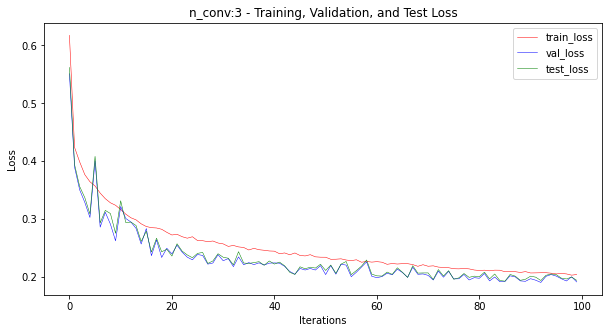

In [ ]:
plt.figure(figsize=(10,5))
plt.title(f"n_conv:{n_conv} - Training, Validation, and Test Loss")
plt.plot(train_loss, label="train_loss", color='red', linewidth=0.5)
plt.plot(val_loss, label="val_loss", color='blue', linewidth=0.5)
plt.plot(test_loss, label="test_loss", color='green', linewidth=0.5)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()